# lowess fit characteristics of curves and ... 

Partly updated to FEB2024!!!

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr, spearmanr

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
glob_temp = np.arange(-0.2,6.8,0.1)

add = ''
# add= '_temp_above_0_8'
# this is actually not neces
approach = '_via_5yravg'
DATE = 'Feb12_2024'

no_rel_farinotti = True ### did not do the lowess stuf rel_farinotti!!!

In [2]:
df = pd.read_csv(f'3_shift_summary_region_characteristics{DATE}.csv', index_col=[0])


In [7]:
pd_sel['slope_weighted_area_avg']

KeyError: 'slope_weighted_area_avg'

In [6]:
p_shift='_shift_years_rel_2020'

# todo: move that to the lowess fit stuff directly????
avg_over = '101yr'
#add = '_fit_to_median_lowess_added'
add = '_lowess_added_quantiles_added'
#GlacierMIP3/2023_exploratory_analysis_notebooks/fitted_lowess_best_frac_shift_years_rel_2020_100yr_avg_period_lowess_added_quantiles_added_current12deg_5000.csv
#fitted_lowess_best_frac_100yr_avg_period_fit_to_median_lowess_added_current12deg.csv
pd_sel = pd.read_csv(f'lowess_fits/fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_5000_{DATE}_ipcc_ar6.csv', index_col=[0])
pd_sel['rgi_reg'] = pd_sel.region.values
pd_sel= pd_sel.loc[np.isnan(pd_sel.y)]
#pd_sel = pd_sel.loc[pd_sel.year == 5000]
pd_sel.loc[pd_sel.region == 'All', 'region'] = 'Globally'
pd_sel.index = np.round(pd_sel.index.values,6)
pd_sel_rel_2020 = pd_sel.copy()
for r in df.index:
    scaling_factor_rel_itmix_to_rel_2020 = df.loc[r,'regional_volume_m3_itmix_vs_2020']
    pd_sel.loc[pd_sel.rgi_reg ==r, 'regional_volume_m3_itmix_vs_2020'] = scaling_factor_rel_itmix_to_rel_2020

if p_shift=='_shift_years_rel_2020':
    pd_sel['ice_loss_rel_2020'] = 100-pd_sel['0.5']
    #_add = '_lowess_added'
    _add = '_fit_to_median_lowess_added'
    # ok whatever, the iceloss relative farinotti is not perfectly the same fit , as currently for that, we only have the fit to the median
    # TODO --> ADD Here
    ### rel. farinotti is deprecated -
    if no_rel_farinotti: 
        pd_sel.loc[:, 'ice_loss_rel_farinotti'] = np.NaN
    else:
        pd_self = pd.read_csv(f'fitted_lowess_best_frac_{avg_over}_avg_period{_add}_current12deg_ipcc_ar6.csv', index_col=[0])
        pd_self= pd_self.loc[np.isnan(pd_self.y)]

        pd_self.index = np.round(pd_self.index.values,6)
        pd_self = pd_self.loc[pd_self.year == 5000]
        assert len(pd_self) == len(pd_sel)

        pd_self.loc[pd_self.region == 'All', 'region'] = 'Globally'
        pd_sel.loc[:, 'ice_loss_rel_farinotti'] = 100-pd_self['0.5'].values #pd_self.index.unique() 
else:
    pd_sel['ice_loss_rel_farinotti'] = 100-pd_sel['0.5']
    pd_sel['ice_loss_rel_2020'] = 100-pd_sel['0.5']*pd_sel['regional_volume_m3_itmix_vs_2020']
pd_sel['x']= pd_sel.index
pd_sel.to_csv(f'fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_w_ice_loss_steady_state_{DATE}.csv')

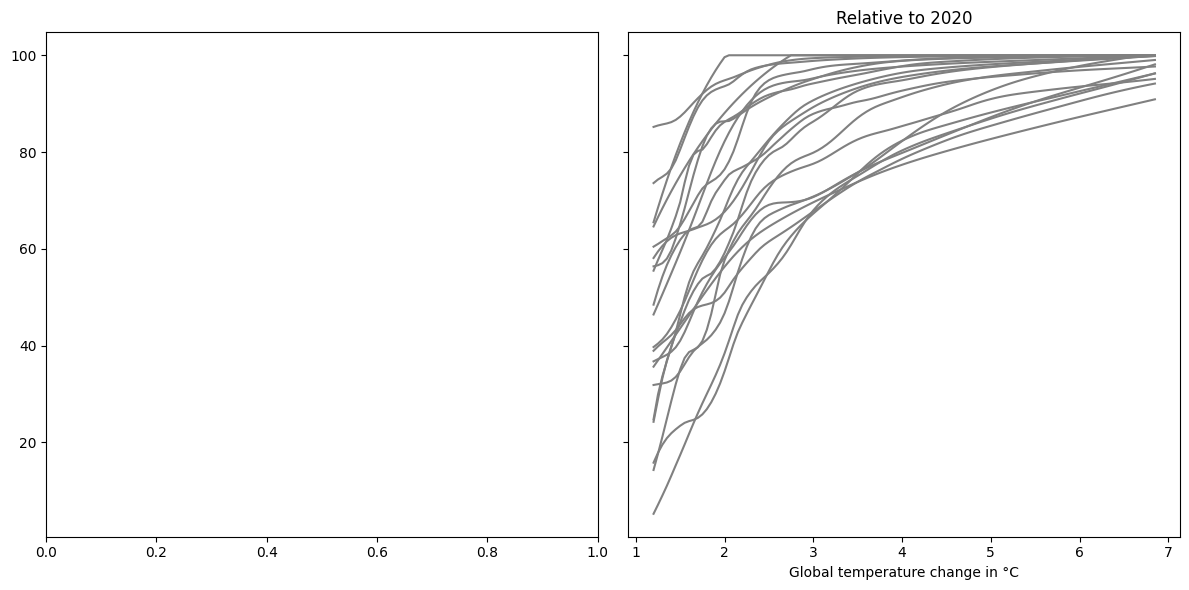

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey=True)
if not no_rel_farinotti: 
    for reg in pd_sel.region.unique():
        sns.lineplot(data=pd_sel.loc[(pd_sel.region==reg)&(pd_sel.x>=1.2)], ax = axs[0], 
                     x='x', y='ice_loss_rel_farinotti', color='grey')
    axs[0].set_ylabel('ice loss %')
    axs[0].set_xlabel('Global temperature change in °C')
    axs[0].set_title('Relative to Farinotti')
for reg in pd_sel.region.unique():
    sns.lineplot(data=pd_sel.loc[(pd_sel.region==reg)&(pd_sel.x>=1.2)],ax = axs[1], 
                 x='x', y='ice_loss_rel_2020', color='grey')
axs[1].set_ylabel('ice loss %')
axs[1].set_title('Relative to 2020')
axs[1].set_xlabel('Global temperature change in °C')

plt.tight_layout()

In [9]:
pd_lowess_ch = pd.DataFrame(index=df.region)
if no_rel_farinotti:
    opts = ['_rel_2020']
else:
    opts = ['_rel_farinotti', '_rel_2020']
opt_models = ['_only_global_models',''] # '' means all ... 
for opt_m in opt_models:
    for rel_add in opts: 
        for reg in pd_lowess_ch.index:
            if opt_m == '':
                _pd_sel = pd_sel
            else:
                if reg == 'Globally':
                    _pd_sel = pd.read_csv(f'lowess_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_fit_over_global_estimates_current12deg_5000_Feb12_2024_only_global_models_ipcc_ar6.csv',
                                     index_col=[0])
                    _pd_sel['rgi_reg'] = _pd_sel.region.values
                    _pd_sel.loc[_pd_sel.region == 'All', 'region'] = 'Globally'

                else:
                    _pd_sel = pd.read_csv('lowess_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_lowess_added_quantiles_added_current12deg_5000_Feb12_2024_only_global_models_ipcc_ar6.csv',
                                           index_col=[0])
                    _pd_sel['rgi_reg'] = _pd_sel.region.values
                _pd_sel= _pd_sel.loc[np.isnan(_pd_sel.y)]
                _pd_sel['x'] = _pd_sel.index
                #pd_sel = pd_sel.loc[pd_sel.year == 5000]
                _pd_sel.index = np.round(_pd_sel.index.values,6)
                _pd_sel['ice_loss_rel_2020'] = 100-_pd_sel['0.5']
            pd_reg = _pd_sel.loc[_pd_sel.region==reg]
            pd_reg_1_2 = pd_reg.loc[np.abs(pd_reg.x-1.2).idxmin()]
            ice_loss_reg_1_2 = pd_reg_1_2[f'ice_loss{rel_add}']
            pd_lowess_ch.loc[reg,f'ice_loss_1.2°C_%{rel_add}{opt_m}'] =  ice_loss_reg_1_2

            pd_reg_2_7 = pd_reg.loc[np.abs(pd_reg.x-2.7).idxmin()]
            ice_loss_reg_2_7 = pd_reg_2_7[f'ice_loss{rel_add}']
            pd_lowess_ch.loc[reg,f'ice_loss_2.7°C_%{rel_add}{opt_m}'] =  ice_loss_reg_2_7

            pd_reg_1_5 = pd_reg.loc[np.abs(pd_reg.x-1.5).idxmin()]
            ice_loss_reg_1_5 = pd_reg_1_5[f'ice_loss{rel_add}']
            pd_lowess_ch.loc[reg,f'ice_loss_1.5°C_%{rel_add}{opt_m}'] =  ice_loss_reg_1_5

            pd_reg_2 = pd_reg.loc[np.abs(pd_reg.x-2).idxmin()]
            ice_loss_reg_2 = pd_reg_2[f'ice_loss{rel_add}']
            pd_lowess_ch.loc[reg,f'ice_loss_2.0°C_%{rel_add}{opt_m}'] =  ice_loss_reg_2

            pd_reg_3 = pd_reg.loc[np.abs(pd_reg.x-3).idxmin()]
            ice_loss_reg_3 = pd_reg_3[f'ice_loss{rel_add}']
            pd_lowess_ch.loc[reg,f'ice_loss_3.0°C_%{rel_add}{opt_m}'] =  ice_loss_reg_3

            deg_celsius_ch = 1.5
            for temp0 in np.arange(1,2.1,0.1):
                temp1 = temp0+deg_celsius_ch
                ice_loss_diff = pd_reg.loc[np.abs(pd_reg.x-temp1).idxmin()][f'ice_loss{rel_add}']-pd_reg.loc[np.abs(pd_reg.x-temp0).idxmin()][f'ice_loss{rel_add}']
                pd_lowess_ch.loc[reg, f'ice_loss_slope_between_{temp0.round(1)}_and_{temp1.round(1)}_per_degC{rel_add}{opt_m}'] = (ice_loss_diff)/deg_celsius_ch

            deg_celsius_ch = 2
            for temp0 in np.arange(1,2.1,0.1):
                temp1 = temp0+deg_celsius_ch
                ice_loss_diff = pd_reg.loc[np.abs(pd_reg.x-temp1).idxmin()][f'ice_loss{rel_add}']-pd_reg.loc[np.abs(pd_reg.x-temp0).idxmin()][f'ice_loss{rel_add}']
                pd_lowess_ch.loc[reg, f'ice_loss_slope_between_{temp0.round(1)}_and_{temp1.round(1)}_per_degC{rel_add}{opt_m}'] = (ice_loss_diff)/deg_celsius_ch
pd_lowess_ch.loc[df.region, 'slope_weighted_area_avg'] = df['slope_weighted_area_avg'].values
pd_lowess_ch.loc[df.region, 'elev_diff_area_weighted'] = df['elev_diff_area_weighted'].values
pd_lowess_ch.loc[df.region, 'elev_diff_to_med_area_weighted'] = df['elev_diff_to_med_area_weighted'].values


cols_int = ['resp_time_-50%_1_5_deg', 'resp_time_-50%_3_0_deg',
       'resp_time_-80%_1_5_deg', # 'resp_time_-90%_1_5_deg',
            'resp_time_-80%_3_0_deg', #'resp_time_-90%_3_0_deg',
           'lat_weighted_area_avg',
            f'regional_volume_m3_2020{approach}', 'regional_volume_m3_itmix_vs_2020',
            'geodetic_obs_area_weighted',
       f'regional_dvol_dt_2000_2019_vs_2020_vol{approach}','dvoldt_m3_hugonnet','regional_volume_m3_itmix',
           '20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%',
                       '20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%',
       '20yr_regional_dvol_dt_2000_2019_vs_farinotti_vol_%',
           'lat_absolute_weighted_area_avg', 'slope_fit_reg_vs_glob_ch','median_reg_vs_glob_ch',
            'median_reg_vs_glob_temp_ch_0.8_1.5','median_reg_vs_glob_temp_ch_1.5_3.0',            
            'continentality_index_avg_2000-2019',
           'temp_ch_avg_2000-2019_vs_1901-1920',
           'temp_avg_2000-2019']
for c in cols_int:
    pd_lowess_ch.loc[df.region, c] = df[c].values

In [10]:
pd_lowess_ch[['ice_loss_1.2°C_%_rel_2020', 'ice_loss_1.2°C_%_rel_2020_only_global_models']] #, 'ice_loss_1.2°C_%_rel_farinotti']]

ice_loss_1.2°C_%_rel_2020  \
region                                
Globally                  39.710529   
01                        36.750452   
02                        73.590091   
03                        31.870277   
04                        85.193483   
05                        58.105886   
06                        60.449947   
07                        46.435430   
08                        65.491492   
09                        64.622947   
10                        55.486699   
11                        56.387937   
12                        24.265133   
13                        14.307882   
14                         5.252793   
15                        48.465352   
16                        24.774711   
17                        38.934510   
18                        15.817322   
19                        35.652339   

          ice_loss_1.2°C_%_rel_2020_only_global_models  
region                                                  
Globally                                     37.581498  
01                                           36.750452  
02                                           59.195319  
03                                           31.870277  
04                                           85.193483  
05                                           58.105886  
06                                           64.337587  
07                                           46.435430  
08                                           66.742266  
09                                           64.622947  
10                                           55.083791  
11                                           49.644148  
12                                           23.428711  
13                                           19.549786  
14                                           11.230802  
15                                           42.619793  
16                                           33.672472  
17                                           38.934510  
18                                           18.432033  
19                                           35.652339

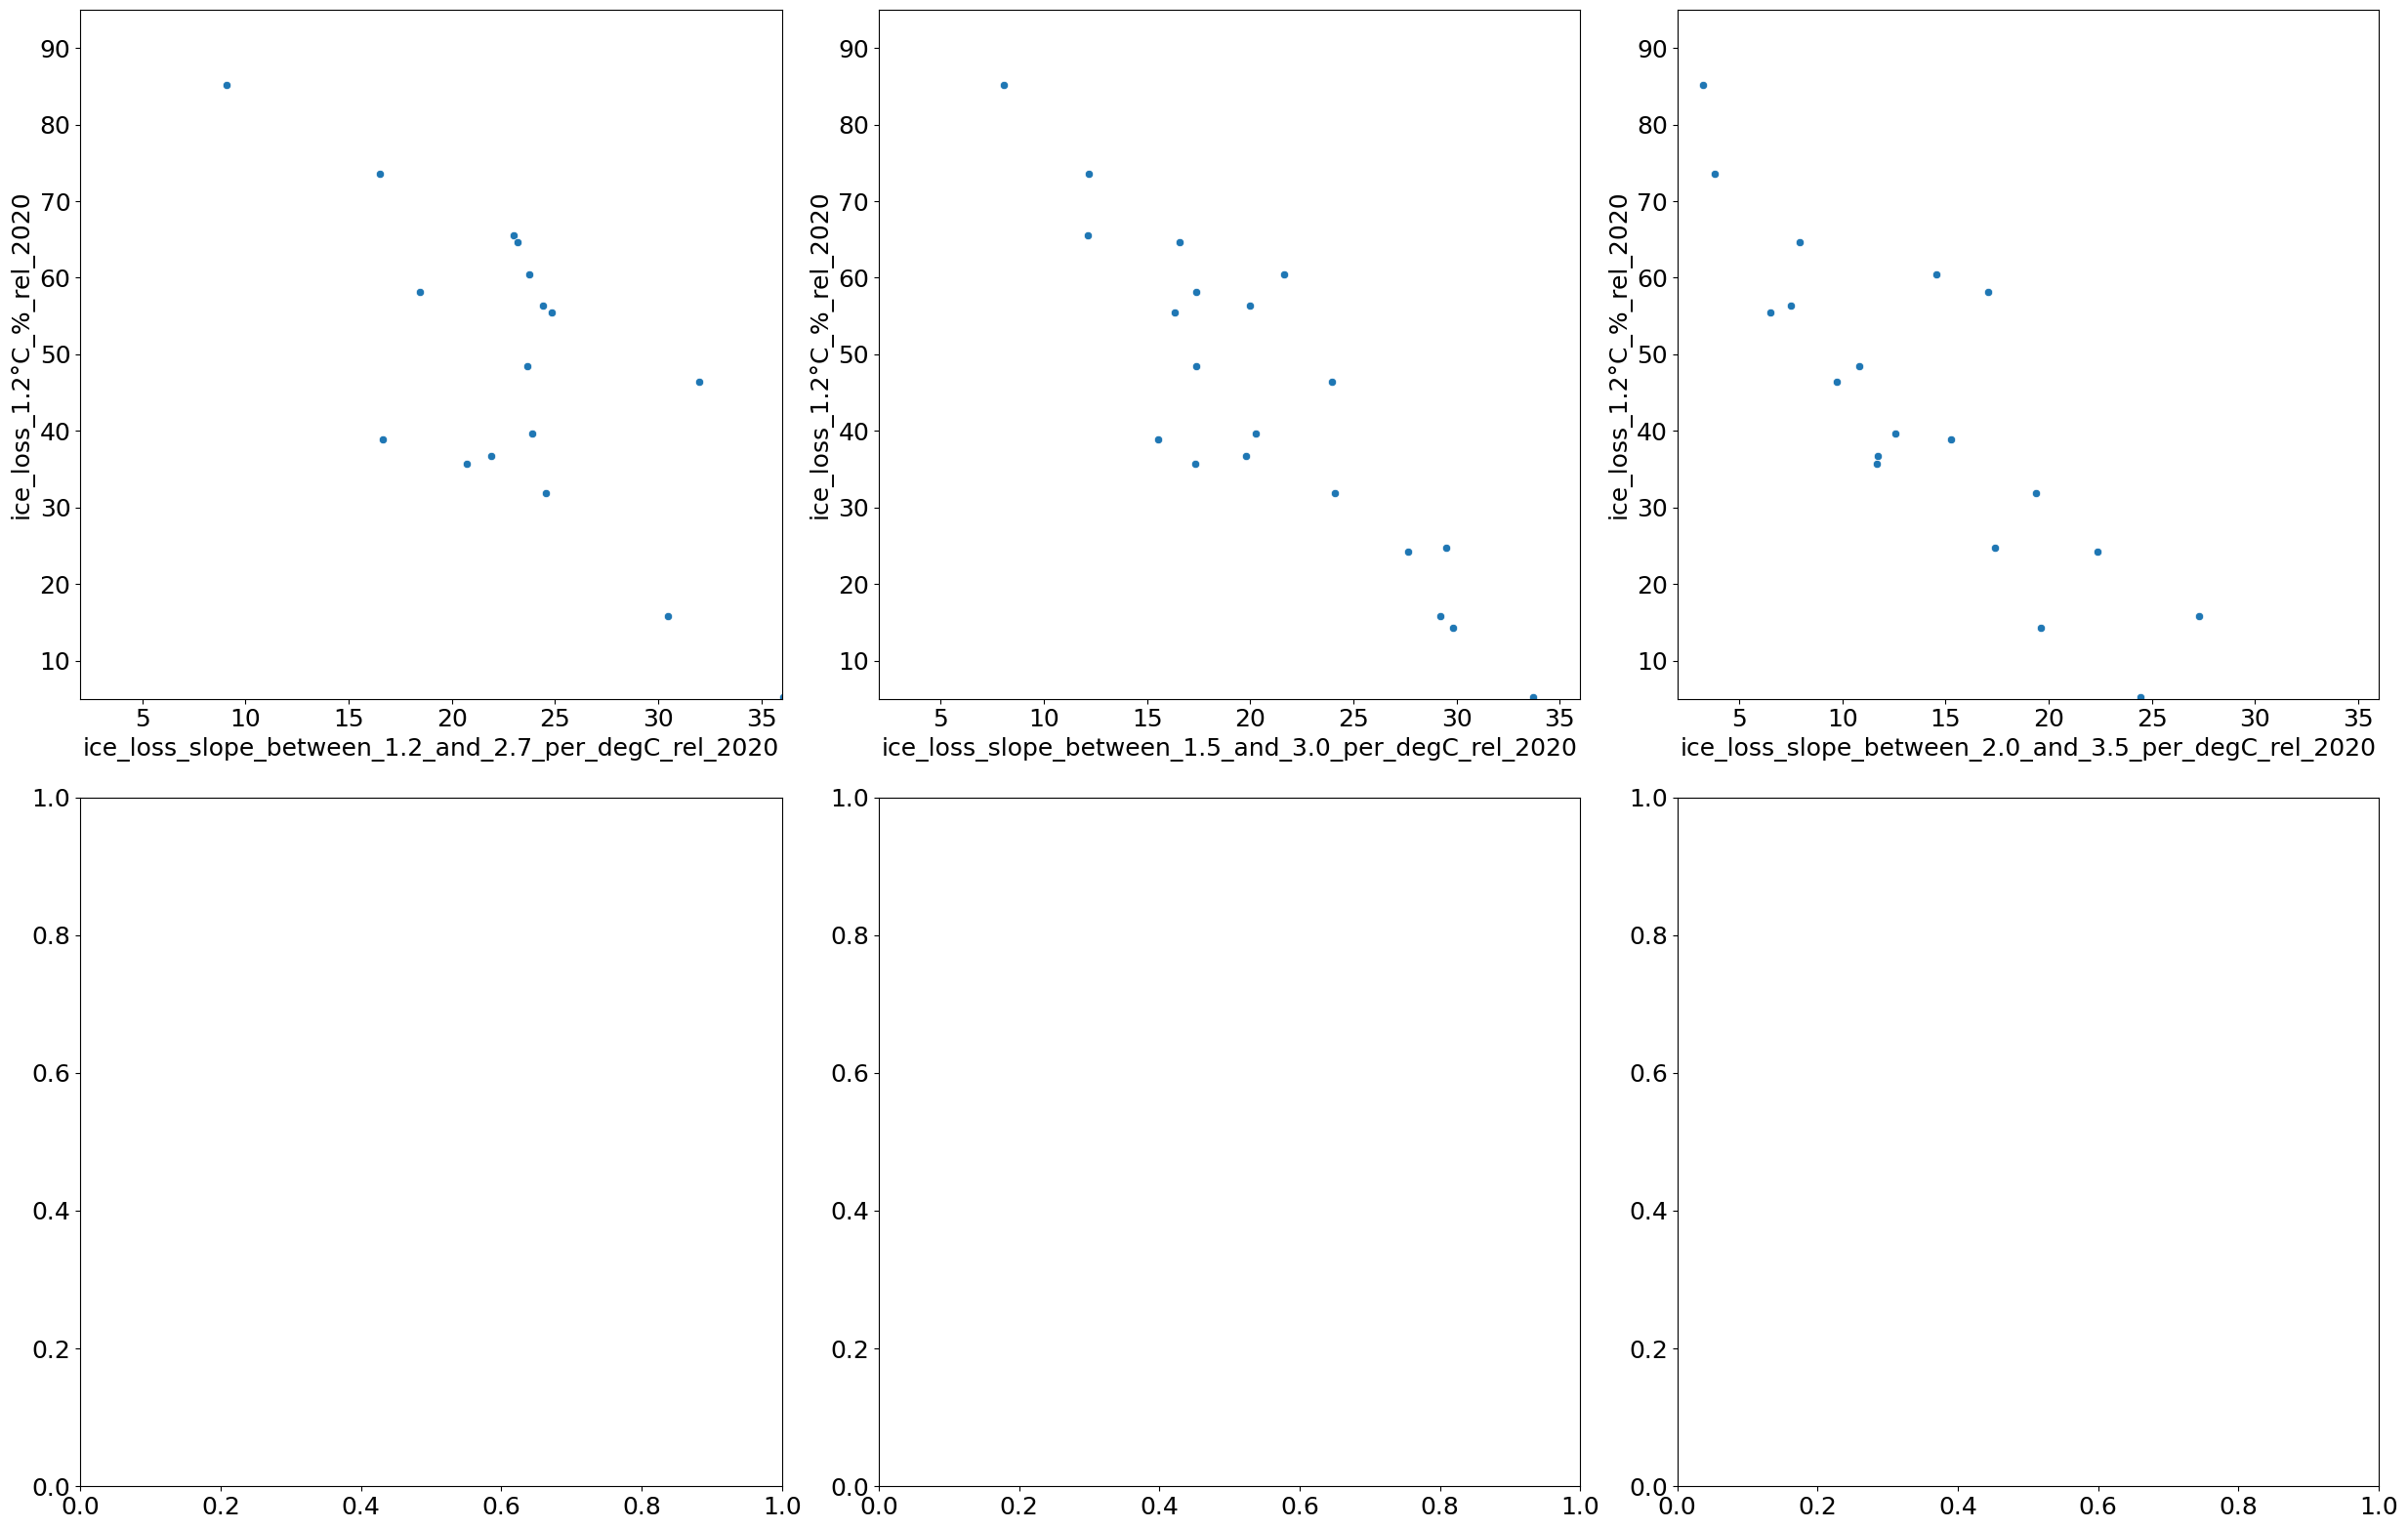

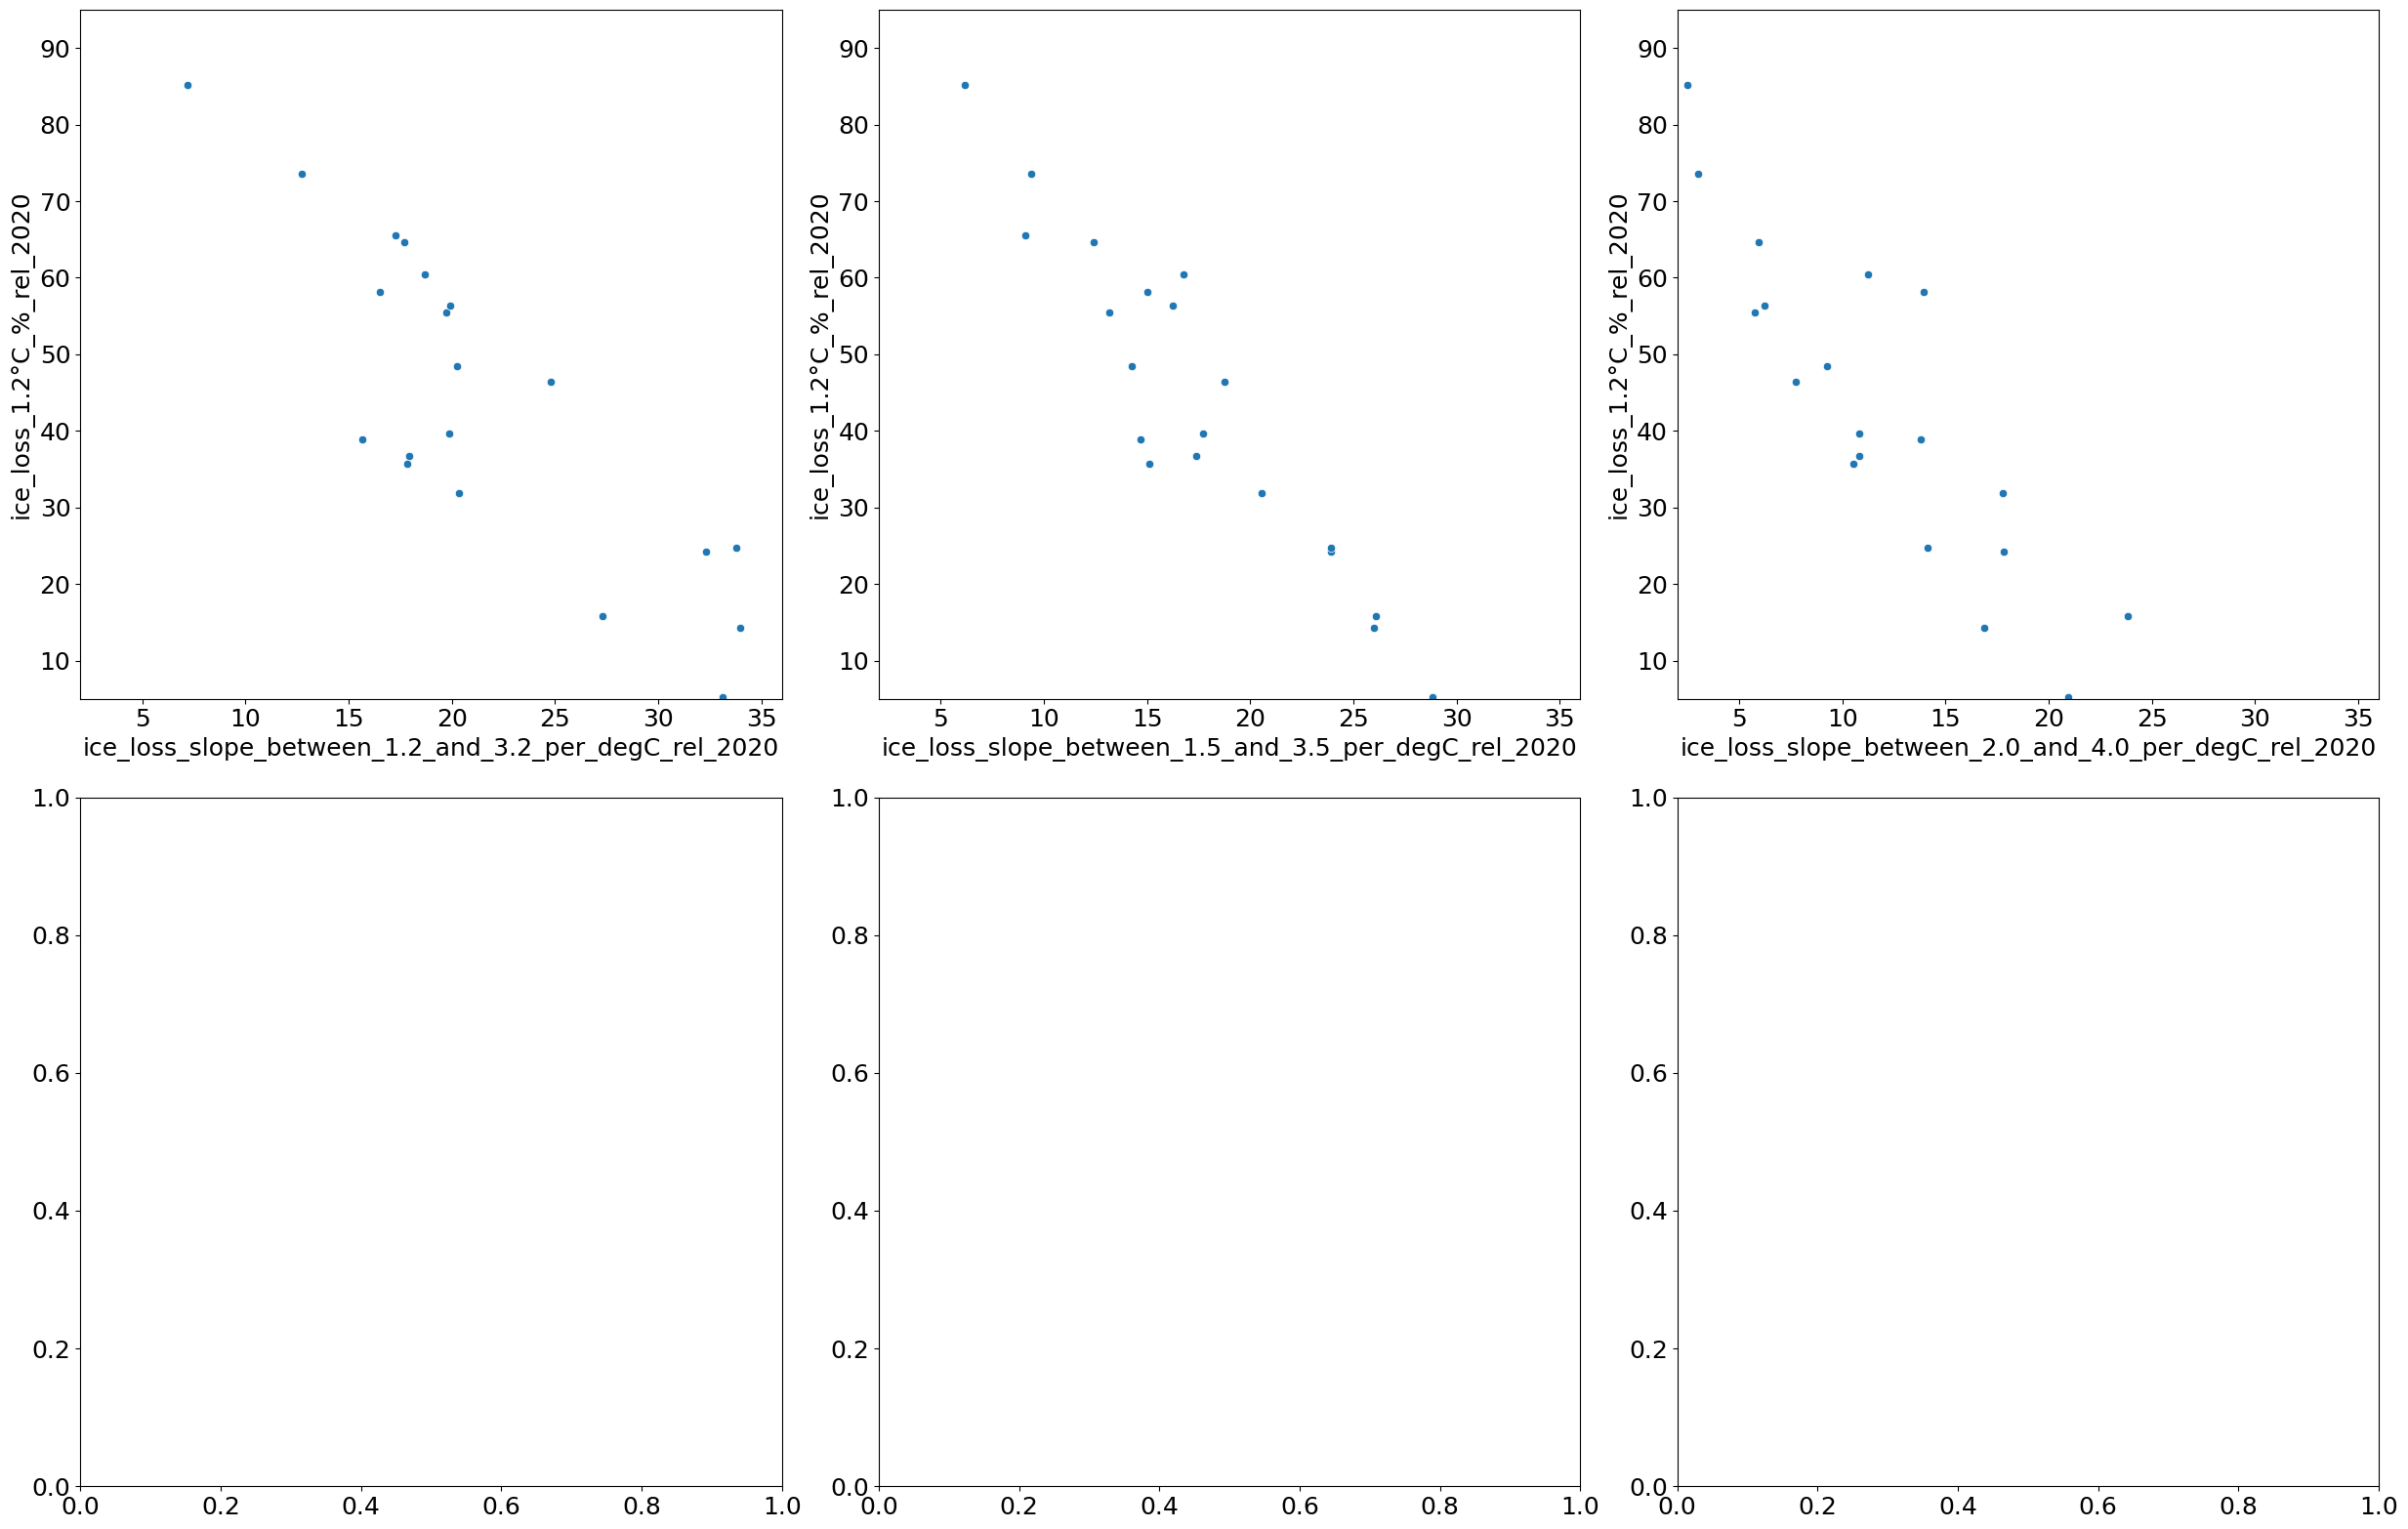

In [11]:
plt.rc('font', size=18)  

for deg_celsius_ch in [1.5, 2.0]:

    fig,axs = plt.subplots(2,3, figsize=(25,16))
    axs = axs.flatten()
    j  = 0

    for rel_add in opts: 
        for temp0 in np.array([1.2,1.5,2.0]):
            temp1 = temp0+deg_celsius_ch
            ax = axs[j]
            sns.scatterplot(data=pd_lowess_ch, x= f'ice_loss_slope_between_{temp0.round(1)}_and_{temp1.round(1)}_per_degC{rel_add}',
                            y=f'ice_loss_1.2°C_%{rel_add}', ax = ax, marker='o')
            ax.set_ylim([5,95])
            ax.set_xlim([2,36])
            j +=1
        plt.tight_layout()


**no real relationship anymore between ice loss slope and elevation range, but still with committed ice loss**

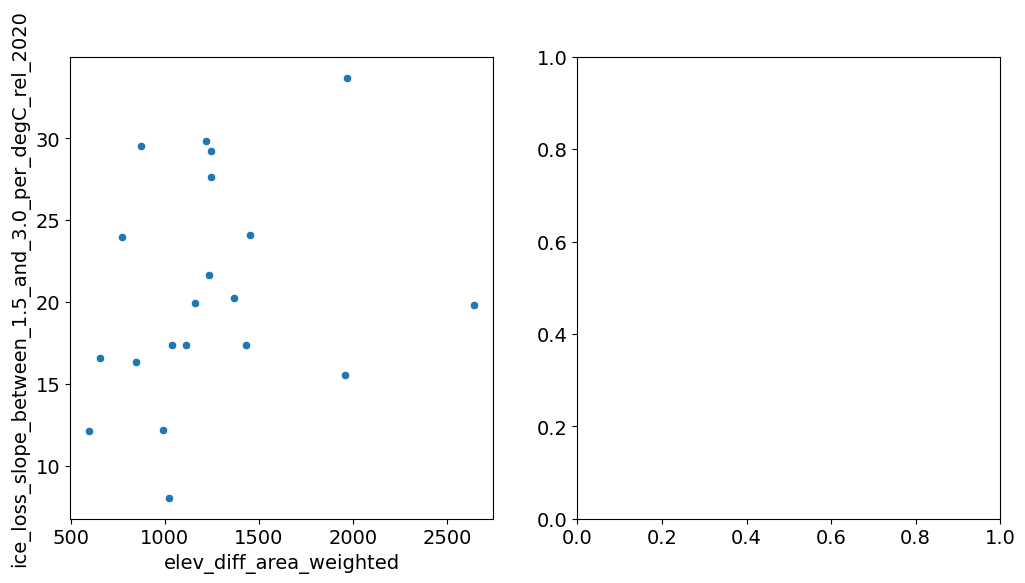

In [12]:
plt.rc('font', size=14)  

fig, axs = plt.subplots(1,2, figsize=(12,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]
    temp0 = 1.5
    temp1 = 3.0
    sns.scatterplot(data=pd_lowess_ch,ax =ax,
                    y= f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC{rel_add}',
                    x='elev_diff_area_weighted')

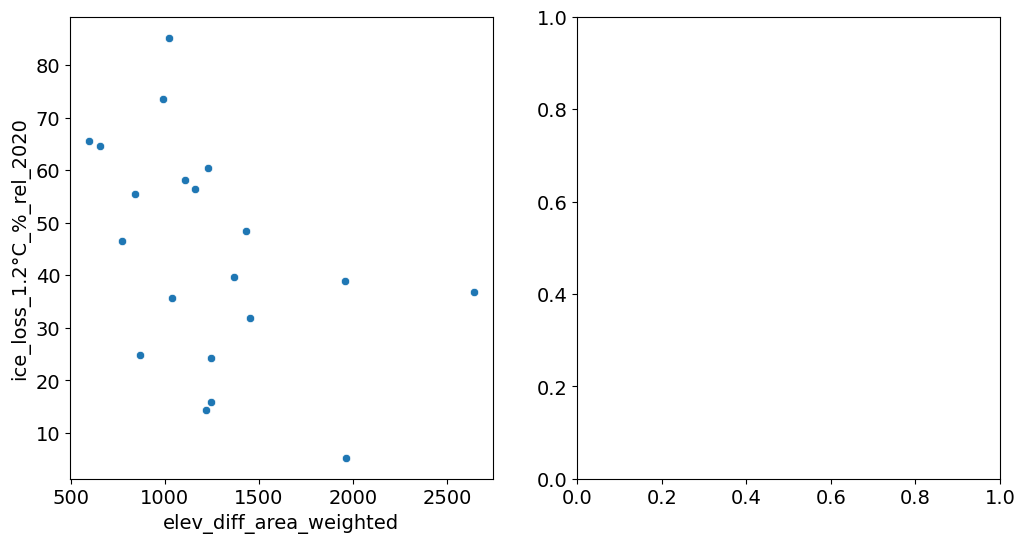

In [13]:
plt.rc('font', size=14)  

fig, axs = plt.subplots(1,2, figsize=(12,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]
    temp0 = 1.5
    temp1 = 3.0    
    sns.scatterplot(data=pd_lowess_ch,ax =ax,
                    x= f'elev_diff_area_weighted',
                    y=f'ice_loss_1.2°C_%{rel_add}')

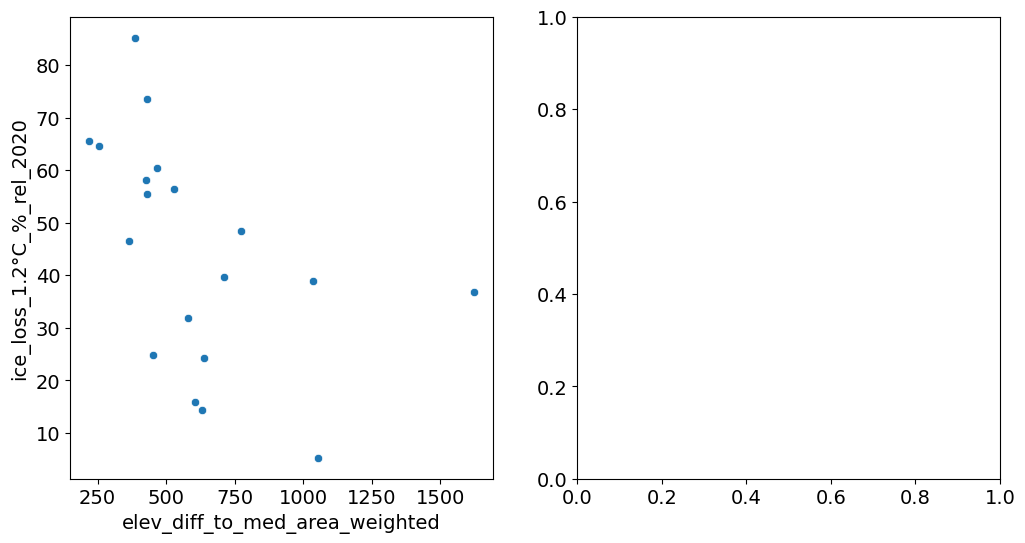

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]

    sns.scatterplot(data=pd_lowess_ch,ax =ax,
                    y=f'ice_loss_1.2°C_%{rel_add}',
                    x='elev_diff_to_med_area_weighted')

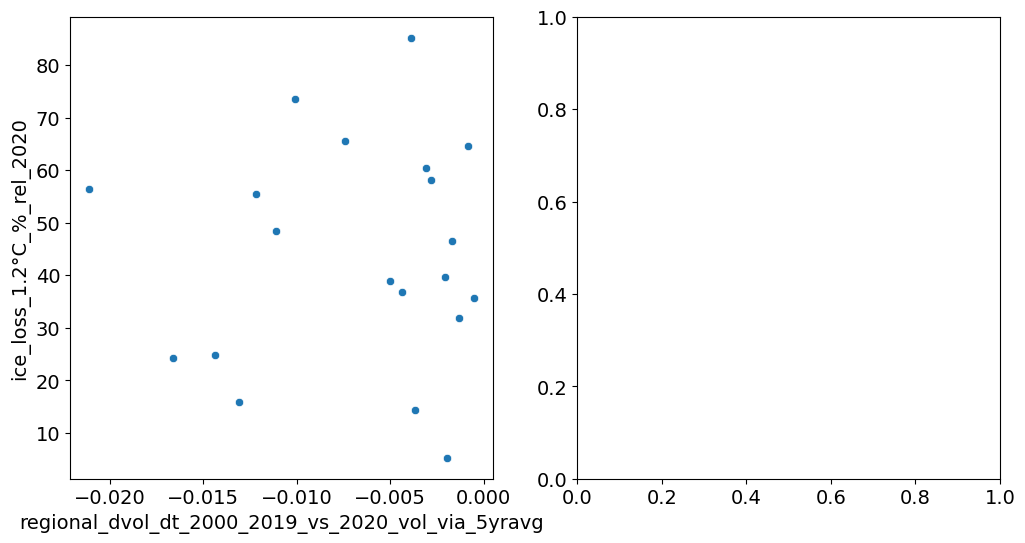

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]
    temp0 = 1.5
    temp1 = 3.0
    sns.scatterplot(data=pd_lowess_ch,ax =ax,
                    y= f'ice_loss_1.2°C_%{rel_add}',
                    x=f'regional_dvol_dt_2000_2019_vs_2020_vol{approach}')

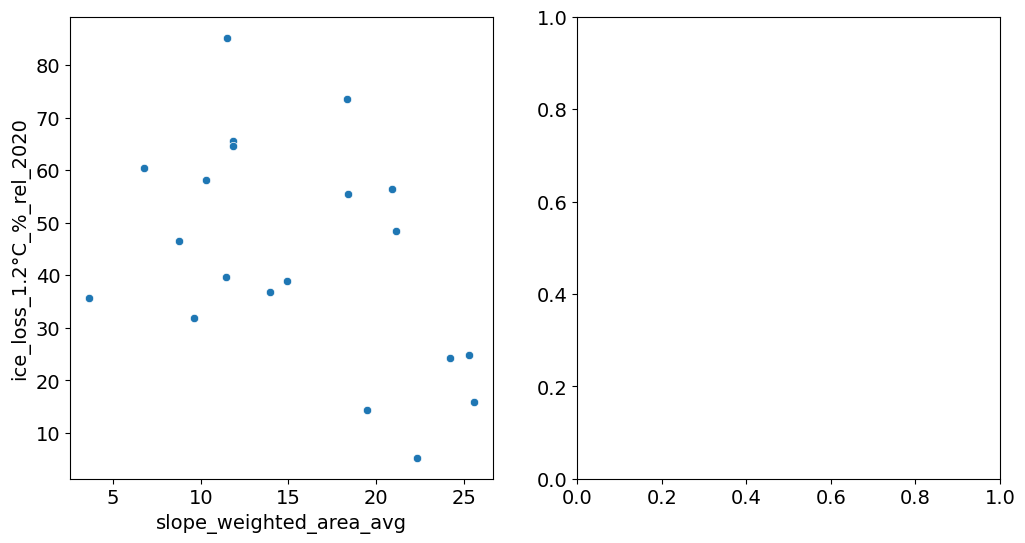

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]
    temp0 = 1.5
    temp1 = 3.0
    sns.scatterplot(data=pd_lowess_ch,ax =ax,
                    y= f'ice_loss_1.2°C_%{rel_add}',
                    x='slope_weighted_area_avg')

ice_loss_1.2°C_%_rel_2020_only_global_models  \
region                                                 
01                                         36.750452   
02                                         59.195319   
03                                         31.870277   
04                                         85.193483   
05                                         58.105886   
06                                         64.337587   
07                                         46.435430   
08                                         66.742266   
09                                         64.622947   
10                                         55.083791   
11                                         49.644148   
12                                         23.428711   
13                                         19.549786   
14                                         11.230802   
15                                         42.619793   
16                                         33.672472   
17                                         38.934510   
18                                         18.432033   
19                                         35.652339   

        ice_loss_2.7°C_%_rel_2020_only_global_models  \
region                                                 
01                                         69.605199   
02                                         97.721668   
03                                         68.715272   
04                                         98.839640   
05                                         85.791530   
06                                         97.265440   
07                                         94.410851   
08                                        100.000000   
09                                         99.436859   
10                                         91.881362   
11                                         92.639150   
12                                         82.236548   
13                                         81.618760   
14                                         70.870244   
15                                         84.449774   
16                                         87.274436   
17                                         63.899073   
18                                         63.967654   
19                                         66.745427   

        ice_loss_1.5°C_%_rel_2020_only_global_models  \
region                                                 
01                                         41.006398   
02                                         76.110398   
03                                         34.672412   
04                                         87.329776   
05                                         63.187782   
06                                         71.635396   
07                                         59.322025   
08                                         83.334054   
09                                         75.144727   
10                                         67.868900   
11                                         65.244721   
12                                         43.502239   
13                                         45.213216   
14                                         34.470583   
15                                         59.176542   
16                                         53.828979   
17                                         44.423419   
18                                         26.769872   
19                                         43.588799   

        ice_loss_2.0°C_%_rel_2020_only_global_models  \
region                                                 
01                                         58.193780   
02                                         90.520286   
03                                         46.676305   
04                                         94.821125   
05                                         67.660722   
06                                         83.602601   
07                           

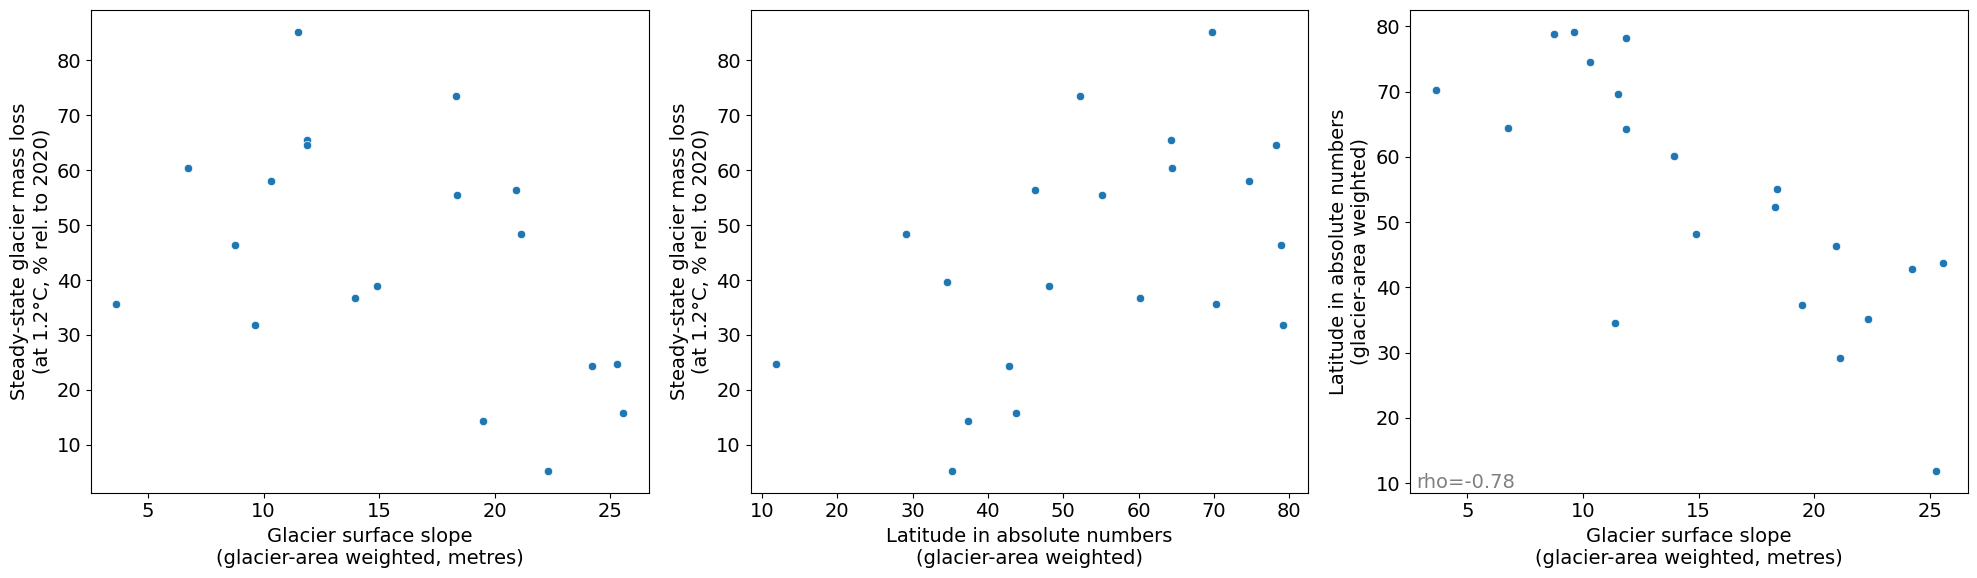

In [19]:
pd_lowess_ch_ng = pd_lowess_ch.loc[pd_lowess_ch.index != 'Globally']
print_spearman = True
fig, axs = plt.subplots(1,3, figsize=(20,6))
for j,rel_add in enumerate(opts): 
    ax = axs[j]
    temp0 = 1.5
    temp1 = 3.0
    sns.scatterplot(data=pd_lowess_ch_ng,ax =ax,
                    y= f'ice_loss_1.2°C_%{rel_add}',
                    x='slope_weighted_area_avg')
    corrcoef,pval = spearmanr(pd_lowess_ch[['slope_weighted_area_avg',f'ice_loss_1.2°C_%{rel_add}']].dropna()['slope_weighted_area_avg'].values,
                              pd_lowess_ch[['slope_weighted_area_avg',f'ice_loss_1.2°C_%{rel_add}']].dropna()[f'ice_loss_1.2°C_%{rel_add}'].values)
    corrcoef = corrcoef.round(2)
    if (pval <0.05) and print_spearman:
        ax.text(0.01,0.01, f'rho={corrcoef}', transform=ax.transAxes, color='grey')
    ax.set_xlabel('Glacier surface slope\n(glacier-area weighted, metres)')  
    ax.set_ylabel('Steady-state glacier mass loss\n(at 1.2°C, % rel. to 2020)')
ax = axs[1]
sns.scatterplot(data=pd_lowess_ch,ax =ax,
                y= f'ice_loss_1.2°C_%{rel_add}',
                x='lat_absolute_weighted_area_avg')
corrcoef,pval = spearmanr(pd_lowess_ch[['lat_absolute_weighted_area_avg',f'ice_loss_1.2°C_%{rel_add}']].dropna()['lat_absolute_weighted_area_avg'].values,
                          pd_lowess_ch[['lat_absolute_weighted_area_avg',f'ice_loss_1.2°C_%{rel_add}']].dropna()[f'ice_loss_1.2°C_%{rel_add}'].values)

corrcoef = corrcoef.round(2)

if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'rho={corrcoef}', transform=ax.transAxes, color='grey')
    
ax.set_ylabel('Steady-state glacier mass loss\n(at 1.2°C, % rel. to 2020)')
ax.set_xlabel('Latitude in absolute numbers\n(glacier-area weighted)')


ax = axs[2]
sns.scatterplot(data=pd_lowess_ch,ax =ax,
                x= f'slope_weighted_area_avg',
                y='lat_absolute_weighted_area_avg')
corrcoef,pval = spearmanr(pd_lowess_ch[['slope_weighted_area_avg','lat_absolute_weighted_area_avg']].dropna()['slope_weighted_area_avg'].values,
                          pd_lowess_ch[['slope_weighted_area_avg','lat_absolute_weighted_area_avg']].dropna()['lat_absolute_weighted_area_avg'].values)

corrcoef = corrcoef.round(2)

if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'rho={corrcoef}', transform=ax.transAxes, color='grey')
    
#ax.set_ylabel('Steady-state glacier mass loss\n(at 1.2°C, % rel. to 2020)')
ax.set_xlabel('Glacier surface slope\n(glacier-area weighted, metres)')  

ax.set_ylabel('Latitude in absolute numbers\n(glacier-area weighted)')
plt.tight_layout()

<AxesSubplot:xlabel='slope_fit_reg_vs_glob_ch', ylabel='median_reg_vs_glob_temp_ch_1.5_3.0'>

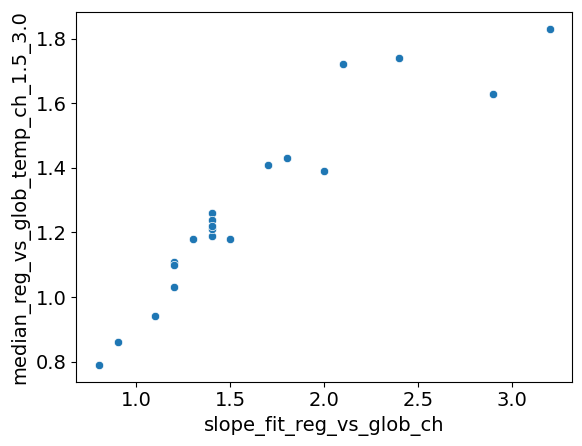

In [20]:
#sns.scatterplot(x='slope_fit_reg_vs_glob_ch', y='median_reg_vs_glob_ch',  data=df)
#             'median_reg_vs_glob_temp_ch_0.8_1.5','median_reg_vs_glob_temp_ch_1.5_3.0',            

#sns.scatterplot(x='slope_fit_reg_vs_glob_ch', y='median_reg_vs_glob_temp_ch_0.8_1.5',  data=df)
sns.scatterplot(x='slope_fit_reg_vs_glob_ch', y='median_reg_vs_glob_temp_ch_1.5_3.0',  data=df)

<AxesSubplot:xlabel='median_reg_vs_glob_temp_ch_0.8_1.5', ylabel='ice_loss_1.2°C_%_rel_2020'>

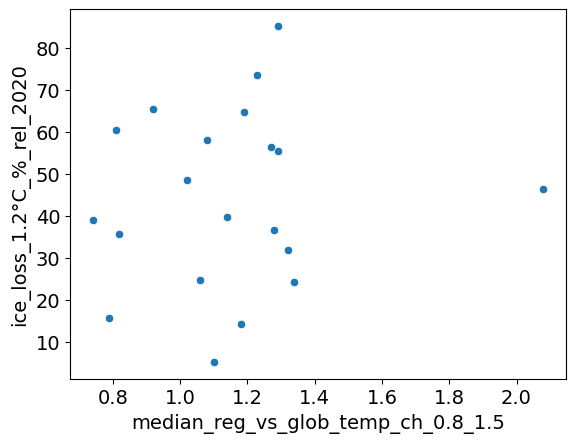

In [21]:
sns.scatterplot(y='ice_loss_1.2°C_%_rel_2020',
                x = 'median_reg_vs_glob_temp_ch_0.8_1.5', #'median_reg_vs_glob_temp_ch_1.5_3.0',
                data=pd_lowess_ch)

<AxesSubplot:xlabel='median_reg_vs_glob_temp_ch_1.5_3.0', ylabel='ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020'>

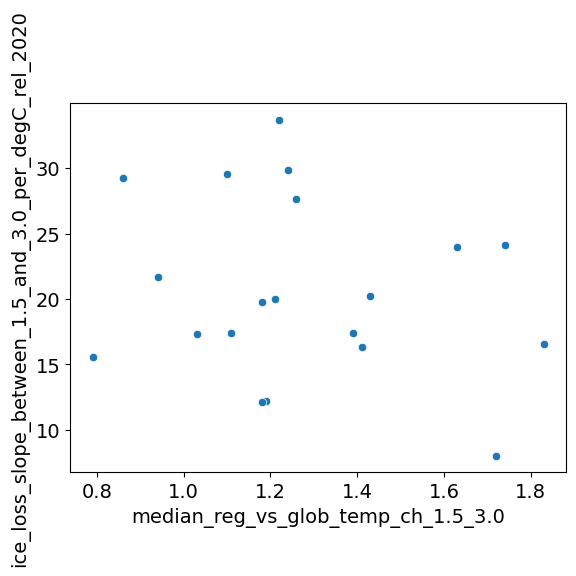

In [22]:
sns.scatterplot(y='ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020', #'ice_loss_1.2°C_%_rel_2020',
                x='median_reg_vs_glob_temp_ch_1.5_3.0',
                data=pd_lowess_ch)

### K-means clustering

In [23]:
# palette_cb = sns.color_palette(['#785EF0', '#DC267F', '#FE6100', '#FFB000', '#648FFF'])
cols = list(sns.color_palette('colorblind'))
palette_cb = sns.color_palette([cols[5],cols[4],cols[2], cols[7]])
pd_lowess_ch['region'] = pd_lowess_ch.index
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)',
            5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)',
            10:'(k)', 11:'(l)', 12:'(m)'} 

In [24]:
norm = True
if norm:
    norm_add = '_clusters_normalised'
else:
    norm_add = ''
regions = pd_lowess_ch.index.values
temp0 = 1.5
temp1 = 3.0
## limits for the K-meansclustering 
upper_lim = 3.0
lower_lim =1.2
#data = pd_lowess_ch[['ice_loss_1.2°C_%',
#                     f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC']].values
# let's rather use all data above 1.2 
# todo: (and maybe also below a certain temperature threshold to cluster the
# regions?
add_response_time  = False # we will show that separately instead
for k in [3]: #,4]: 
    for j,rel_add in enumerate(opts): 
        pd_ice_loss_reg = pd_sel.loc[(pd_sel.x>=1.199)&(pd_sel.x<=upper_lim)][[f'ice_loss{rel_add}', 'region', 'x']]
        pd_ice_loss_reg = pd_ice_loss_reg.reset_index(drop=True)
        pd_ice_loss_reg = pd_ice_loss_reg.loc[pd_ice_loss_reg.region != '0']
        pd_ice_loss_reg.index = pd_ice_loss_reg.x.round(6)
        temp_array = np.arange(lower_lim,upper_lim+0.01,0.05)
        pd_ice_loss_reg = pd_ice_loss_reg.loc[temp_array.astype(float).round(6)]
        pd_ice_loss_reg = pd_ice_loss_reg.reset_index(drop =True)

        pd_ice_loss_reg = pd_ice_loss_reg.pivot_table(columns='x', index='region',
                                                      values=f'ice_loss{rel_add}') 
        pd_ice_loss_reg =  pd_ice_loss_reg.dropna(axis=1)
        #assert len(pd_ice_loss_reg.columns) == len(temp_array)
        if norm: 
            pd_vol_all_norm = pd.DataFrame(normalize(pd_ice_loss_reg.loc[regions], axis=1)) 
            # axis = 0 makes the normalisation differently, but I found axis=0 creating more meaningful clustes ... 
            #pd_vol_all_norm = pd_vol_all_norm
            data = pd_vol_all_norm.values
        else:
            data = pd_ice_loss_reg.loc[regions].values 
        # Perform K-meansa clustering
        kmeans = KMeans(n_clusters=k, n_init=100, max_iter=1000, random_state=42)
        labels = ['test']
        #while np.any(labels != np.array([2, 0, 1, 0, 2, 2, 3, 3, 1, 
        #                                 1, 1, 1, 3, 0, 0, 2, 3, 0, 0, 0])):
        # [0, 0, 3, 0, 1, 2, 2, 2, 3, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0]
        # 
        #while np.any(labels!=np.array([[0, 0, 1, 0, 1, 2, 2, 2, 3, 1, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0]])):
        kmeans.fit(data)

        # Get the resulting centroids and labels
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Print the resulting centroids and labels
        #print("Centroids:")
        #print(centroids)
        print("Labels:")
        print(labels)
        if rel_add == '_rel_farinotti':
            pd_ice_loss_reg_rel_farinotti = pd_ice_loss_reg.copy()
        else:
            pd_ice_loss_reg_rel_2020 = pd_ice_loss_reg.copy()
        pd_lowess_ch[f'kmeans_cluster_{k}{rel_add}'] = labels
        print(pd_ice_loss_reg.max().max())
        pd_lowess_ch.to_csv(f'lowess_fit_cluster{k}_{rel_add}_{avg_over}_{add}{norm_add}{DATE}.csv')


Labels:
[2 2 0 2 0 0 0 2 0 0 0 0 2 1 1 0 2 0 1 2]
100.0


In [25]:
def plotlabel(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar+1, label, alpha=0.7, fontsize=20)

def plotlabel_b(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar-3, label, alpha=0.7, fontsize=20)
def plotlabel_bb(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar-30, label, alpha=0.7, fontsize=20)
def plotlabel_c(xvar, yvar, label, ax=None):
    ax.text(xvar-0.08, yvar+0.02, label, alpha=0.7, fontsize=20)

def plotlabel_cc(xvar, yvar, label, ax=None):
    ax.text(xvar-0.03, yvar-0.06, label, alpha=0.7, fontsize=20)


In [26]:
pd_lowess_ch = pd.read_csv(f'lowess_fit_cluster{k}_{rel_add}_{avg_over}_{add}{norm_add}{DATE}.csv',
                          index_col=[0])
pd_lowess_ch['region'] = pd_lowess_ch.index

/tmp/ipykernel_2373868/1153339964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _pd_lowess_ch['region'] = _pd_lowess_ch.index


-0.8298245614035088


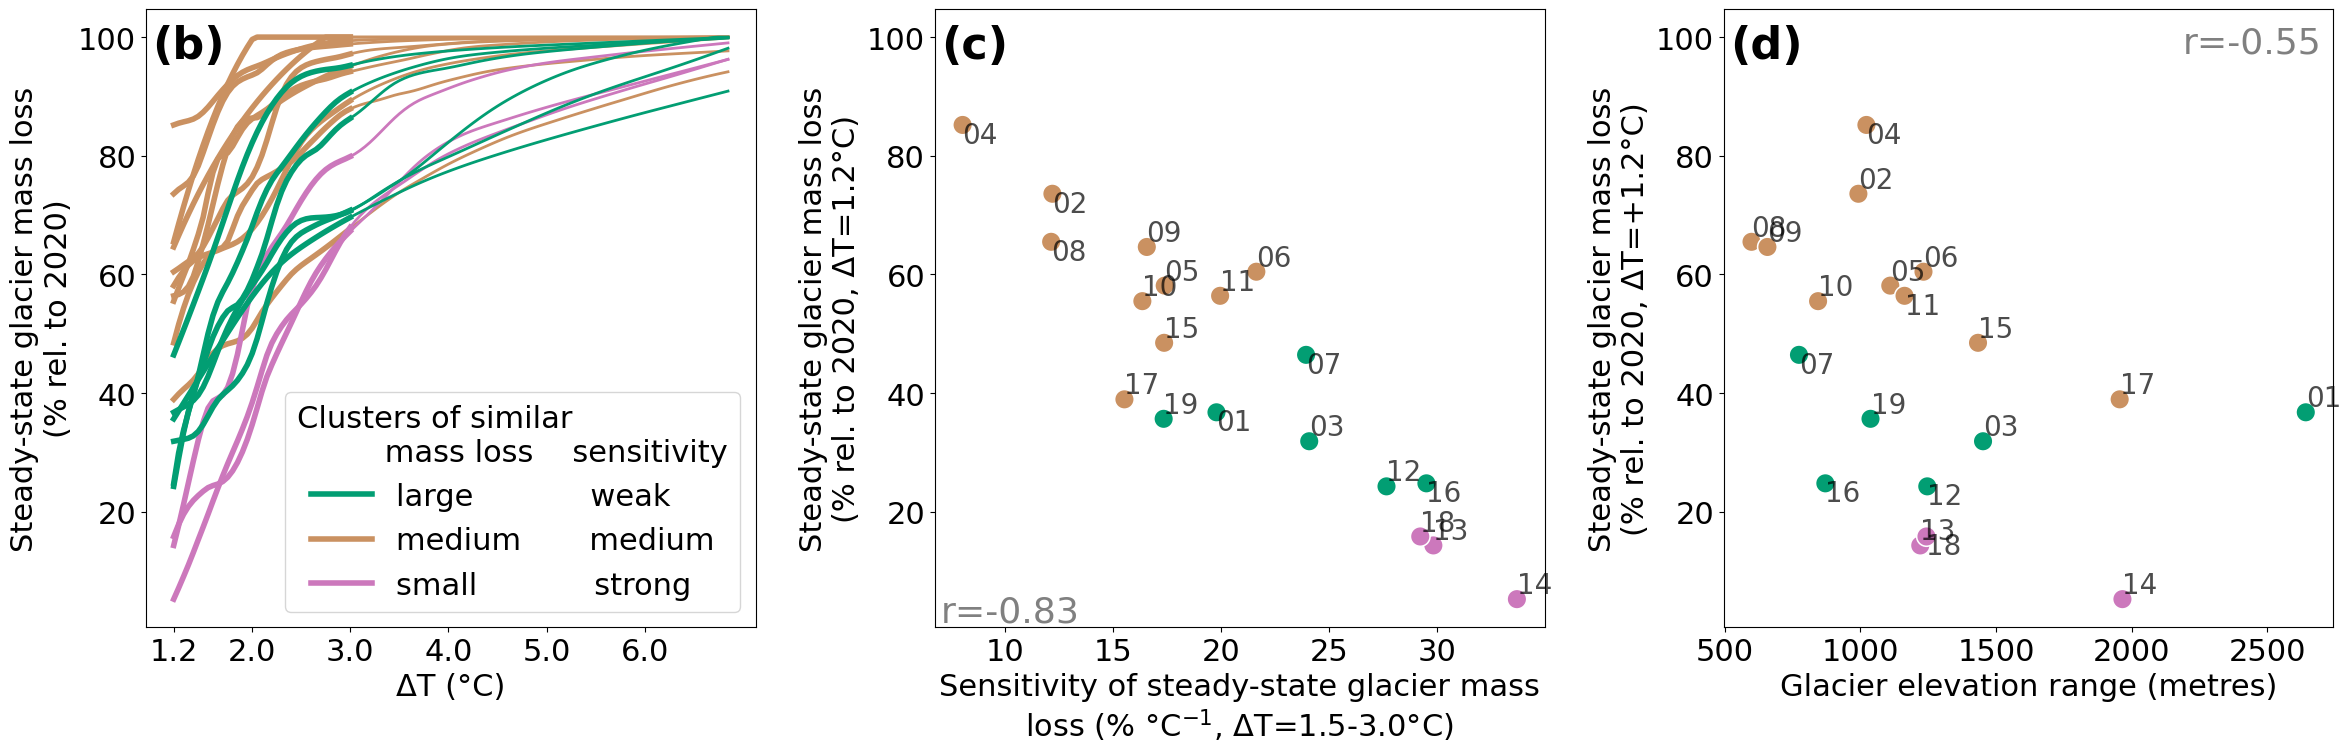

In [28]:
# remove global stuff
_pd_lowess_ch = pd_lowess_ch.loc[pd_lowess_ch.index!='Globally']
_pd_lowess_ch['region'] = _pd_lowess_ch.index
plt.rc('font', size=22)  
r=1

for j,rel_add in enumerate(opts): 

    if rel_add == '_rel_farinotti':
        pd_ice_loss_reg = pd_ice_loss_reg_rel_farinotti.copy()
    else:
        pd_ice_loss_reg = pd_ice_loss_reg_rel_2020.copy()
    # remove global stuff
    pd_ice_loss_reg = pd_ice_loss_reg.loc[pd_ice_loss_reg.index != 'Globally']

    if add_response_time:
        c=4
        plt.figure(figsize=(32,8))
    else:
        c=3
        plt.figure(figsize=(24,8))

    ax=plt.subplot(r,c,1)

    for kk in np.arange(0,k, 1):
        _pd_sel = _pd_lowess_ch.loc[_pd_lowess_ch[f'kmeans_cluster_{k}{rel_add}'] == kk]
        for reg in _pd_sel.index:
            #pd_sel_reg = _pd_sel.loc[reg]
            _vol_ch = pd_ice_loss_reg.loc[reg]
            ax.plot(_vol_ch.index, # global temperature change ... 
                    _vol_ch.values,
                    label=reg,
                    color=palette_cb[kk],lw=4, alpha = 1)
            sns.lineplot(data=pd_sel.loc[(pd_sel.region==reg)&(pd_sel['x']>=1.2)],
                         x='x', y=f'ice_loss{rel_add}', lw=2, color=palette_cb[kk], legend=True)

    if rel_add == '_rel_farinotti':
        ax.set_ylabel('Steady-state glacier mass loss\n(% rel. to Farinotti)') 
    else:
        ax.set_ylabel('Steady-state glacier mass loss\n(% rel. to 2020)') 

    ax.set_xlabel(r'ΔT (°C)') #+'\n(temperature change rel. to preindustrial)')
    ax.set_xticks([1.2,2,3,4,5,6])

    if (rel_add == '_rel_2020') & (k==3):
        handles, labels = ax.get_legend_handles_labels()
        # handles_l = [handles[0], handles[13],handles[18],handles[10]]
        a = [handles[11], handles[0],handles[-1]][::-1]
        labels_long_cluster = [r'large'+'            weak',
                               r'medium'+'       medium',
                               r'small'+'            strong']
        #labels_long_cluster = [r'large loss'+',\nweak ΔT\nsensitivity',
        #                       r'medium loss'+',\nmedium ΔT\nsensitivity',
        #                       r'low loss'+',\nstrong ΔT\nsensitivity']
        ax.legend(a,labels_long_cluster,
                  title = 'Clusters of similar\n' +'         mass loss' + '    sensitivity',
                  # K-means cluster (n=3):\nmedian of glacier models',
                  fontsize=22)        
    else:
        ax.get_legend().remove()
    ax1=ax

    ax=plt.subplot(r,c,2)
    xx=f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC{rel_add}'
    yy=f'ice_loss_1.2°C_%{rel_add}'
    temp0 = 1.5
    temp1 = 3.0
    sns.scatterplot(data=_pd_lowess_ch, x= xx,
                        y=yy, ax = ax,hue=f'kmeans_cluster_{k}{rel_add}',
                             palette=palette_cb[:k], s=200, legend = False)
    _plotlabel = plotlabel
    print_spearman = True
    corrcoef,pval = spearmanr(_pd_lowess_ch[[xx,yy]].dropna()[xx].values,
                              _pd_lowess_ch[[xx,yy]].dropna()[yy].values)
    print(corrcoef)
    corrcoef = corrcoef.round(2)
    if (pval <0.05) and print_spearman:
        ax.text(0.01,0.01, f'r={corrcoef}', ha='left', # spearman
                transform=ax.transAxes, color='grey', fontsize=26)
    #pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
    _pd_lowess_ch.drop(['01','04','02','07','16','08']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
    _pd_lowess_ch.loc[['01','04','02','07','16','08']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
    ax.set_xlabel('Sensitivity of steady-state glacier mass\nloss '+r'(% °C$^{-1}$, ΔT=1.5-3.0°C)')
    #(difference between {np.round(temp0,1)}°C and {np.round(temp1,1)}°C)')

    if rel_add == '_rel_farinotti':
        ax.set_ylabel('Ice loss in steady-state\n(% rel. to Farinotti, ΔT=1.2°C)') 
    else:
        ax.set_ylabel('Steady-state glacier mass loss\n(% rel. to 2020, ΔT=1.2°C)') 

    #ax.set_ylabel('Ice loss in steady-state\n(% rel. to initial state, ΔT=+1.2°C)') 

    ax2=ax
    ax=plt.subplot(r,c,3)
    top_to_median = False
    if top_to_median:
        drop_l = ['04','11','07','16','12','13','05']
        ax.set_xlabel(f'Glacier elevation range (top-median)\n(in metres, glacier-area weighted)')
        xx = 'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #

    else:
        drop_l = ['04','11','07','16','12','18']
        xx = 'elev_diff_area_weighted'
        ax.set_xlabel(f'Glacier elevation range (metres)') 
        # \n(in metres, glacier-area weighted)

    yy = f'ice_loss_1.2°C_%{rel_add}'
    sns.scatterplot(data=_pd_lowess_ch,
                    y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                    x=xx,
                    hue=f'kmeans_cluster_{k}{rel_add}',
                    palette=palette_cb[:k], s=200, legend = False)
    print_spearman = True
    corrcoef,pval = spearmanr(_pd_lowess_ch[[xx,yy]].dropna()[xx].values, _pd_lowess_ch[[xx,yy]].dropna()[yy].values)
    corrcoef = corrcoef.round(2)
    if (pval <0.05) and print_spearman:
        ax.text(0.98,0.93, f'r={corrcoef}', ha='right', # spearman
                transform=ax.transAxes, color='grey', fontsize=26)
    #pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
    _pd_lowess_ch.drop(drop_l).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
    _pd_lowess_ch.loc[drop_l].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
    if rel_add == '_rel_farinotti':
        ax.set_ylabel('Steady-state glacier mass loss\n(% rel. to Farinotti, ΔT=+1.2°C)') 
    else:
        ax.set_ylabel('Steady-state glacier mass loss\n(% rel. to 2020, ΔT=+1.2°C)')


    ax3=ax

    if (rel_add == '_rel_2020') & (k==3):
        num_text_x = 0.01
        num_text_y = 0.95
        if add_response_time: 
            ax=plt.subplot(r,c,4)
            ax=plt.gca()
            yy2='resp_time_-80%_1_5_deg'
            ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
            xx2 = f'resp_time_-50%_1_5_deg'
            xlabel2 = r'Years when 50% of change occurs ($\Delta$T=+1.5°C)'

            xx=f'slope_weighted_area_avg' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
            yy = 'resp_time_-80%_1_5_deg'
            sns.scatterplot(data=_pd_lowess_ch,
                            y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                            x=xx,
                            hue=f'kmeans_cluster_{k}{rel_add}',
                            palette=palette_cb[:k], s=200, legend = False)
            print_spearman = True
            corrcoef,pval = spearmanr(_pd_lowess_ch[[xx,yy]].dropna()[xx].values, _pd_lowess_ch[[xx,yy]].dropna()[yy].values)
            corrcoef = corrcoef.round(2)
            if (pval <0.05) and print_spearman:
                ax.text(0.01,0.01, f'spearmanr={corrcoef}', ha='left',
                        transform=ax.transAxes, color='grey', fontsize=22)
            #pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
            _pd_lowess_ch.drop(['11','10','19','16','17']).apply(lambda x: plotlabel(x[xx],x[yy], 
                                                                                     x.region, ax=ax), axis=1)
            _pd_lowess_ch.loc[['11','10','19','16','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], 
                                                                                       x.region, ax=ax),
                                                                axis=1)

            ax.set_ylabel(ylabel)

            ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')


            plt.ylim([-2,890])

            inset_ax = inset_axes(ax,
                                width="37%", # width = 30% of parent_bbox
                                height="36%", # height : 1 inch
                                loc='upper right',
                                #bbox_to_anchor=(1, 0.9, 0, 0),
                                   )
            #inset_ax.set_title(' t\n t', alpha =0)
            sns.scatterplot(df,y=yy2,x=xx2,ax=inset_ax, color='black')
            inset_ax.set_xlabel('year (50%)')
            inset_ax.set_ylabel('year (80%)') 
            #_plotlabel=plotlabel, _plotlabel_b=plotlabel_b)
            inset_ax.text(num_text_x, num_text_y*0.9,
                     num_dict[5], fontsize=26, transform=inset_ax.transAxes)

            #plt.text(0.99, 0.99,
            #         'R²=0.96', fontsize=22, color='grey', va='top', ha='right',
            #         transform=inset_ax.transAxes)
            #plt.ylim([-2,840])
            #inset_ax.grid(alpha=0.5)

            inset_ax.set_aspect('equal')
            ylim0,ylim1 = inset_ax.get_ylim()
            xlim0,xlim1 = inset_ax.get_xlim()
            lim0 = min(ylim0, xlim0)
            lim1 = max(ylim1, xlim1)
            inset_ax.set_xlim([lim0, lim1])
            inset_ax.set_ylim([lim0, lim1])

            inset_ax.set_xticks(np.arange(0,lim1,300))
            inset_ax.set_yticks(np.arange(0,lim1,300))

            ax.text(0.99,0.45, f"{np.nanmedian(df[yy2]/df[xx2]).round(1)} times longer\nfor 80% vs 50%\nof total changes", fontsize=22,
             transform=ax.transAxes, ha='right', va='top', color='lightgrey')
            ax4=ax

            num_text_x = 0.01
            for j,axi in enumerate([ax1,ax2,ax3, ax4]):
                num_text_y = 0.95
                axi.text(num_text_x, num_text_y,
                         num_dict[j+1], fontsize=26, transform=axi.transAxes)
                if j<3:
                    axi.set_ylim(ax1.get_ylim())
            plt.tight_layout()
            plt.savefig(f'figures/fig3_second_plot_{DATE}.png')
            plt.savefig(f'figures/fig3_second_plot_{DATE}.pdf')

        else:
            num_text_x = 0.01
            for j,axi in enumerate([ax1,ax2,ax3]):
                num_text_y = 0.92
                axi.text(num_text_x, num_text_y,
                         num_dict[j+1], fontsize=32, weight='bold',transform=axi.transAxes)
                if j<3:
                    axi.set_ylim(ax1.get_ylim())
            plt.tight_layout()
            plt.savefig(f'figures/fig3_second_plot_{DATE}.png')
            plt.savefig(f'figures/fig3_second_plot_{DATE}.pdf')




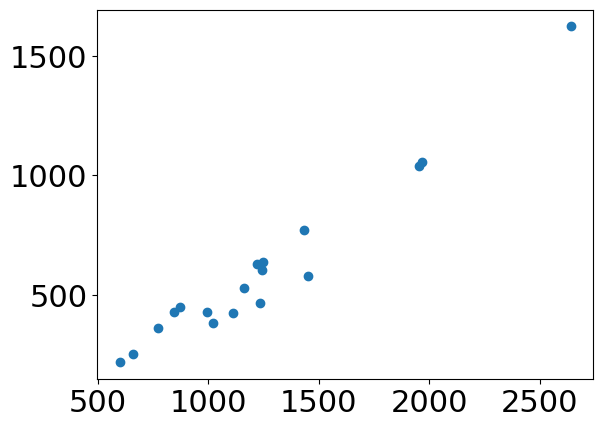

In [29]:
plt.plot(df['elev_diff_area_weighted'], df['elev_diff_to_med_area_weighted'], 'o')

Not a clear rleationshopt to the regional amplified warming ... see fig. below

-0.8120300751879698


region
01    None
04    None
02    None
07    None
15    None
dtype: object

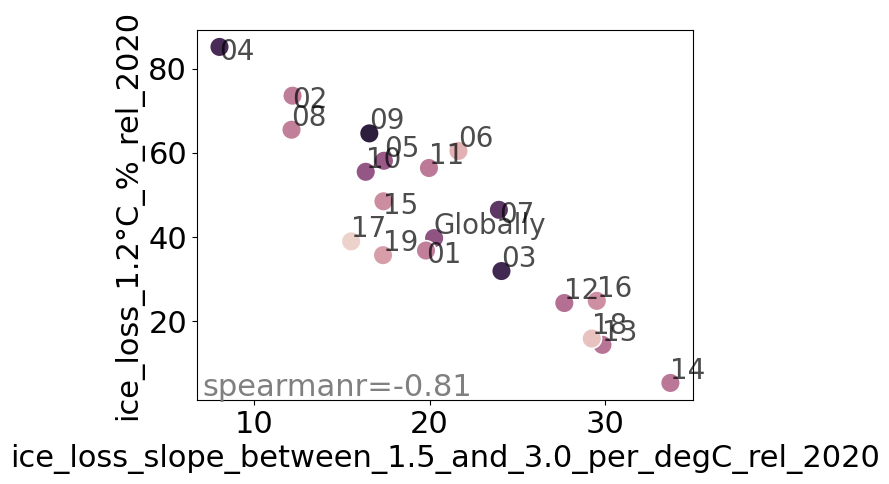

In [30]:
ax = plt.gca()
xx=f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC{rel_add}'

yy=f'ice_loss_1.2°C_%{rel_add}'
temp0 = 1.5
temp1 = 3.0
sns.scatterplot(data=pd_lowess_ch, x= xx,
                    y=yy, ax = ax,hue='median_reg_vs_glob_temp_ch_1.5_3.0',
                         #palette=palette_cb[:k],
                s=200, legend = False)
_plotlabel = plotlabel
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
print(corrcoef)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'spearmanr={corrcoef}', ha='left',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['01','04','02','07','15']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['01','04','02','07','15']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


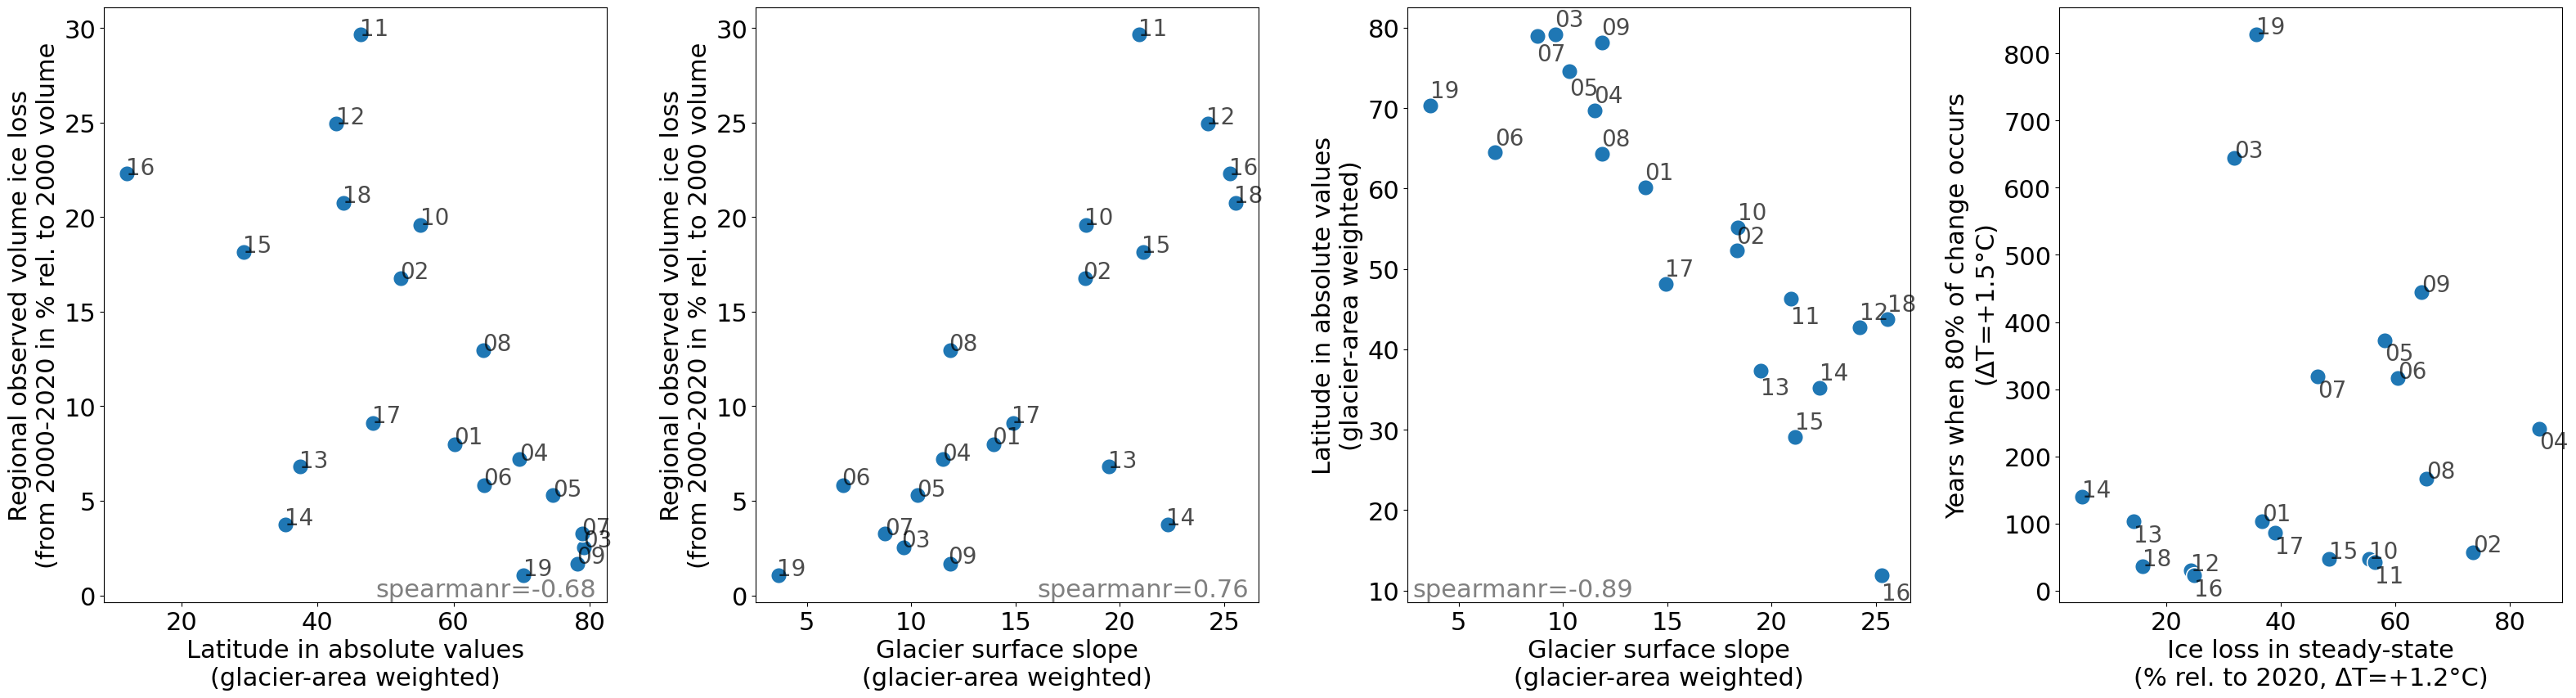

In [31]:
#pd_lowess_ch['lat_abs_weighted_area_avg'] = np.abs(pd_lowess_ch['lat_weighted_area_avg']).values
plt.figure(figsize=(32,9))
r=1
c=4
ax=plt.subplot(r,c,1)
num_text_x = 0.01
num_text_y = 0.95


yy2='lat_absolute_weighted_area_avg'
ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
xx2 = f'resp_time_-80%_1_5_deg'

yy=  f'20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
xx = 'lat_absolute_weighted_area_avg' #'lat_abs_weighted_area_avg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k], 
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.98,0.01, f'spearmanr={corrcoef}', ha='right',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel_c(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_cc(x[xx],x[yy], x.region, ax=ax), axis=1)
ax.set_ylabel(f'Regional observed volume ice loss\n(from 2000-2020 in % rel. to 2000 volume')
ax.set_xlabel(f'Latitude in absolute values\n(glacier-area weighted)')


ax=plt.subplot(r,c,2)
num_text_x = 0.01
num_text_y = 0.95


yy2=''
ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
xx2 = f'resp_time_-80%_1_5_deg'

yy=  f'20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
xx = 'slope_weighted_area_avg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k],
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.98,0.01, f'spearmanr={corrcoef}', ha='right',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel_c(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_cc(x[xx],x[yy], x.region, ax=ax), axis=1)
ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')

ax.set_ylabel(f'Regional observed volume ice loss\n(from 2000-2020 in % rel. to 2000 volume')

#ax.set_ylabel(ylabel)

#ax.set_xlabel(f'Regional observed volume change\n(from 2000-2020 in % rel. to 2020 volume')


#äplt.ylim([-2,850])

ax=plt.subplot(r,c,3)
num_text_x = 0.01
num_text_y = 0.95


yy2=''
ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
xx2 = f'resp_time_-80%_1_5_deg'

yy=f'lat_absolute_weighted_area_avg' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
xx = 'slope_weighted_area_avg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k],
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'spearmanr={corrcoef}', ha='left',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','11','07','16','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','11','07','16','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')
ax.set_ylabel(f'Latitude in absolute values\n(glacier-area weighted)')


ax=plt.subplot(r,c,4)
num_text_x = 0.01
num_text_y = 0.95



xx=f'ice_loss_1.2°C_%_rel_2020' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k],
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.98,0.01, f'rho={corrcoef}', ha='right',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','04','11','07','16','13','17']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','04','11','07','16','13','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)
#ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')
#ax.set_ylabel(f'Latitude in absolute values\n(glacier-area weighted)')
ax.set_ylabel('Years when 80% of change occurs\n'+r'($\Delta$T=+1.5°C)')
ax.set_xlabel('Ice loss in steady-state\n(% rel. to 2020, ΔT=+1.2°C)')

plt.tight_layout()


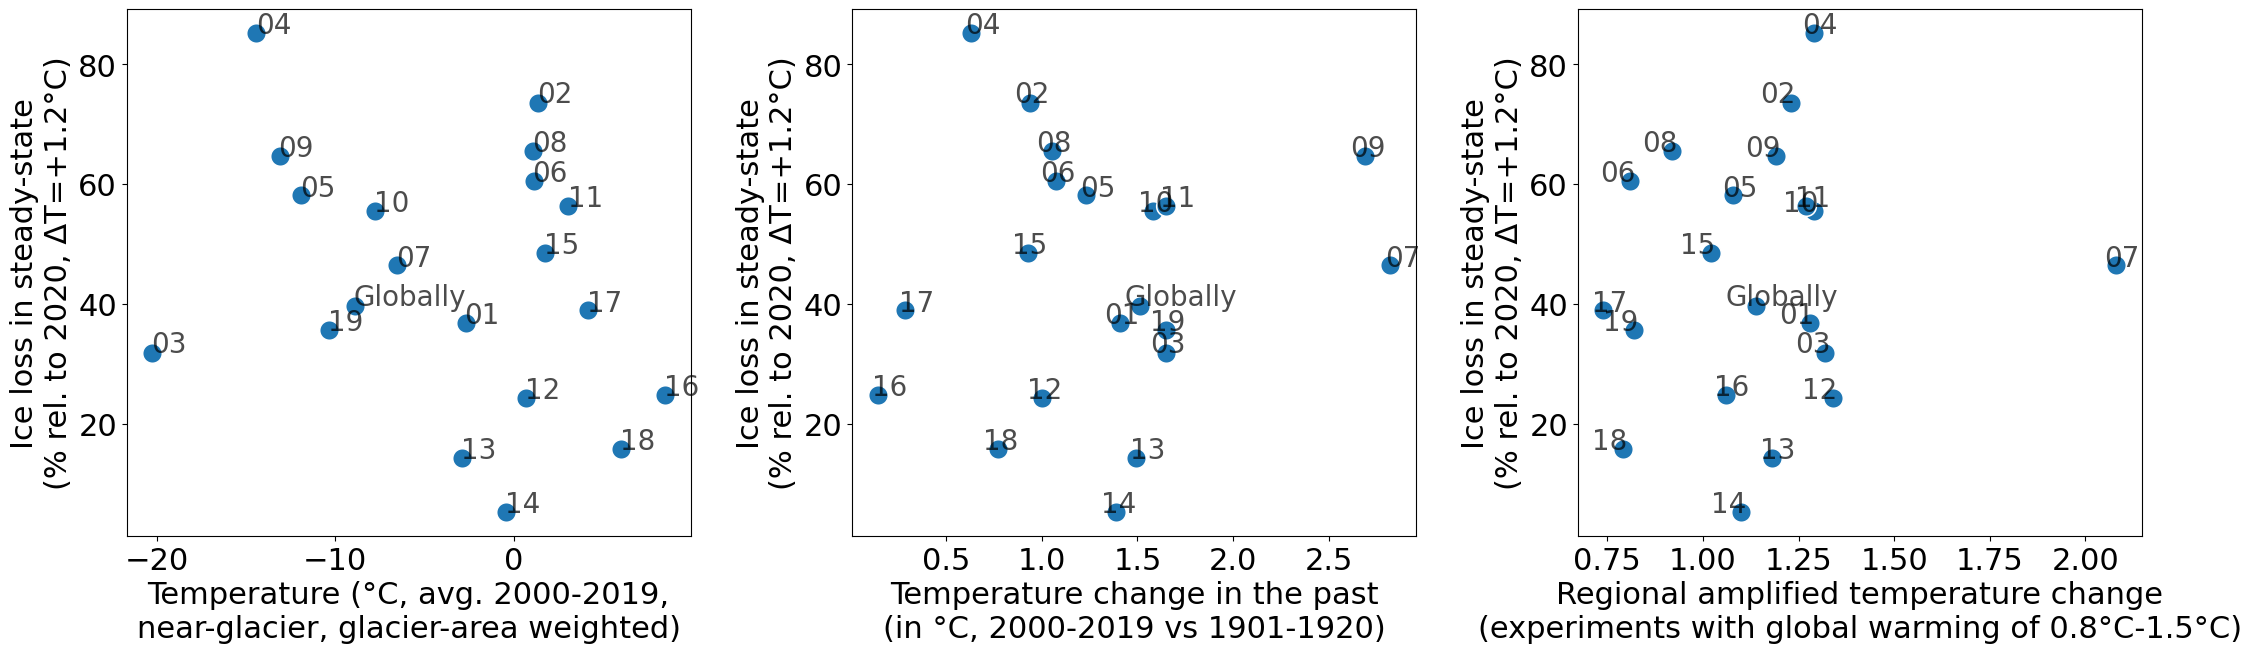

In [32]:
plt.figure(figsize=(22,7))
yy=f'ice_loss_1.2°C_%_rel_2020'
xxs=['temp_avg_2000-2019','temp_ch_avg_2000-2019_vs_1901-1920','median_reg_vs_glob_temp_ch_0.8_1.5']
for j,xx in enumerate(xxs):
    plt.subplot(1,3,j+1)
    ax = plt.gca()
    sns.scatterplot(y=yy,
                    x = xx, #'median_reg_vs_glob_temp_ch_1.5_3.0',
                    data=pd_lowess_ch, ax=ax, s=200)
    print_spearman = True
    corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
    corrcoef = corrcoef.round(2)
    if (pval <0.05) and print_spearman:
        ax.text(0.98,0.01, f'spearmanr={corrcoef}', ha='right',
                transform=ax.transAxes, color='grey', fontsize=22)
    #pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
    pd_lowess_ch.drop(['05','04','11','07','16','13','17']).apply(lambda x: plotlabel_c(x[xx],x[yy], x.region, ax=ax), axis=1)
    pd_lowess_ch.loc[['05','04','11','07','16','13','17']].apply(lambda x: plotlabel_cc(x[xx],x[yy], x.region, ax=ax), axis=1)
    #ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')
    #ax.set_ylabel(f'Latitude in absolute values\n(glacier-area weighted)')
    #ax.set_ylabel(r'Years when 80% of change occurs ($\Delta$T=+1.5°C)')
    if xx == 'temp_ch_avg_2000-2019_vs_1901-1920':
        ax.set_xlabel('Temperature change in the past\n(in °C, 2000-2019 vs 1901-1920)')
    elif xx == 'temp_avg_2000-2019':
        ax.set_xlabel('Temperature (°C, avg. 2000-2019,\nnear-glacier, glacier-area weighted)')

    else:
        ax.set_xlabel('Regional amplified temperature change\n(experiments with global warming of 0.8°C-1.5°C)')
    ax.set_ylabel('Ice loss in steady-state\n(% rel. to 2020, ΔT=+1.2°C)')
plt.tight_layout()
plt.savefig('figures/3c_scatter_temp_region_ice_loss.png')

- RGI04 is a region where temperatures are one of the coldest and where temp. change in the past (20 last years vs 1901-1920) was relatively small
- RGI04 is a region where one of the largest regional amplified temp. change occurs at current warming levels (so warming levels between 0.8 and 1.5°C) 

Text(0.5, 0, 'Ice loss in steady-state\n(% rel. to 2020, ΔT=+1.2°C)')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


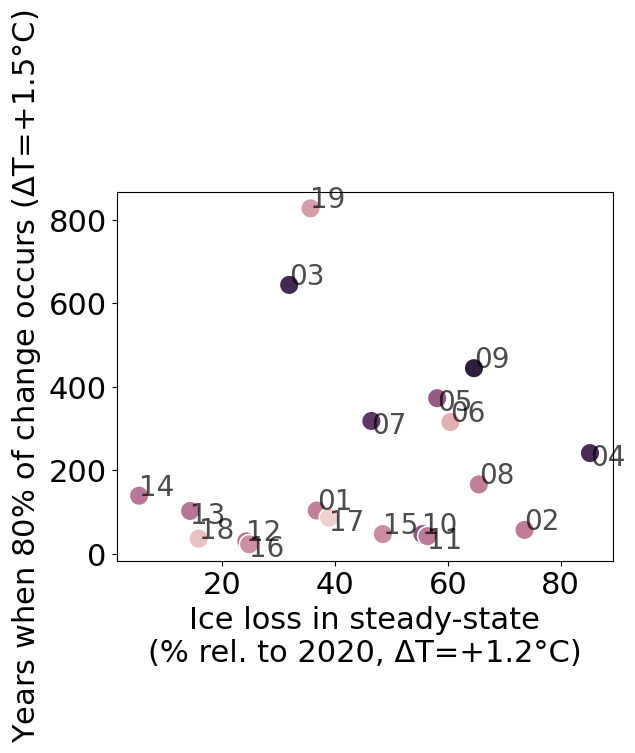

In [33]:
ax = plt.gca()
xx=f'ice_loss_1.2°C_%_rel_2020' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,hue='median_reg_vs_glob_temp_ch_1.5_3.0',
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k],
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.98,0.01, f'spearmanr={corrcoef}', ha='right',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','04','11','07','16','13','17']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','04','11','07','16','13','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)
#ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')
#ax.set_ylabel(f'Latitude in absolute values\n(glacier-area weighted)')
ax.set_ylabel(r'Years when 80% of change occurs ($\Delta$T=+1.5°C)')
ax.set_xlabel('Ice loss in steady-state\n(% rel. to 2020, ΔT=+1.2°C)')

Text(0.5, 0, 'median_reg_vs_glob_temp_ch_1.5_3.0')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


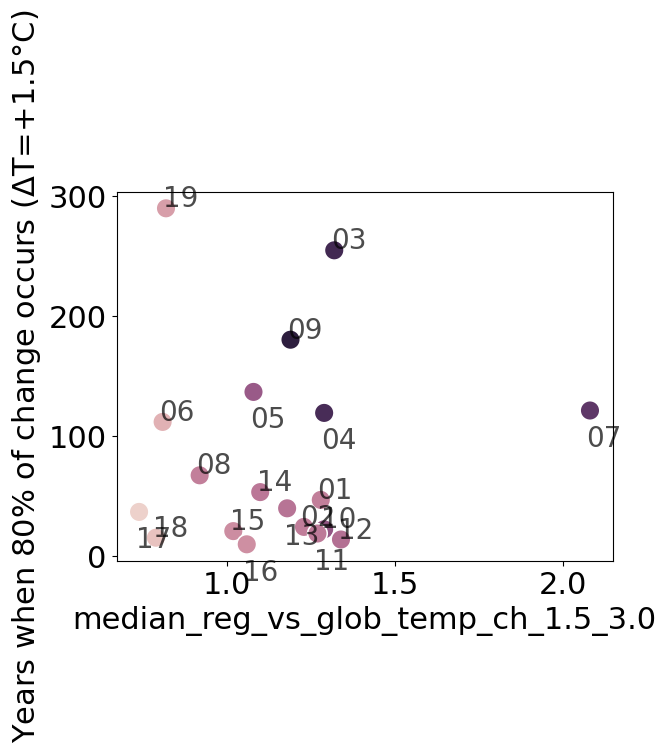

In [34]:
ax = plt.gca()
xx='median_reg_vs_glob_temp_ch_0.8_1.5'#'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-50%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,hue='median_reg_vs_glob_temp_ch_1.5_3.0',
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k],
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.98,0.01, f'spearmanr={corrcoef}', ha='right',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['05','04','11','07','16','13','17']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['05','04','11','07','16','13','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)
#ax.set_xlabel(f'Glacier surface slope\n(glacier-area weighted)')
#ax.set_ylabel(f'Latitude in absolute values\n(glacier-area weighted)')
ax.set_ylabel(r'Years when 80% of change occurs ($\Delta$T=+1.5°C)')
ax.set_xlabel('median_reg_vs_glob_temp_ch_1.5_3.0')

## Fig. 4

In [35]:
pd_lowess_ch['gt_2020_via_5yravg'] = pd_lowess_ch['regional_volume_m3_2020_via_5yravg']*10e-9 /900 #*10e-12
df['gt_2020_via_5yravg'] = df['regional_volume_m3_2020_via_5yravg']*10e-9 /900
_pd_lowess_ch = pd_lowess_ch.loc[pd_lowess_ch.region != 'Globally']
_df = df.loc[df.region!='Globally']

/tmp/ipykernel_2373868/1713729354.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values


ratio: 2.3548387096774195 slope: 2.7052343696186014
ratio: 1.7452054794520548 slope: 1.5546863180361026


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


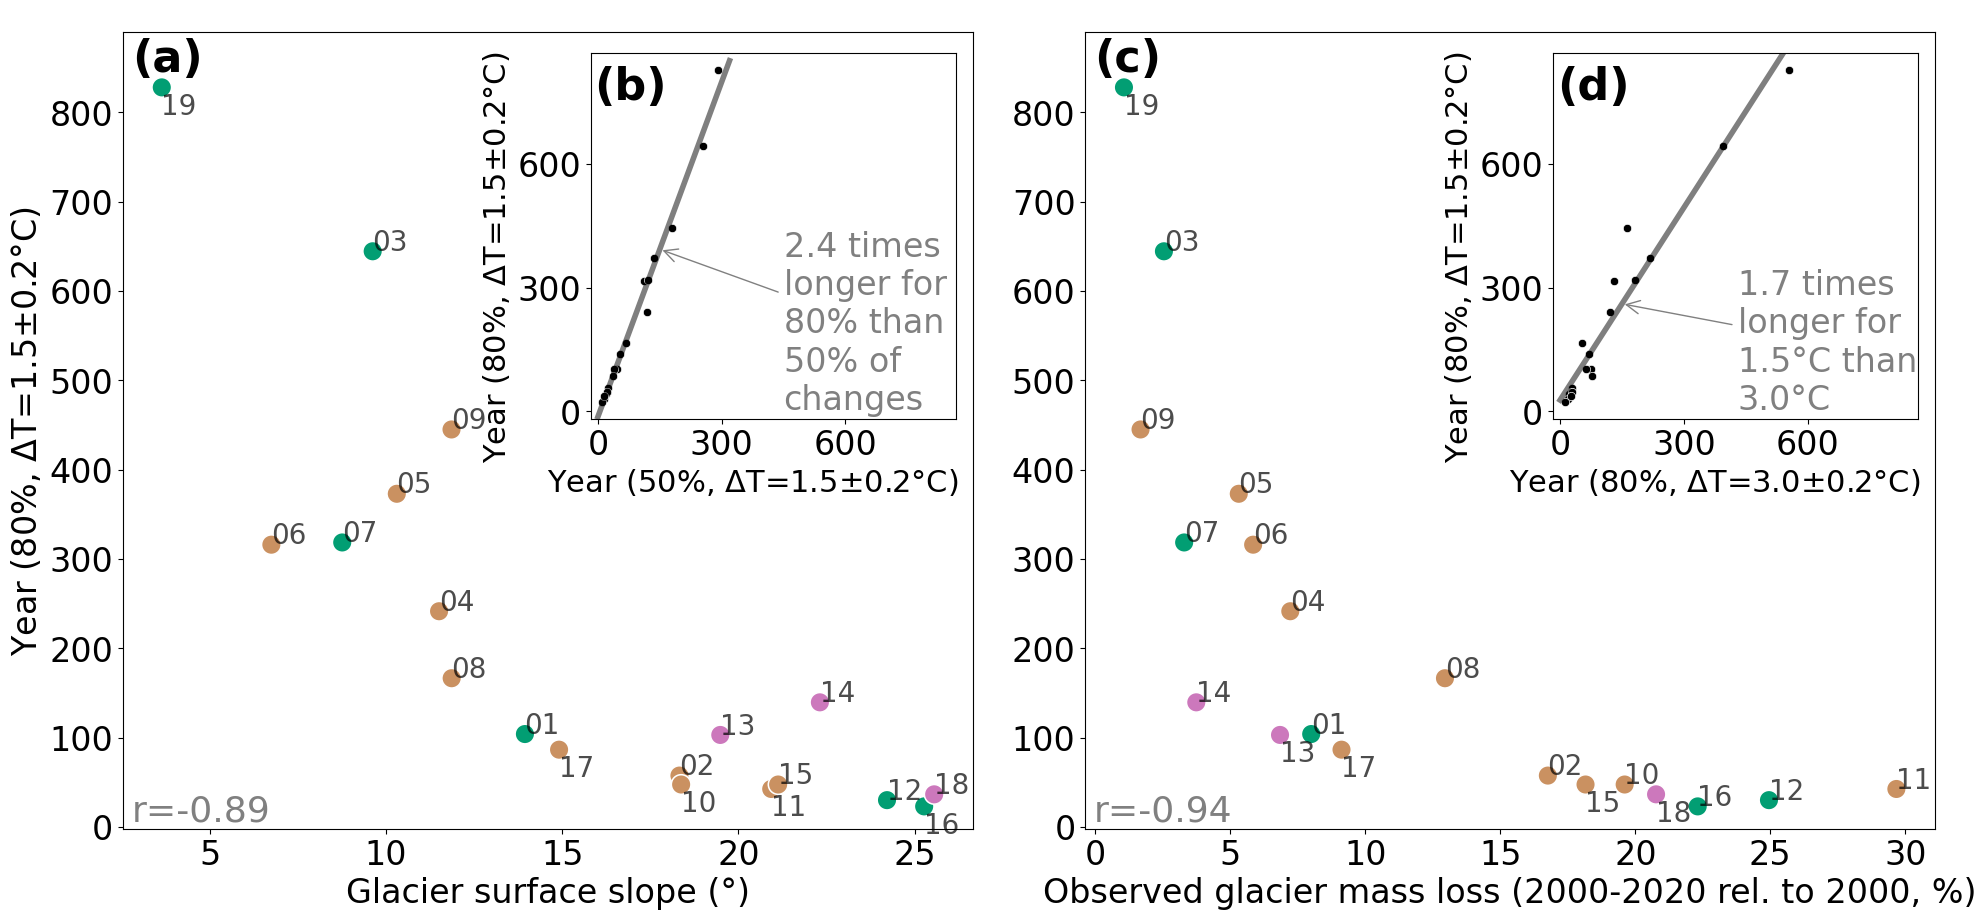

In [36]:
plt.rc('font', size=24)  

plt.figure(figsize=(20,9.5))

num_text_x = 0.01
num_text_y = 0.93
r=1
c=2
ax=plt.subplot(r,c,1)
ax=plt.gca()
yy2='resp_time_-80%_1_5_deg'
#ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
ylabel = f'Year (80%, $\Delta$T=1.5$\pm$0.2°C)'

xx2 = f'resp_time_-50%_1_5_deg'
#xlabel2 = r'Years when 50% of change occurs ($\Delta$T=+1.5°C)'
xlabel2 = f'Year (50%, $\Delta$T=1.5$\pm$0.2°C)'

xx=f'slope_weighted_area_avg' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                hue=f'kmeans_cluster_{k}{rel_add}',
                palette=palette_cb[:k], s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'r={corrcoef}', ha='left', #spearmanr
            transform=ax.transAxes, color='grey', fontsize=26)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
pd_lowess_ch.drop(['11','10','19','16','17']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['11','10','19','16','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel(ylabel)

ax.set_xlabel(f'Glacier surface slope (°)') #\n(regional glacier-area weighted average, in °)')

inset_ax = inset_axes(ax,
                    width="43%", # width = 30% of parent_bbox
                    height="47%", # height : 1 inch
                    loc='upper right',
                    #bbox_to_anchor=(1, 0.9, 0, 0),
                       )
#inset_ax.set_title(' t\n t', alpha =0)
sns.scatterplot(_df,y=yy2,x=xx2,ax=inset_ax, color='black')
inset_ax.set_xlabel(xlabel2+ '     ', fontsize=22) #'Year (50%)')
inset_ax.set_ylabel(ylabel + '     ', fontsize=22) #'Year (80%)') 
#_plotlabel=plotlabel, _plotlabel_b=plotlabel_b)
inset_ax.text(num_text_x, num_text_y*0.94,
         num_dict[1], weight='bold', fontsize=32, transform=inset_ax.transAxes)

#plt.text(0.99, 0.99,
#         'R²=0.96', fontsize=22, color='grey', va='top', ha='right',
#         transform=inset_ax.transAxes)
#plt.ylim([-2,840])
#inset_ax.grid(alpha=0.5)

inset_ax.set_aspect('equal')
ylim0,ylim1 = inset_ax.get_ylim()
xlim0,xlim1 = inset_ax.get_xlim()
lim0 = min(ylim0, xlim0)
lim1 = max(ylim1, xlim1)
inset_ax.set_xlim([lim0, lim1])
inset_ax.set_ylim([lim0, lim1])

inset_ax.set_xticks(np.arange(0,lim1,300))
inset_ax.set_yticks(np.arange(0,lim1,300))

#inset_ax.text(0.98,0.02,
#              f"{np.nanmedian(_df[yy2]/_df[xx2]).round(1)} times\nlonger for\n80% vs\n50% of\nchanges", 
#              fontsize=24,
#     transform=inset_ax.transAxes, ha='right', va='bottom', color='grey')
#inset_ax.plot([0, 1], [0, 1], color='lightgrey',ls='--',lw=2, transform=inset_ax.transAxes)

#############
slope, intercept, rval, pval, stderr = scipy.stats.linregress(_df[xx2].values,
                                                              _df[yy2])
ylim = inset_ax.get_ylim()
x_range = np.arange(0,_df[xx2].values.max()*1.1, 0.01)
inset_ax.plot(x_range,slope*x_range + intercept, 
              color = 'black', alpha = 0.5, lw=4)
ratio = np.nanmedian(_df[yy2].values/_df[xx2].values)
print('ratio:', ratio, 'slope:' , slope)
inset_ax.annotate(f"{ratio.round(1)} times\nlonger for\n80% than\n50% of\nchanges",
                  xy=(150,slope*150 + intercept),
                  xytext=(450,5),
                  fontsize = 24,
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='grey'),
                  color='grey') #, alpha1)
inset_ax.set_ylim(ylim)
#################


ax1=ax

##############################################
ax=plt.subplot(r,c,2)

yy2='resp_time_-80%_1_5_deg'
ylabel = f'Year (80%, $\Delta$T=1.5$\pm$0.2°C)'
#s when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
xx2 = f'resp_time_-80%_3_0_deg'

xx=f'20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                hue=f'kmeans_cluster_{k}{rel_add}',
                palette=palette_cb[:k], s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'r={corrcoef}', ha='left', #spearmanr
            transform=ax.transAxes, color='grey', fontsize=26)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
#pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
#pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.drop(['19','17','18','15','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['19','17','18','15','13']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel(ylabel)

ax.set_xlabel(f'Observed glacier mass loss (2000-2020 rel. to 2000, %)')

inset_ax = inset_axes(ax,
                    width="43%", # width = 30% of parent_bbox
                    height="47%", # height : 1 inch
                    loc='upper right',
                    #bbox_to_anchor=(1, 0.9, 0, 0),
                       )
#inset_ax.set_title(' t\n t', alpha =0)
sns.scatterplot(_df,y=yy2,x=xx2,ax=inset_ax, color='black')
inset_ax.set_xlabel(r'Year (80%, $\Delta$T=3.0$\pm$0.2°C)'+ '     ', fontsize=22)#, fontsize=20)
inset_ax.set_ylabel(r'Year (80%, $\Delta$T=1.5$\pm$0.2°C)' + '     ', fontsize=22)#, fontsize=20) 
inset_ax.text(num_text_x, num_text_y*0.94,
         num_dict[3], weight='bold',fontsize=32, transform=inset_ax.transAxes)
#_plotlabel=plotlabel, _plotlabel_b=plotlabel_b)
#inset_ax.text(num_text_x, num_text_y*0.9,
#         num_dict[4], fontsize=26, transform=inset_ax.transAxes)

#plt.text(0.99, 0.99,
#         'R²=0.96',
#         fontsize=22, color='grey', va='top', ha='right',
#         transform=inset_ax.transAxes)
#plt.ylim([-2,840])
#inset_ax.grid(alpha=0.5)

inset_ax.set_aspect('equal')
ylim0,ylim1 = inset_ax.get_ylim()
xlim0,xlim1 = inset_ax.get_xlim()
lim0 = min(ylim0, xlim0)
lim1 = max(ylim1, xlim1)
inset_ax.set_xlim([lim0, lim1])
inset_ax.set_ylim([lim0, lim1])

inset_ax.set_xticks(np.arange(0,lim1,300))
inset_ax.set_yticks(np.arange(0,lim1,300))
#inset_ax.text(0.98,0.02, 
#              f"{np.nanmedian(_df[yy2]/_df[xx2]).round(1)} times\nlonger for\n1.5°C vs\n3.0°C", fontsize=24,
# transform=inset_ax.transAxes, ha='right', va='bottom', color='grey')
#inset_ax.plot([0, 1], [0, 1], color='lightgrey',ls='--',lw=2, transform=inset_ax.transAxes)
slope, intercept, rval, pval, stderr = scipy.stats.linregress(_df[xx2].values,
                                                              _df[yy2])
ylim = inset_ax.get_ylim()
x_range = np.arange(0,_df[xx2].values.max()*1.1, 0.01)
inset_ax.plot(x_range,slope*x_range + intercept, 
              color = 'black', alpha = 0.5, lw=4)
ratio = np.nanmedian(_df[yy2].values/_df[xx2].values)
print('ratio:', ratio, 'slope:' , slope)
inset_ax.annotate(f"{ratio.round(1)} times\nlonger for\n1.5°C than\n3.0°C", 
                  #times\nlonger for\n80% vs\n50% of\nchanges",
                  xy=(150,slope*150 + intercept),
                  xytext=(430,5),
                  fontsize = 24,
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='grey'),
                  color='grey') #, alpha1)
inset_ax.set_ylim(ylim)


ax2=ax
num_text_x = 0.01
for j,axi in enumerate([ax1, ax2]):
    num_text_y = 0.95
    axi.text(num_text_x, num_text_y,
             num_dict[j*2], fontsize=32, weight='bold',transform=axi.transAxes)
    axi.set_ylim([-2,890])
    if j == 1:
        axi.set_ylabel('')
        #axi.set_yticklabels([]) 
    #if j<3:
    #    axi.set_ylim(ax1.get_ylim())
plt.tight_layout()
plt.savefig(f'figures/fig4_{DATE}.png')
plt.savefig(f'figures/fig4_{DATE}.pdf')

/tmp/ipykernel_2373868/4078377888.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


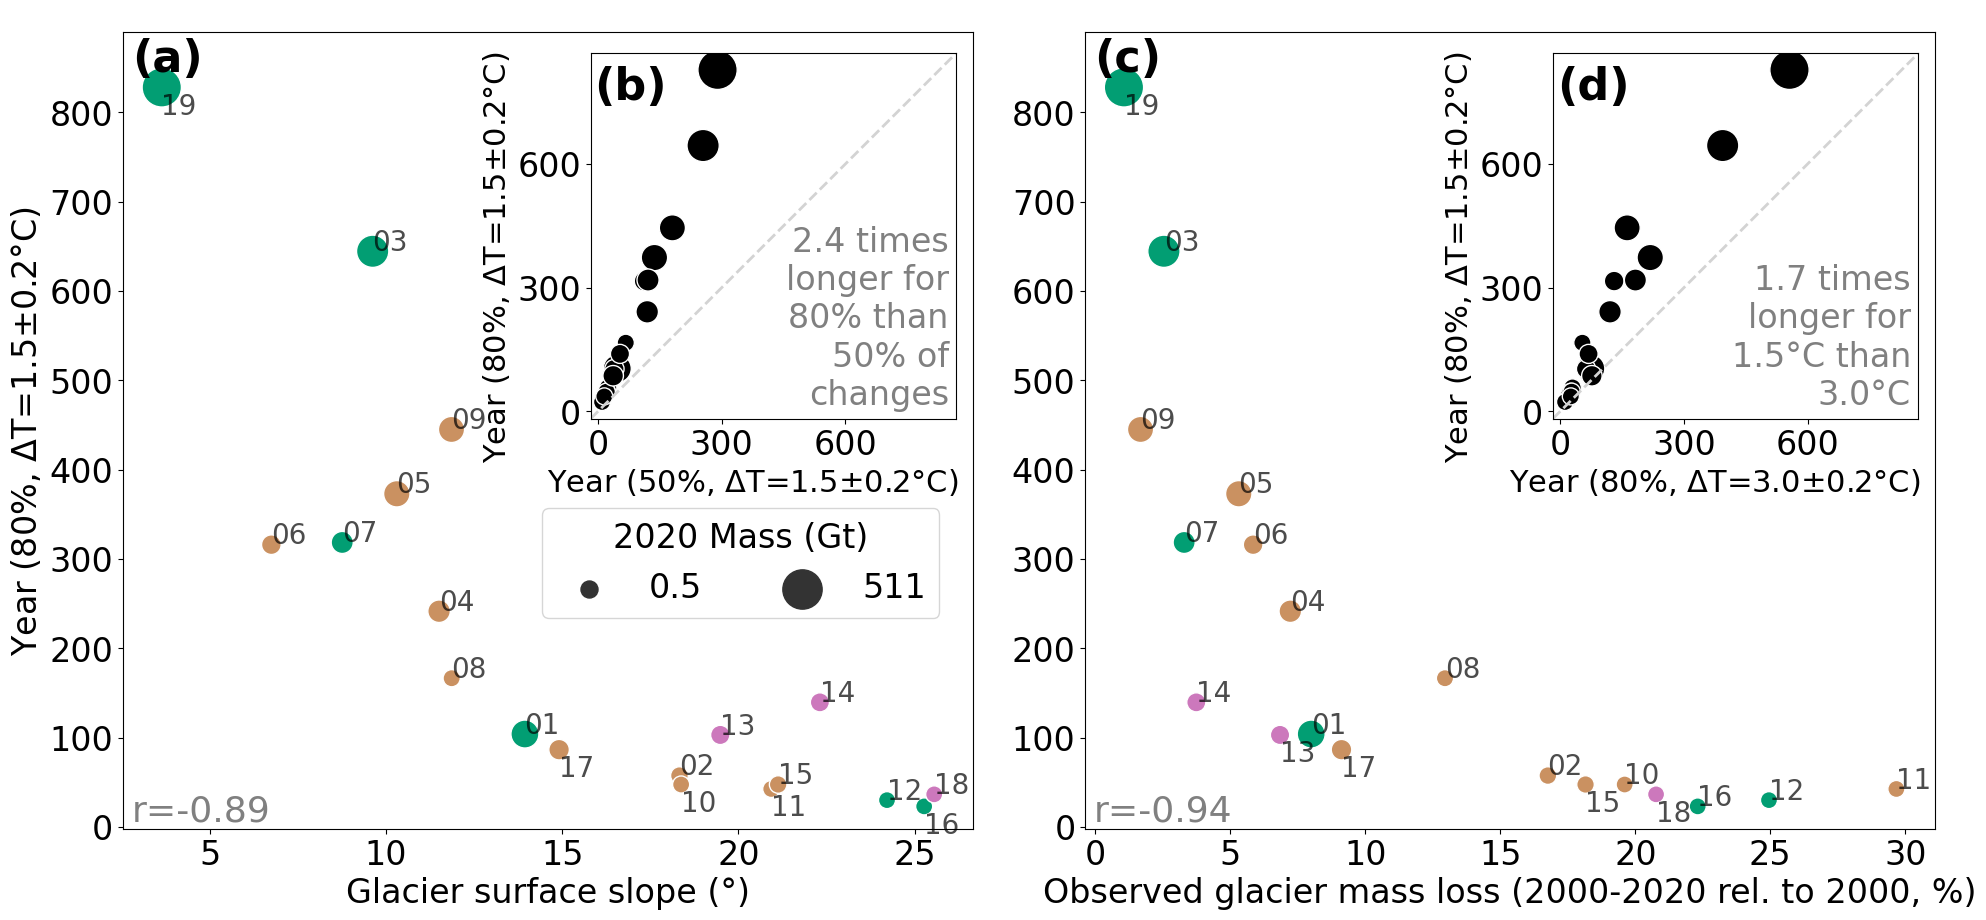

In [37]:
plt.rc('font', size=24)  
sizes = (150,800)
plt.figure(figsize=(20,9.5))

num_text_x = 0.01
num_text_y = 0.93
r=1
c=2
ax=plt.subplot(r,c,1)
ax=plt.gca()
yy2='resp_time_-80%_1_5_deg'
#ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
ylabel = f'Year (80%, $\Delta$T=1.5$\pm$0.2°C)'

xx2 = f'resp_time_-50%_1_5_deg'
#xlabel2 = r'Years when 50% of change occurs ($\Delta$T=+1.5°C)'
xlabel2 = f'Year (50%, $\Delta$T=1.5$\pm$0.2°C)'

xx=f'slope_weighted_area_avg' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=_pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                hue=f'kmeans_cluster_{k}{rel_add}',
                palette=palette_cb[:k], #s=200,
                size = 'gt_2020_via_5yravg',
                sizes=sizes,
                legend = False)
print_spearman = True
corrcoef,pval = spearmanr(_pd_lowess_ch[[xx,yy]].dropna()[xx].values,
                          _pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'r={corrcoef}', ha='left', #spearmanr
            transform=ax.transAxes, color='grey', fontsize=26)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
_pd_lowess_ch.drop(['11','10','19','16','17']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
_pd_lowess_ch.loc[['11','10','19','16','17']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel(ylabel)

ax.set_xlabel(f'Glacier surface slope (°)') #\n(regional glacier-area weighted average, in °)')

inset_ax = inset_axes(ax,
                    width="43%", # width = 30% of parent_bbox
                    height="47%", # height : 1 inch
                    loc='upper right',
                    #bbox_to_anchor=(1, 0.9, 0, 0),
                     )
#inset_ax.set_title(' t\n t', alpha =0)
sns.scatterplot(df.loc[df.region !='Globally'],y=yy2,x=xx2,ax=inset_ax, color='black',
                sizes=sizes,size = 'gt_2020_via_5yravg',legend='full')
inset_ax.set_xlabel(xlabel2+ '     ',fontsize=22) #'Year (50%)')
inset_ax.set_ylabel(ylabel + '     ',fontsize=22) #'Year (80%)') 
#_plotlabel=plotlabel, _plotlabel_b=plotlabel_b)
inset_ax.text(num_text_x, num_text_y*0.94,
         num_dict[1], weight='bold', fontsize=32, transform=inset_ax.transAxes)

#plt.text(0.99, 0.99,
#         'R²=0.96', fontsize=22, color='grey', va='top', ha='right',
#         transform=inset_ax.transAxes)
#plt.ylim([-2,840])
#inset_ax.grid(alpha=0.5)
handles, labels = inset_ax.get_legend_handles_labels()
inset_ax.legend([handles[0],handles[-1]], [np.round(float(labels[0]),1),
                                           np.round(float(labels[-1]),0).astype(int)],
                title='2020 Mass (Gt)',
                bbox_to_anchor = (1, -0.2), ncol=2, loc='upper right')

inset_ax.set_aspect('equal')
ylim0,ylim1 = inset_ax.get_ylim()
xlim0,xlim1 = inset_ax.get_xlim()
lim0 = min(ylim0, xlim0)
lim1 = max(ylim1, xlim1)
inset_ax.set_xlim([lim0, lim1])
inset_ax.set_ylim([lim0, lim1])

inset_ax.set_xticks(np.arange(0,lim1,300))
inset_ax.set_yticks(np.arange(0,lim1,300))

inset_ax.text(0.98,0.02,
              f"{np.nanmedian(df.loc[df.region !='Globally'][yy2]/df.loc[df.region !='Globally'][xx2]).round(1)} times\nlonger for\n80% than\n50% of\nchanges", 
              fontsize=24,
     transform=inset_ax.transAxes, ha='right', va='bottom', color='grey')
inset_ax.plot([0, 1], [0, 1], color='lightgrey',ls='--',lw=2, transform=inset_ax.transAxes)
ax1=ax

##############################################
ax=plt.subplot(r,c,2)

yy2='resp_time_-80%_1_5_deg'
ylabel = f'Year (80%, $\Delta$T=1.5$\pm$0.2°C)'
#s when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'
xx2 = f'resp_time_-80%_3_0_deg'

xx=f'20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=_pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                hue=f'kmeans_cluster_{k}{rel_add}',
                palette=palette_cb[:k], #s=200
                size = 'gt_2020_via_5yravg',
                sizes=sizes,
                legend = False)
print_spearman = True
corrcoef,pval = spearmanr(_pd_lowess_ch[[xx,yy]].dropna()[xx].values,
                          _pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'r={corrcoef}', ha='left', #spearmanr
            transform=ax.transAxes, color='grey', fontsize=26)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
#pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
#pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
_pd_lowess_ch.drop(['19','17','18','15','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
_pd_lowess_ch.loc[['19','17','18','15','13']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel(ylabel)

ax.set_xlabel(f'Observed glacier mass loss (2000-2020 rel. to 2000, %)')

inset_ax = inset_axes(ax,
                    width="43%", # width = 30% of parent_bbox
                    height="47%", # height : 1 inch
                    loc='upper right'
                    #bbox_to_anchor=(1, 0.9, 0, 0),
                       )
#inset_ax.set_title(' t\n t', alpha =0)
sns.scatterplot(df.loc[df.region !='Globally'],y=yy2,x=xx2,ax=inset_ax, color='black',
                size = 'gt_2020_via_5yravg',
                sizes=sizes
               )
inset_ax.set_xlabel(r'Year (80%, $\Delta$T=3.0$\pm$0.2°C)'+ '     ',fontsize=22)#, fontsize=20)
inset_ax.set_ylabel(r'Year (80%, $\Delta$T=1.5$\pm$0.2°C)' + '     ',fontsize=22)#, fontsize=20) 
inset_ax.text(num_text_x, num_text_y*0.94,
         num_dict[3], weight='bold',fontsize=32, transform=inset_ax.transAxes)
#_plotlabel=plotlabel, _plotlabel_b=plotlabel_b)
#inset_ax.text(num_text_x, num_text_y*0.9,
#         num_dict[4], fontsize=26, transform=inset_ax.transAxes)

#plt.text(0.99, 0.99,
#         'R²=0.96',
#         fontsize=22, color='grey', va='top', ha='right',
#         transform=inset_ax.transAxes)
#plt.ylim([-2,840])
#inset_ax.grid(alpha=0.5)

inset_ax.set_aspect('equal')
ylim0,ylim1 = inset_ax.get_ylim()
xlim0,xlim1 = inset_ax.get_xlim()
lim0 = min(ylim0, xlim0)
lim1 = max(ylim1, xlim1)
inset_ax.set_xlim([lim0, lim1])
inset_ax.set_ylim([lim0, lim1])

inset_ax.set_xticks(np.arange(0,lim1,300))
inset_ax.set_yticks(np.arange(0,lim1,300))
inset_ax.text(0.98,0.02, 
              f"{np.nanmedian(df.loc[df.region !='Globally'][yy2]/df.loc[df.region !='Globally'][xx2]).round(1)} times\nlonger for\n1.5°C than\n3.0°C", fontsize=24,
 transform=inset_ax.transAxes, ha='right', va='bottom', color='grey')
inset_ax.plot([0, 1], [0, 1], color='lightgrey',ls='--',lw=2, transform=inset_ax.transAxes)
inset_ax.get_legend().remove()

ax2=ax
num_text_x = 0.01
for j,axi in enumerate([ax1, ax2]):
    num_text_y = 0.95
    axi.text(num_text_x, num_text_y,
             num_dict[j*2], fontsize=32, weight='bold',transform=axi.transAxes)
    axi.set_ylim([-2,890])
    if j == 1:
        axi.set_ylabel('')
        #axi.set_yticklabels([]) 
    #if j<3:
    #    axi.set_ylim(ax1.get_ylim())
plt.tight_layout()
plt.savefig(f'figures/fig4_{DATE}_scaled_2020_glacier_mass.png')
plt.savefig(f'figures/fig4_{DATE}_scaled_2020_glacier_mass.pdf')

<AxesSubplot:xlabel='20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%', ylabel='resp_time_-80%_1_5_deg'>

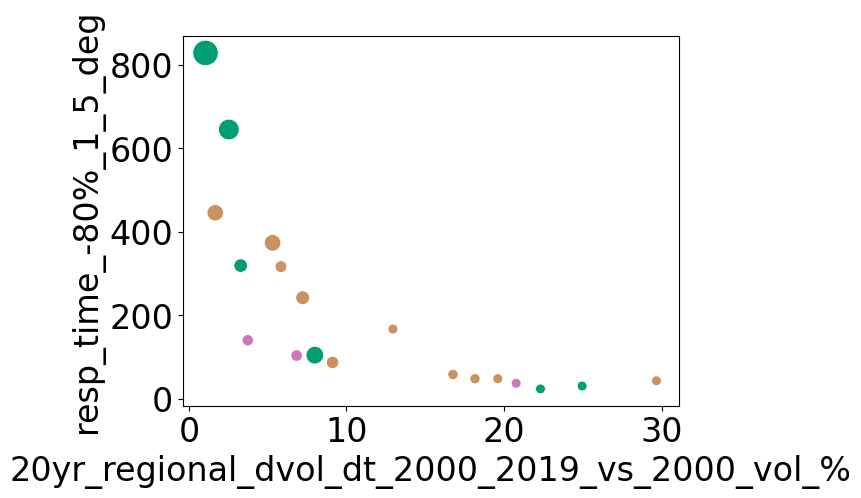

In [38]:
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                hue=f'kmeans_cluster_{k}{rel_add}',
                palette=palette_cb[:k],# s=200,
                size = 'regional_volume_m3_2020_via_5yravg',
                sizes=(50,1000),
                legend = False)

(-2.0, 850.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


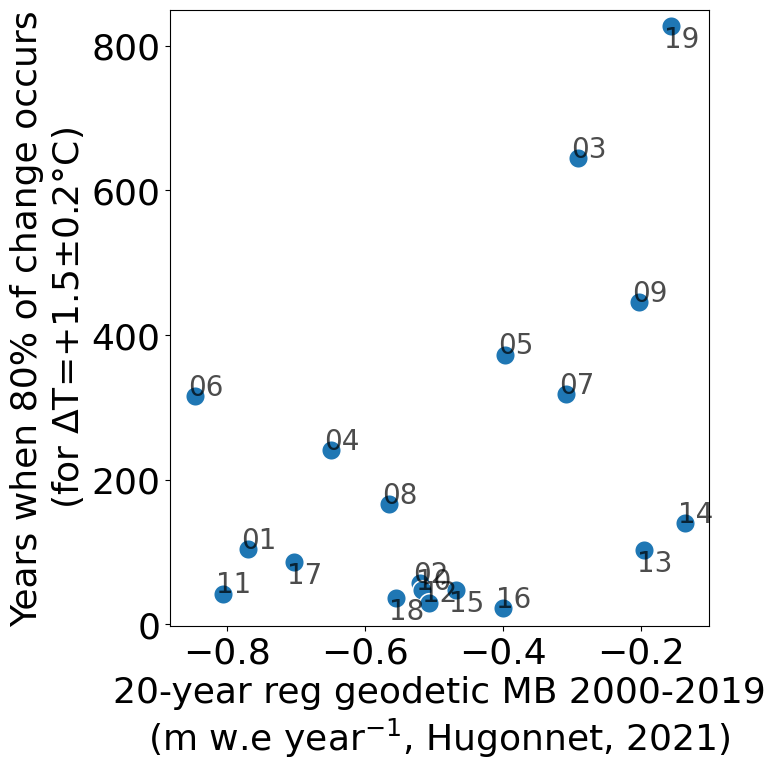

In [66]:
plt.figure(figsize=(32,8))
r=1
c=4
ax=plt.subplot(r,c,1)
num_text_x = 0.01
num_text_y = 0.95


ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'

xlabel=f'20-year reg geodetic MB 2000-2019\n'+r'(m w.e '+r'year$^{-1}$, Hugonnet, 2021)' #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
xx = 'geodetic_obs_area_weighted'
yy = 'resp_time_-80%_1_5_deg'
sns.scatterplot(data=pd_lowess_ch,
                y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                x=xx,
                #hue=f'kmeans_cluster_{k}{rel_add}',
                #palette=palette_cb[:k], 
                s=200, legend = False)
print_spearman = True
corrcoef,pval = spearmanr(pd_lowess_ch[[xx,yy]].dropna()[xx].values, pd_lowess_ch[[xx,yy]].dropna()[yy].values)
corrcoef = corrcoef.round(2)
if (pval <0.05) and print_spearman:
    ax.text(0.01,0.01, f'spearmanr={corrcoef}', ha='left',
            transform=ax.transAxes, color='grey', fontsize=22)
#pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
#pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
#pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.drop(['19','17','18','15','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_lowess_ch.loc[['19','17','18','15','13']].apply(lambda x: plotlabel_bb(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel(ylabel)

ax.set_xlabel(f'{xlabel}')


plt.ylim([-2,850])

In [67]:
pd_lowess_ch.columns

Index(['ice_loss_1.2°C_%_rel_2020_only_global_models',
       'ice_loss_2.7°C_%_rel_2020_only_global_models',
       'ice_loss_1.5°C_%_rel_2020_only_global_models',
       'ice_loss_2.0°C_%_rel_2020_only_global_models',
       'ice_loss_3.0°C_%_rel_2020_only_global_models',
       'ice_loss_slope_between_1.0_and_2.5_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.1_and_2.6_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.2_and_2.7_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.3_and_2.8_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.4_and_2.9_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.6_and_3.1_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.7_and_3.2_per_degC_rel_2020_only_global_models',
       'ice_loss_slope_between_1.8_and_3.3_per_degC_rel_2020_only_glo

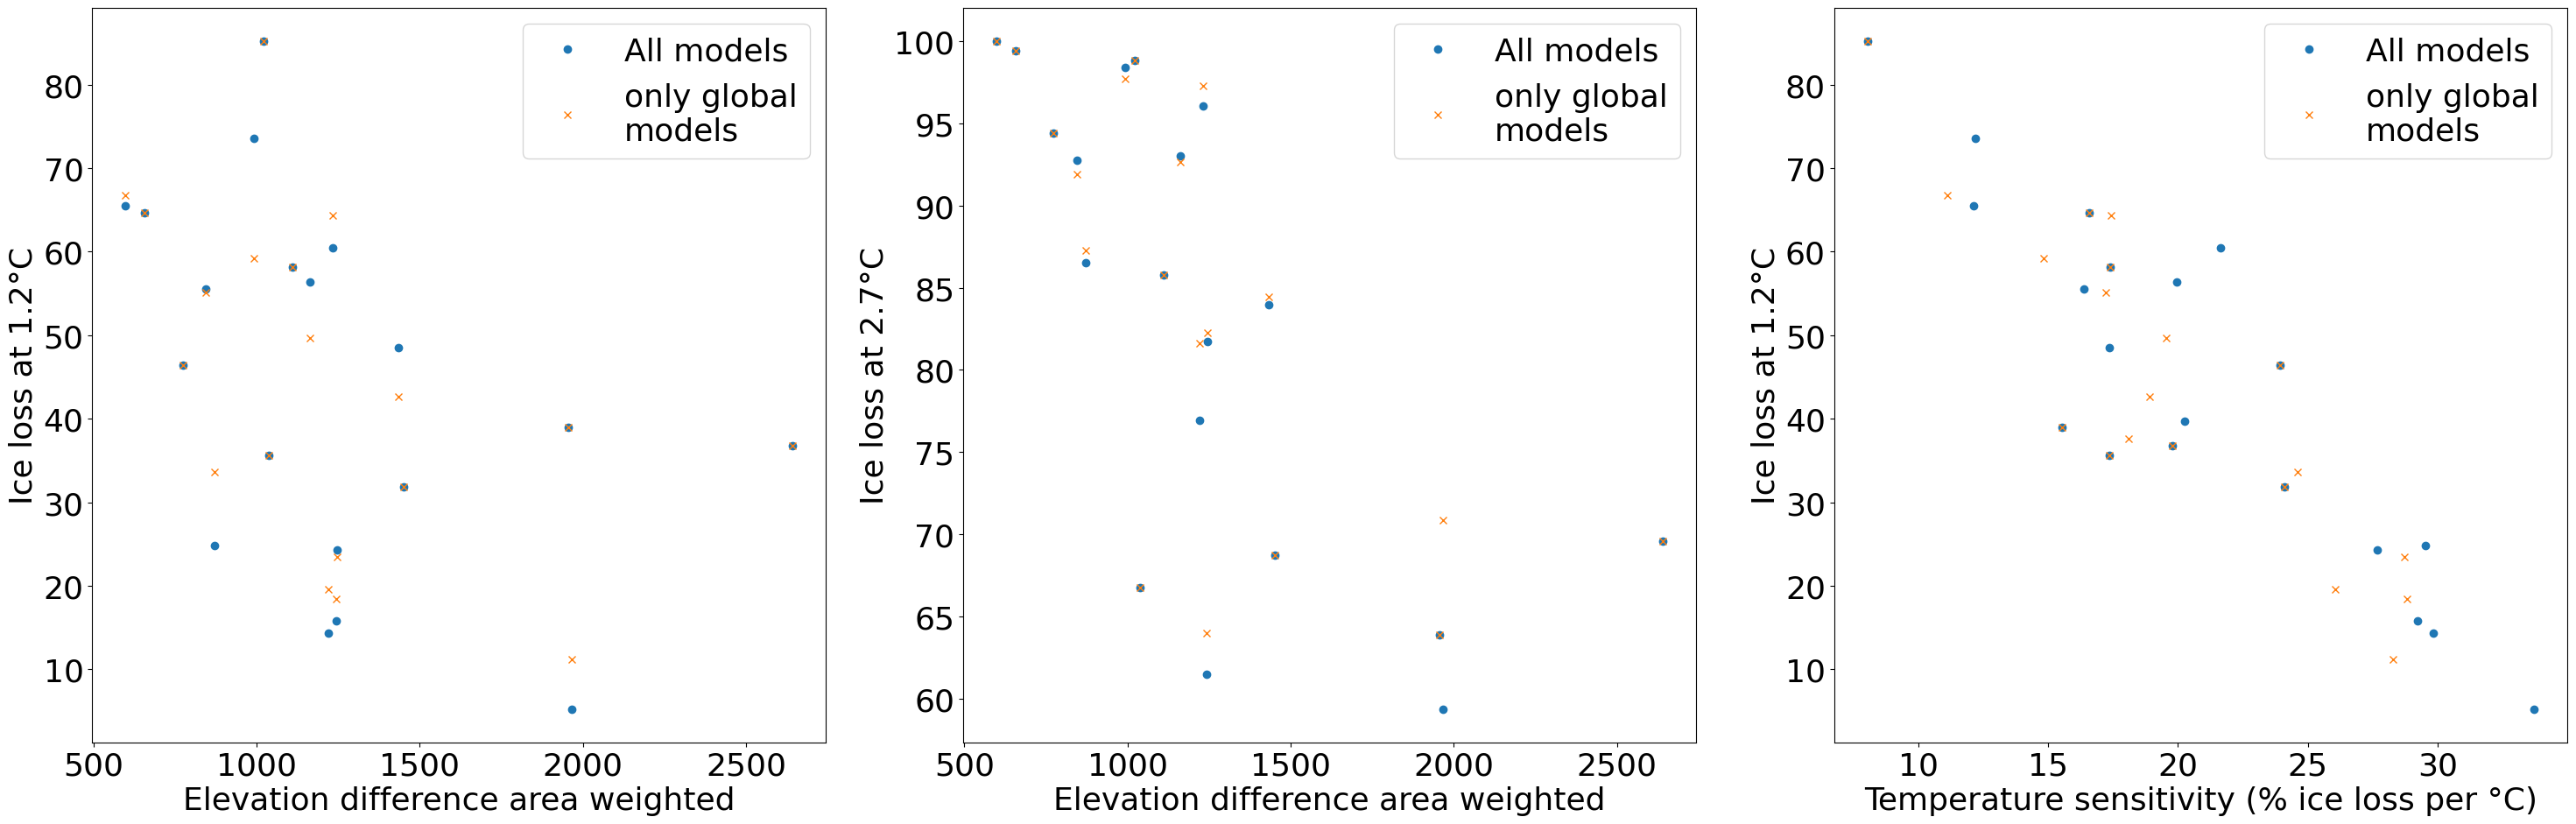

In [68]:
perc = '80'
plt.figure(figsize=(30,10))
for j, temp in zip([1,2],['1.2','2.7']):
    plt.subplot(1,3,j)
    plt.plot(pd_lowess_ch.elev_diff_area_weighted,
             pd_lowess_ch[f'ice_loss_{temp}°C_%_rel_2020'], 'o', label='All models')
    plt.plot(pd_lowess_ch.elev_diff_area_weighted,
             pd_lowess_ch[f'ice_loss_{temp}°C_%_rel_2020_only_global_models'], 'x', label='only global\nmodels')
    plt.legend()

    plt.ylabel(f'Ice loss at {temp}°C')
    plt.xlabel('Elevation difference area weighted')
    #print(temp, pd_lowess_ch[['elev_diff_area_weighted',
    #              f'ice_loss_{temp}°C_%_rel_2020',
    #              f'ice_loss_{temp}°C_%_rel_2020_only_global_models']])
    plt.legend(loc = 'upper right')

j = 3
temp = '1.2'
plt.subplot(1,3,j)
plt.plot( pd_lowess_ch['ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020'], 
         pd_lowess_ch[f'ice_loss_{temp}°C_%_rel_2020'],
         'o', label='All models')
plt.plot(pd_lowess_ch['ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020_only_global_models'], 
         pd_lowess_ch[f'ice_loss_{temp}°C_%_rel_2020_only_global_models'],
         'x', label='only global\nmodels')
plt.legend()

plt.xlabel(f'Temperature sensitivity (% ice loss per °C)')
plt.ylabel(f'Ice loss at {temp}°C')
#print(temp, pd_lowess_ch[['elev_diff_area_weighted',
#              f'ice_loss_{temp}°C_%_rel_2020',
#              f'ice_loss_{temp}°C_%_rel_2020_only_global_models']])
plt.legend(loc = 'upper right')
plt.tight_layout()

### Additional correlation analysis

In [69]:
df.loc[df.region == pd_lowess_ch.index.values, 'ice_loss_1.2°C_%_rel_2020'] =  pd_lowess_ch['ice_loss_1.2°C_%_rel_2020'].values
df.loc[df.region == pd_lowess_ch.index.values, 'ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020'] =  pd_lowess_ch['ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020'].values
df.loc[df.region == pd_lowess_ch.index.values, 'kmeans_cluster_3_rel_2020'] = pd_lowess_ch['kmeans_cluster_3_rel_2020']

In [78]:
#'regional_volume_m3_itmix_vs_2020',
# 'regional_dvol_dt_2000_2019_vs_2020_vol',
       #'kmeans_cluster_3_rel_2020'
                    #'yr_diff_rgi_vs_2020', 
#'mean_len_ten_largest_glac',
        #'rgi_year_weighted_median',
       #  'elev_diff_to_med_area_weighted', don not use that because we don't have that for RGI19 !!!
#'lat_weighted_area_avg', 
#'geodetic_obs_area_weighted',
#'lat_weighted_area_avg', 
        #'slope_weighted_vol_avg',
#'temp_avg_1981-2000', 
#         'prcp_avg_1981-2000',
#'continentality_index_avg_1981-2000',
       # 'temp_avg_1995-2014',
#'prcp_avg_1995-2014',
        #'continentality_index_avg_1995-2014',
#'temp_ch_avg_1986-2005_vs_1901-1920',
#'temp_ch_avg_1995-2014_vs_1901-1920', 
columns_sel3_d = {
    #'rgi_reg': 'rgi_reg',
    #'region': 'region',
    ####### climate indices 
    'temp_ch_avg_2000-2019_vs_1901-1920': 'ΔTemp 2000-2019 - 1901-1920 (reg-aw)',
    'temp_avg_2000-2019': 'Temp 2000-2019 (reg-aw)',
    'prcp_avg_2000-2019': 'Prcp 2000-2019 (reg-aw)',
    'continentality_index_avg_2000-2019': 'Continentality index 2000-2019 (reg-aw)',
    #'median_reg_vs_glob_ch': '',
    #'median_reg_vs_glob_temp_ch_above_zero_eight_deg': ,
    #'median_reg_vs_glob_temp_ch_0.8_1.5': '',
    'median_reg_vs_glob_temp_ch_1.5_3.0': 'Ratio reg vs global ΔTemp (median, reg-aw)',
    'median_reg_vs_glob_temp_ch_1.5_3.0': 'Ratio reg vs global ΔTemp (1.5-3.0°C, median, reg-aw)',
    #'slope_fit_reg_vs_glob_ch': 'Fitted slope regional vs global temp change (aw)',
    
    ##### glacier topography ... 
    'slope_weighted_area_avg': 'Glacier surface slope (reg-aw)',
    'lat_absolute_weighted_area_avg': 'Latitude (absolute, reg-aw)',
    'mean_vol_ten_largest_glac': 'Mean mass (10 largest)',
    'mean_area_ten_largest_glac': 'Mean area (10 largest)',
    'elev_diff_area_weighted': 'Elevation range (reg-aw)',
    'max_elev_area_weighted': 'Maximum elevation (reg-aw)',
    'min_elev_area_weighted': 'Minimum elevation (reg-aw)',
    'ice_cap_ratio_hundredlargest_glac': 'Ratio ice caps (100 largest)',
    'marine_term_ratio_hundredlargest_glac': 'Ratio marine-terminating (100 largest)',
    #'regional_volume_m3_itmix': 'Reg volume (inventory date)',
    f'regional_volume_m3_2020{approach}': 'Mass (2020, reg)', # mass and volume are directly linked.. 

    # glacier changes in the past
    'geodetic_obs_area_weighted':'Observed geodetic MB (2000-2019, reg)',# (Hugonnet, 2021)',
    'dvoldt_m3_hugonnet': 'Observed ΔMassΔt (2000-2019, reg)', # (Hugonnet, 2021)',
    '20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%': 'Observed ΔMassΔt (2000-2019 rel. 2000 Mass, reg)',
    #'20yr_regional_dvol_dt_2000_2019_vs_farinotti_vol_%': '20-year reg dVoldt 2000-2019 rel. to Volume inventory date',
    
    # glacier simulation changes from GMIP3 
    'resp_time_-50%_1_5_deg': 'Response time scale (~1.5°C, 50%, reg)',
    'resp_time_-50%_3_0_deg': 'Response time scale (~3.0°C, 50%, reg)', #'Time to reach 50% of changes (~3.0°C, reg)',
    'resp_time_-80%_1_5_deg': 'Response time scale (~1.5°C, 80%, reg)', #'Time to reach 80% of changes (~1.5°C, reg)',
    'resp_time_-80%_3_0_deg': 'Response time scale (~3.0°C, 80%, reg)', #'Time to reach 80% of changes (~3.0°C, reg)',
    'ice_loss_1.2°C_%_rel_2020': 'Committed ice loss at 1.2°C (rel. 2020, reg)',
    'ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020': 'Committed ice loss sensitivity (1.5-3.0°C, rel. 2020, reg)'
}
columns_sel3 = columns_sel3_d.keys()

- (10/100 largest) : 10/100 glaciers with the largest initial ice volume according to Farinotti et al. (2019) at inventory date
- (aw) : glacier-area weighted
- (reg) : regional 
- (avg) : averaged

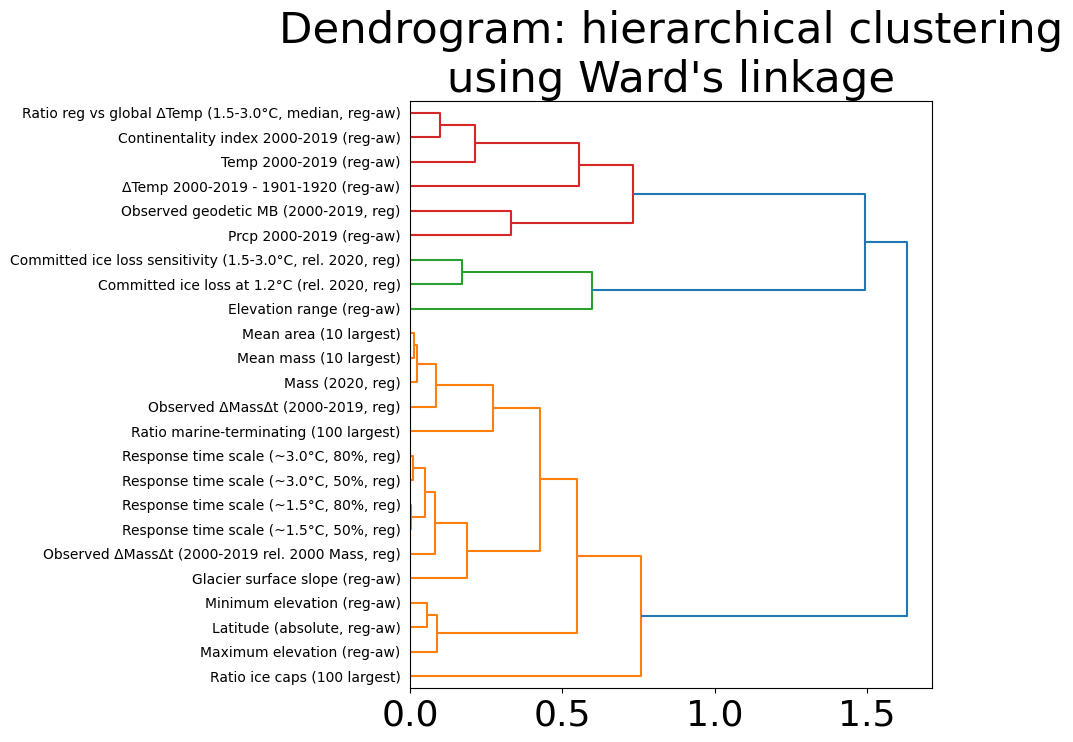

In [79]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
X = df.iloc[1:].reset_index(drop=True)[columns_sel3]
assert list(X.columns) == list(columns_sel3)
X.columns = columns_sel3_d.values()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
corr = spearmanr(X).correlation
# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=0,
    orientation='right'
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.title("Dendrogram: hierarchical clustering\nusing Ward's linkage")
#ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
#ax2.set_xticks(dendro_idx)
#ax2.set_yticks(dendro_idx)
#ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
#ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
#labels_y = plt.gca().get_yticklabels()
#plt.gca().set_yticklabels(list(columns_sel3_d.values()));

In [80]:
df_sel

ΔTemp 2000-2019 - 1901-1920 (reg-aw)  Temp 2000-2019 (reg-aw)  \
0                               1.407024                -2.680121   
1                               0.938350                 1.370370   
2                               1.649075               -20.251422   
3                               0.628456               -14.432082   
4                               1.230881               -11.933206   
5                               1.073999                 1.129139   
6                               2.822036                -6.555115   
7                               1.052981                 1.092181   
8                               2.688917               -13.099857   
9                               1.582658                -7.758692   
10                              1.649266                 3.058256   
11                              1.003902                 0.688994   
12                              1.492022                -2.908241   
13                              1.389264                -0.426944   
14                              0.927204                 1.753418   
15                              0.144473                 8.462619   
16                              0.285005                 4.129698   
17                              0.771237                 6.006265   
18                              1.647942               -10.332511   

    Prcp 2000-2019 (reg-aw)  Continentality index 2000-2019 (reg-aw)  \
0                  0.000056                                23.794284   
1                  0.000039                                20.412361   
2                  0.000006                                38.827306   
3                  0.000010                                34.784294   
4                  0.000017                                25.983983   
5                  0.000071                                12.656961   
6                  0.000017                                21.640271   
7                  0.000050                                20.599184   
8                  0.000010                                35.773139   
9                  0.000016                                36.612317   
10                 0.000044                                17.829911   
11                 0.000038                                28.175153   
12                 0.000011                                25.175861   
13                 0.000014                                22.908715   
14                 0.000039                                16.363597   
15                 0.000036                                 3.241020   
16                 0.000027                                 9.978729   
17                 0.000099                                11.349775   
18                 0.000026                                16.928435   

    Ratio reg vs global ΔTemp (1.5-3.0°C, median, reg-aw)  \
0                                                1.18       
1                                                1.19       
2                                                1.74       
3                                                1.72       
4                                                1.39       
5                                                0.94       
6                                                1.63       
7                                                1.18       
8                                                1.83       
9                                                1.41       
10                                               1.21       
11                                               1.26       
12                                               1.24       
13                                               1.22       
14                                               1.11       
15                                               1.10       
16                                               0.79       
17                                               0.86       
18                     

In [81]:
        a, p_value = spearmanr(df_sel[col1], df_sel[col2])


In [82]:
df_sel[col2]

0     19.795132
1     12.200880
2     24.088463
3      8.044537
4     17.398617
5     21.640931
6     23.943141
7     12.142804
8     16.570182
9     16.364812
10    19.963581
11    27.664937
12    29.834266
13    33.700040
14    17.372565
15    29.512387
16    15.534379
17    29.227063
18    17.350523
Name: Committed glacier mass loss sensitivity (1.5-3.0°C, rel. 2020, reg), dtype: float64

In [83]:
df_sel[col1]

0     19.795132
1     12.200880
2     24.088463
3      8.044537
4     17.398617
5     21.640931
6     23.943141
7     12.142804
8     16.570182
9     16.364812
10    19.963581
11    27.664937
12    29.834266
13    33.700040
14    17.372565
15    29.512387
16    15.534379
17    29.227063
18    17.350523
Name: Committed glacier mass loss sensitivity (1.5-3.0°C, rel. 2020, reg), dtype: float64

In [ ]:
#Correlation between different variables
#
plt.rc('font', size=26)  

df_sel = df.loc[df.rgi_reg !='All'].reset_index(drop=True)[columns_sel3].copy()

assert list(df_sel.columns) == list(columns_sel3)
# ok, let's rename it to nice names
df_sel.columns = columns_sel3_d.values()

corr = df_sel.corr(method='spearman') # df_sel.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(45, 30))
#
plt.title('spearman rank\ncorrelation coefficient (r)')
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
# Create an empty matrix to store p-values
num_cols = len(df_sel.columns)
p_values = np.zeros((num_cols, num_cols))

# Calculate p-values for each pair of columns
for i, col1 in enumerate(df_sel.columns):
    for j, col2 in enumerate(df_sel.columns):
        a, p_value = spearmanr(df_sel[col1], df_sel[col2])
        #print(a,p_value, i,j)
        p_values[i][j] = p_value

# Convert the matrix to a DataFrame for better visualization
p_values_df = pd.DataFrame(p_values, columns=df_sel.columns, index=df_sel.columns)

sns.heatmap(corr[(p_values_df<0.1)&(p_values_df>=0.05)],annot=True, mask = mask, cmap=cmap, annot_kws={'fontsize':12}, alpha =0)


# Assume colorbar was plotted last one plotted last
sns.heatmap(corr[p_values_df<0.05],annot=True, mask = mask, cmap=cmap, annot_kws={'fontsize':20}, alpha =0)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)
# Get the images on an axis
#ax = plt.gca()
#im =  # Display the image data
#cbar = fig.colorbar(ax.imshow(data)    )  # Add a colorbar to the figure based on the image
#cbar.set_ticklabels(cbar.get_ticks(), fontsize=32)
#cb = im[-1].colorbar   
#ax.set_yticklabels(fontsize=24)
#ax.set_xticklabels(fontsize=24)

plt.tight_layout()
plt.savefig('figures/fig_corr_matrix.pdf')

In [46]:
df[f'regional_volume_km3_2020{approach}'] = df[f'regional_volume_m3_2020{approach}']/1e9

In [47]:
cols_sel_rt = ['temp_avg_2000-2019', f'regional_volume_km3_2020{approach}', 'lat_absolute_weighted_area_avg']
cols_sel_labels = ['Temperature (°C, avg. 2000-2019,\nnear-glacier, glacier-area weighted)', 'Regional glacier volume (km³)', 'Latitude in absolute values\n(glacier-area-weighted']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


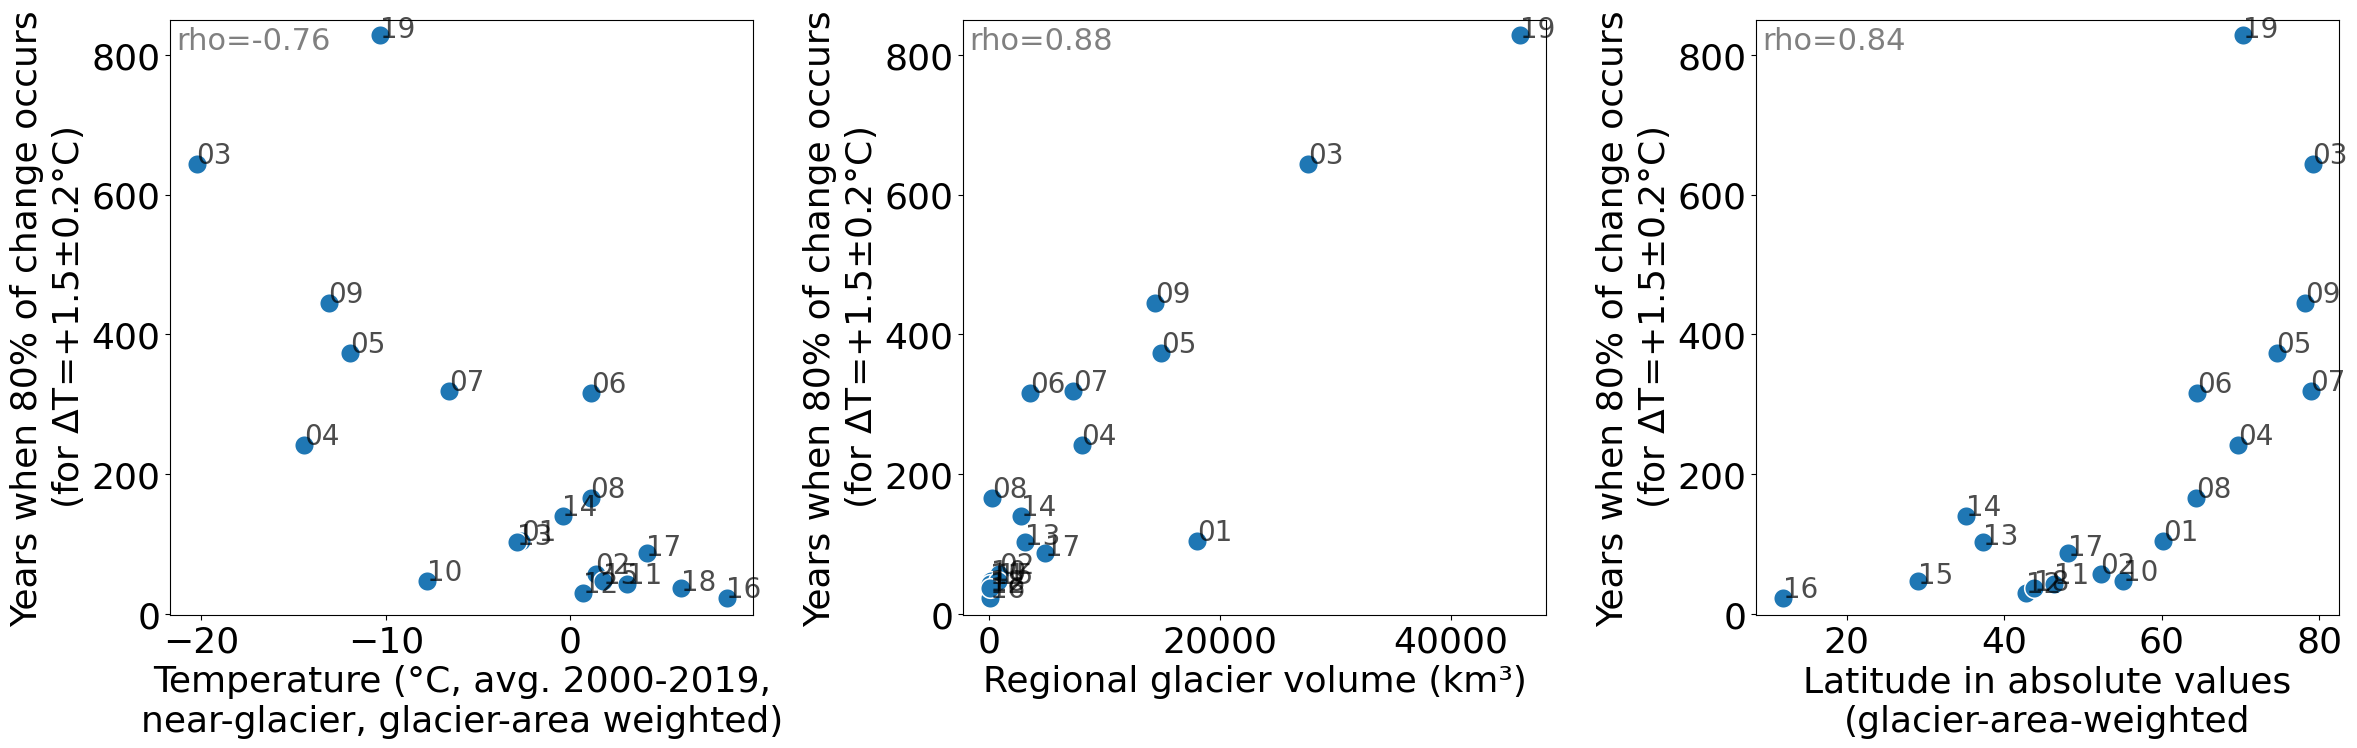

In [122]:
plt.figure(figsize=(32,8))
r=1
c=4

j=0
for col_sel,lab in zip(cols_sel_rt,cols_sel_labels):

    ax=plt.subplot(r,c,1+j)
    num_text_x = 0.01
    num_text_y = 0.95

    ylabel = f'Years when 80% of change occurs\n'+r'(for $\Delta$T=+1.5$\pm$0.2°C)'


    xx=col_sel #'elev_diff_to_med_area_weighted' #'elev_diff_to_med_area_weighted' #
    yy = 'resp_time_-80%_1_5_deg'
    sns.scatterplot(data=df,
                    y= yy, #f'ice_loss_slope_between_{np.round(temp0,1)}_and_{np.round(temp1,1)}_per_degC',
                    x=xx,
                    #hue=f'kmeans_cluster_{k}{rel_add}',
                    #palette=palette_cb[:k],
                    s=200, legend = False)
    print_spearman = True
    corrcoef,pval = spearmanr(df[[xx,yy]].dropna()[xx].values, df[[xx,yy]].dropna()[yy].values)
    corrcoef = corrcoef.round(2)
    if (pval <0.05) and print_spearman:
        ax.text(0.01,0.95, f'rho={corrcoef}', ha='left',
                transform=ax.transAxes, color='grey', fontsize=22)
    #pd_lowess_ch.apply(lambda x: _plotlabel(x[xx],x[yy], x.index, ax=ax), axis=1)
    #pd_lowess_ch.drop(['05','04','11','07','16','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
    #pd_lowess_ch.loc[['05','04','11','07','16','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
    df.drop(['19','17','18','15','13']).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
    df.loc[['19','17','18','15','13']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(lab)

    plt.ylim([-2,850])
    j+=1
plt.tight_layout()

In [91]:
columns_sel_rt =  ['temp_ch_avg_2000-2019_vs_1901-1920',
 'temp_avg_2000-2019',
 'prcp_avg_2000-2019',
 'continentality_index_avg_2000-2019',
 'median_reg_vs_glob_ch',
 'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
 'slope_fit_reg_vs_glob_ch',
 'slope_weighted_area_avg',
 'lat_absolute_weighted_area_avg',
 'marine_term_ratio_hundredlargest_glac',
 'mean_vol_ten_largest_glac',
 'elev_diff_area_weighted',
 #'elev_diff_to_med_area_weighted',
 'ice_cap_ratio_hundredlargest_glac',
 'max_elev_area_weighted',
 'min_elev_area_weighted',
 'mean_area_ten_largest_glac',
 #'mean_len_ten_largest_glac',
 'regional_volume_m3_itmix',
 'dvoldt_m3_hugonnet',
       f'regional_volume_m3_2020{approach}',
 '20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%',
 '20yr_regional_dvol_dt_2000_2019_vs_farinotti_vol_%',
 'ice_loss_1.2°C_%_rel_2020',
 'ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020',
                          'median_reg_vs_glob_temp_ch_0.8_1.5',
       'median_reg_vs_glob_temp_ch_1.5_3.0']

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression


### Stuff for the multilinear fit ... 
# assume linear relationship, but could add np.log, 1/x and 1/x+1 relationships (this would definitely increase the R2...)
from statsmodels.formula.api import ols

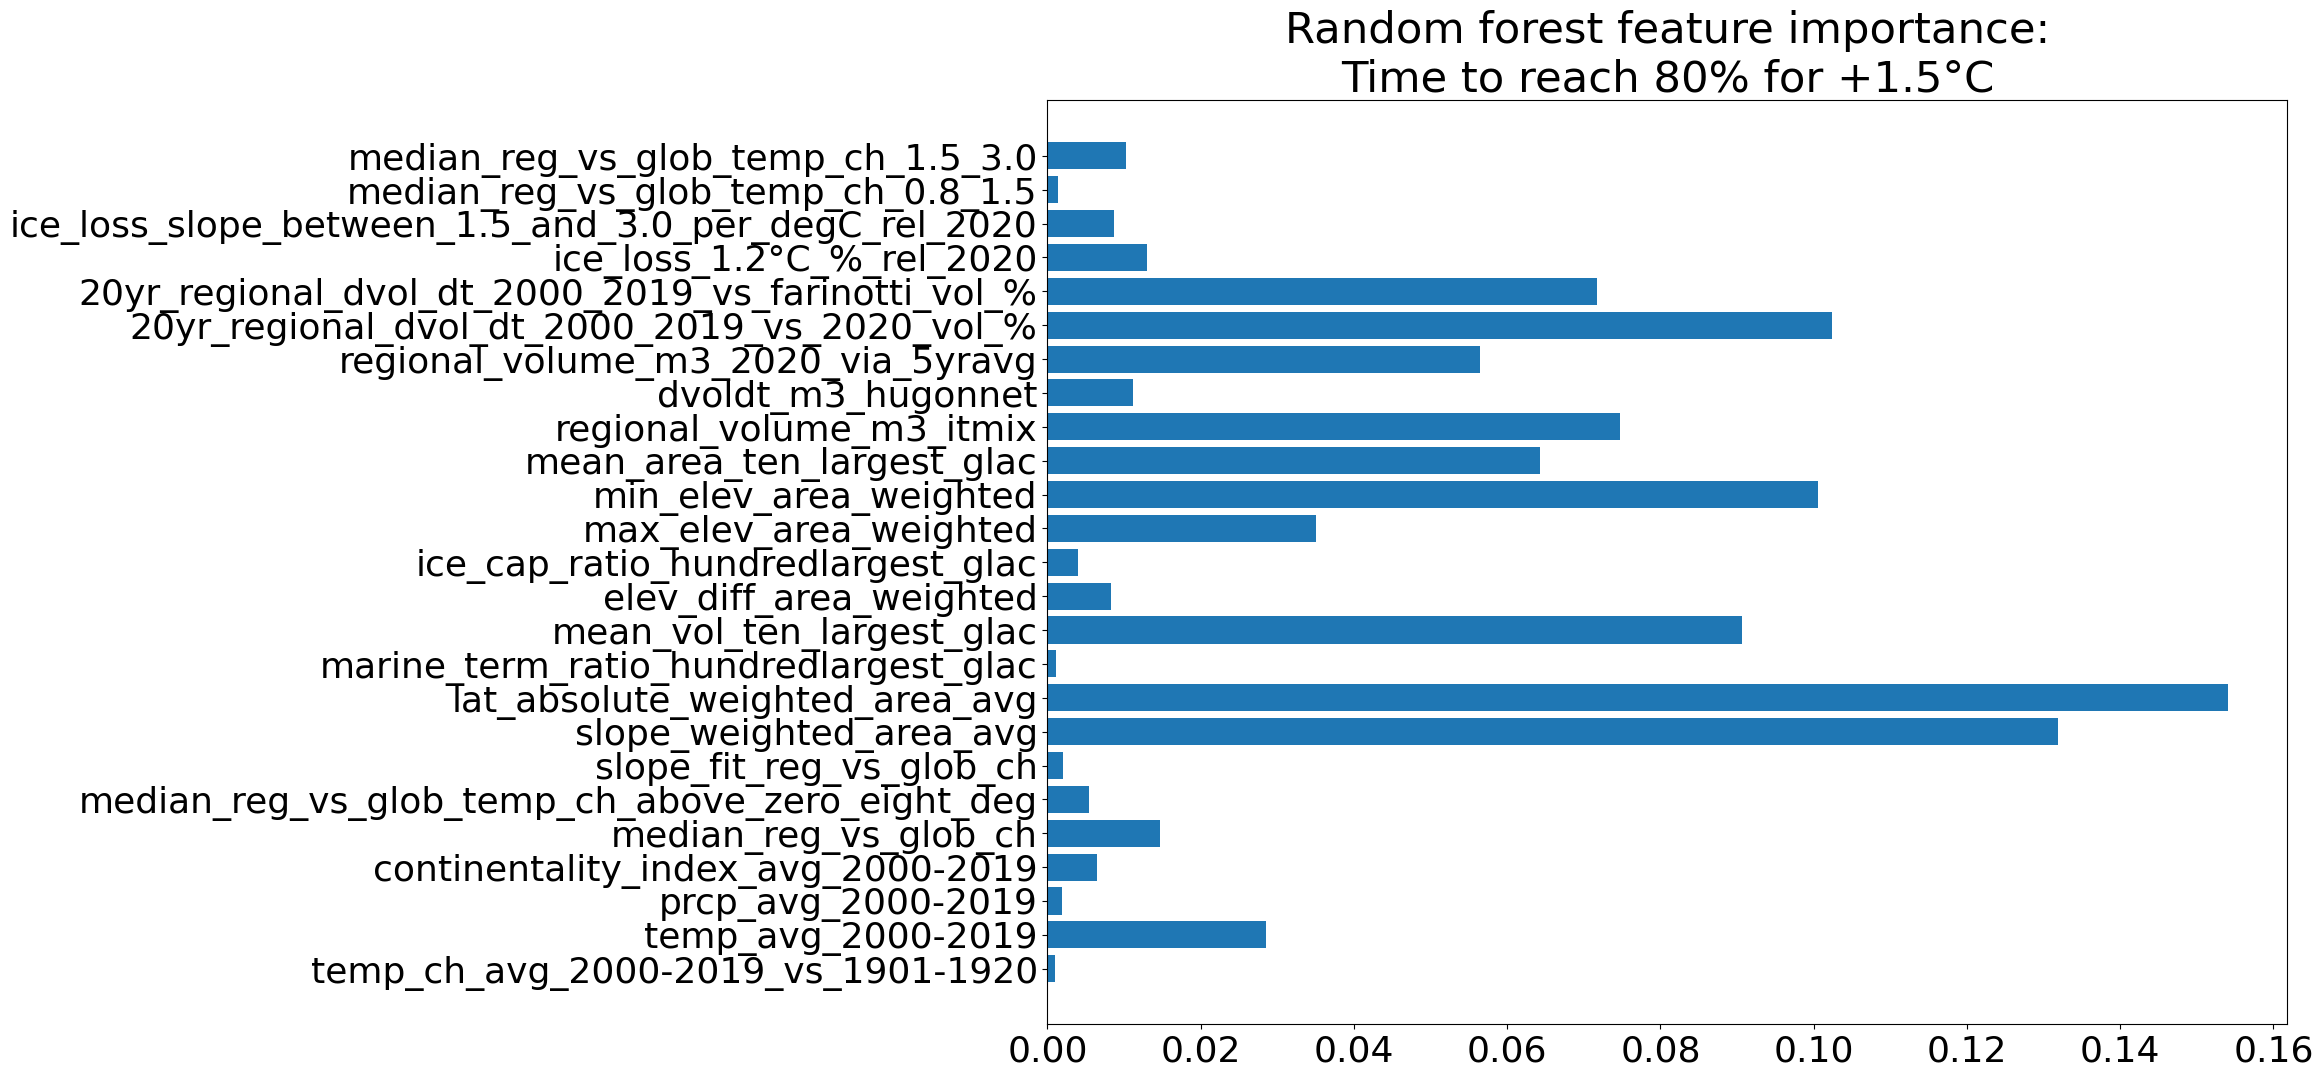

In [93]:
plt.figure(figsize=(16,12))

X = df.iloc[1:].reset_index(drop=True)[columns_sel_rt]
y = df.iloc[1:].reset_index(drop=True)['resp_time_-80%_1_5_deg']
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)

# get importance
importance = clf.feature_importances_
# summarize feature importance
#for i,v in zip(X.columns, importance):
#    print(f'Feature: {i}, Score: {v:.5f}')
# plot feature importance
plt.title('Random forest feature importance:\nTime to reach 80% for +1.5°C')
plt.barh(X.columns,importance)
plt.show()

In [94]:
columns_sel =  ['temp_ch_avg_2000-2019_vs_1901-1920',
 'temp_avg_2000-2019',
 'prcp_avg_2000-2019',
 'continentality_index_avg_2000-2019',
 'median_reg_vs_glob_ch',
 'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
                        'median_reg_vs_glob_temp_ch_0.8_1.5',
       'median_reg_vs_glob_temp_ch_1.5_3.0',
 'slope_fit_reg_vs_glob_ch',
 'slope_weighted_area_avg',
 'lat_absolute_weighted_area_avg',
 'marine_term_ratio_hundredlargest_glac',
 'mean_vol_ten_largest_glac',
 'elev_diff_area_weighted',
 #'elev_diff_to_med_area_weighted',
 'ice_cap_ratio_hundredlargest_glac',
 'max_elev_area_weighted',
 'min_elev_area_weighted',
 'mean_area_ten_largest_glac',
 #'mean_len_ten_largest_glac',
 'regional_volume_m3_itmix',
 'dvoldt_m3_hugonnet',
                       f'regional_volume_m3_2020{approach}',
 '20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%',
 '20yr_regional_dvol_dt_2000_2019_vs_farinotti_vol_%',
                    'resp_time_-50%_1_5_deg',
 'resp_time_-50%_3_0_deg',
 'resp_time_-80%_1_5_deg',
 'resp_time_-80%_3_0_deg',
                   
                   
 #'ice_loss_1.2°C_%_rel_2020',
 #'ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020'
                         ]

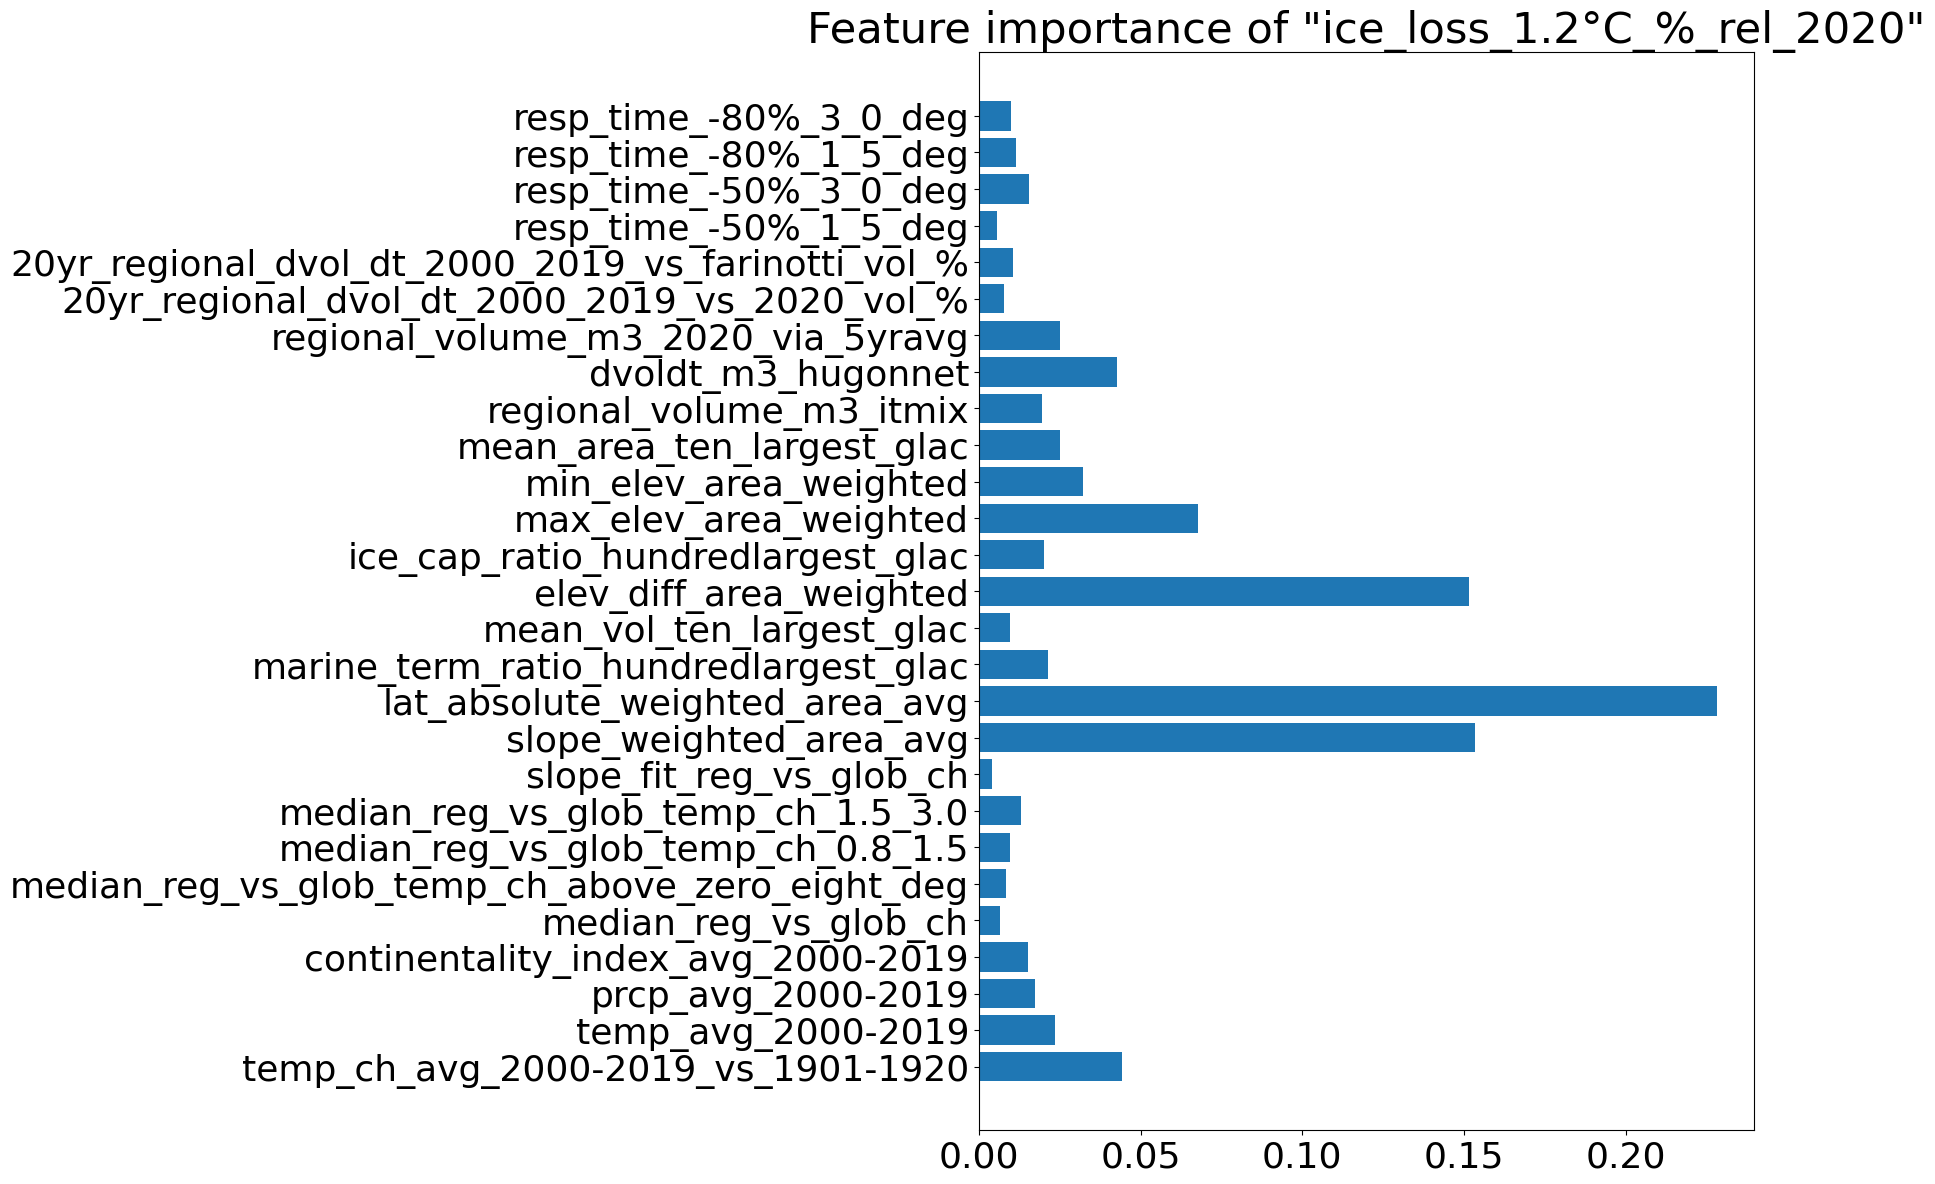

In [95]:
plt.figure(figsize=(10,14))
X = df.iloc[1:].reset_index(drop=True)[columns_sel]
y = df.iloc[1:].reset_index(drop=True)['ice_loss_1.2°C_%_rel_2020']
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)

# get importance
importance = clf.feature_importances_
# summarize feature importance
#for i,v in zip(X.columns, importance):
#    print(f'Feature: {i}, Score: {v:.5f}')
# plot feature importance
plt.barh(X.columns,importance)
plt.title('Feature importance of "ice_loss_1.2°C_%_rel_2020"')
plt.show()



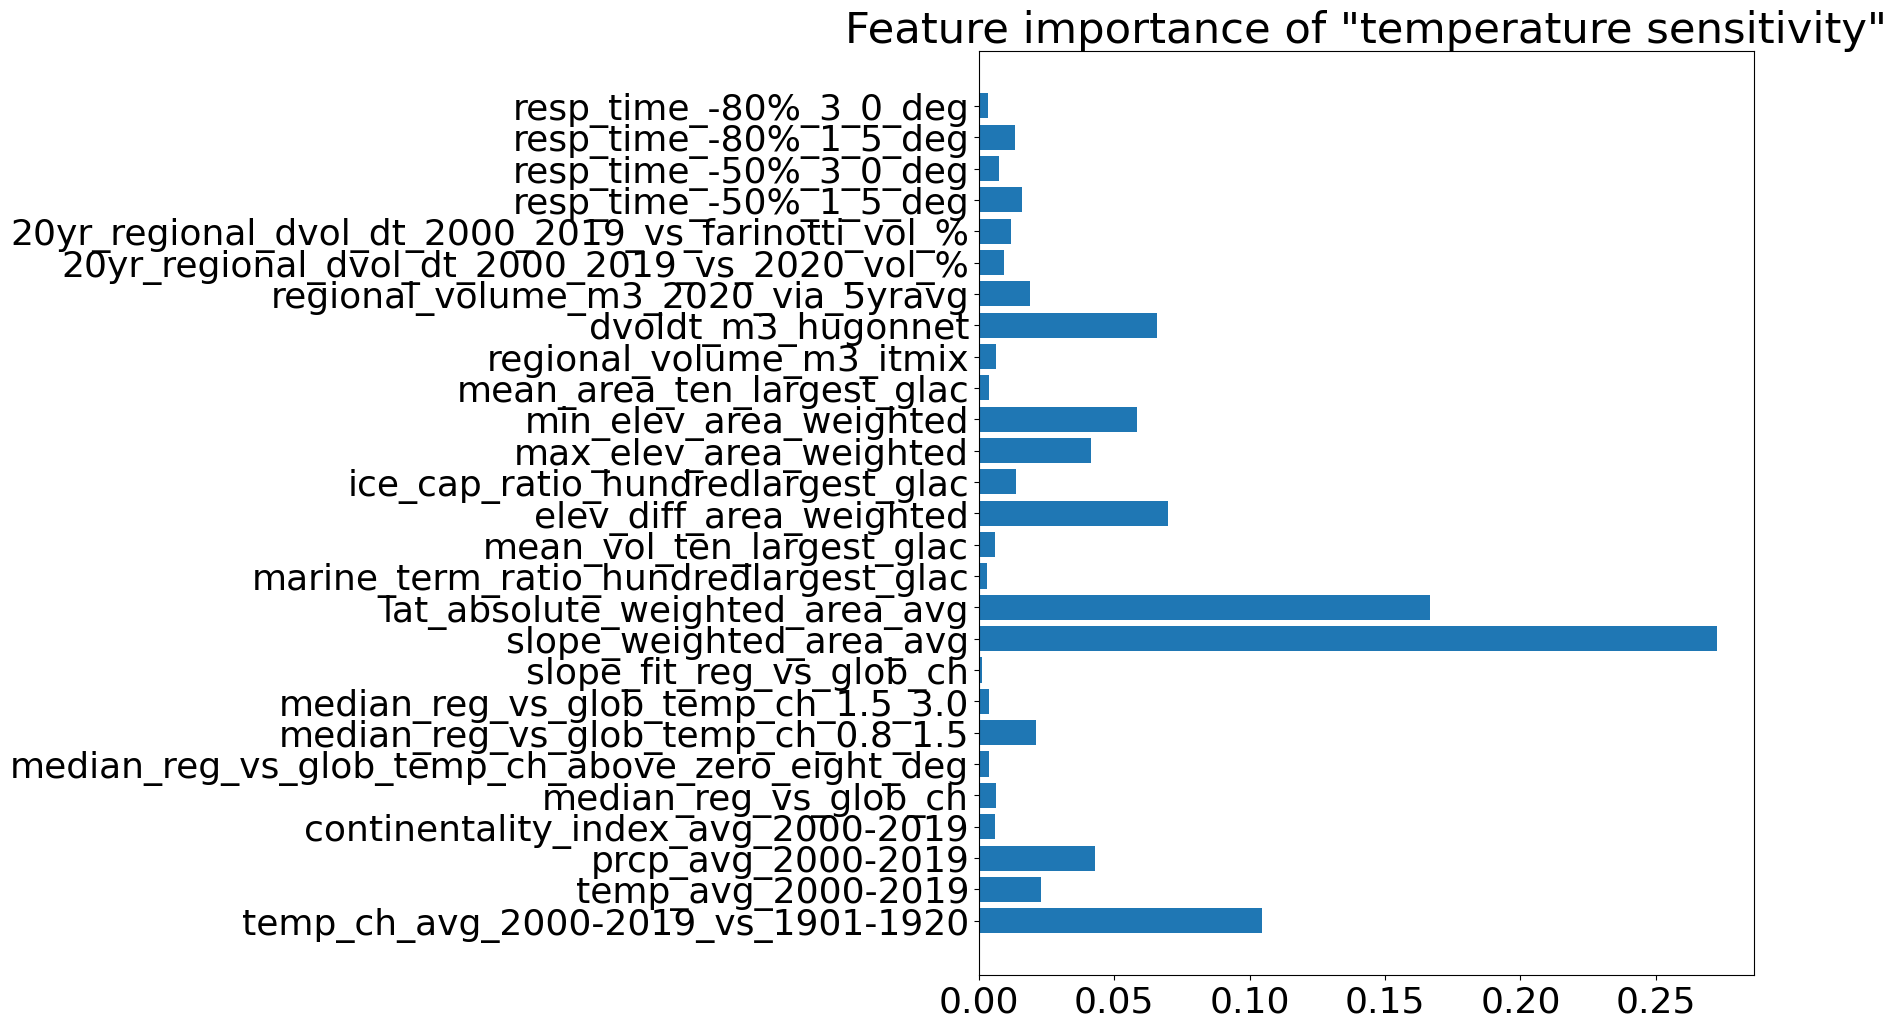

In [96]:
plt.figure(figsize=(10,12))
X = df.iloc[1:].reset_index(drop=True)[columns_sel]
y = df.iloc[1:].reset_index(drop=True)['ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020']
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)

# get importance
importance = clf.feature_importances_
# summarize feature importance
#for i,v in zip(X.columns, importance):
#    print(f'Feature: {i}, Score: {v:.5f}')
# plot feature importance
plt.barh(X.columns,importance)
plt.title('Feature importance of "temperature sensitivity"')
plt.show()



**now repeat the multilinear regression, but I am unsure if that makes sense ...**

In [97]:
df['resp_time_three_deg'] = df['resp_time_-50%_3_0_deg']
df['resp_time_one_o_five_deg'] = df['resp_time_-50%_1_5_deg']

df['resp_time_three_deg_80'] = df['resp_time_-80%_3_0_deg']
df['resp_time_one_o_five_deg_80'] = df['resp_time_-80%_1_5_deg']
df['temp_ch_avg_past'] = df['temp_ch_avg_2000-2019_vs_1901-1920'] #'temp_ch_avg_1986-2005_vs_1901-1920'
df['resp_time_three_deg'] = df['resp_time_-50%_3_0_deg']
df['resp_time_one_o_five_deg'] = df['resp_time_-50%_1_5_deg']
df['temp_avg_past'] = df['temp_avg_2000-2019']
df['prcp_avg_past'] = df['prcp_avg_2000-2019']
df['ci_avg_past'] = df['continentality_index_avg_2000-2019']
df['hugonnet_twenty_years_regional_dvol_dt_rel_now'] = df['20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%']
df['hugonnet_twenty_years_regional_dvol_dt_rel_farinotti'] = df['20yr_regional_dvol_dt_2000_2019_vs_farinotti_vol_%']
df['median_reg_vs_glob_temp_ch_around_one_o_2'] = df['median_reg_vs_glob_temp_ch_1.5_3.0']
df['median_reg_vs_glob_temp_ch_one_ofive_three'] = df['median_reg_vs_glob_temp_ch_1.5_3.0']
fs_linear_fit = [#'median_reg_vs_glob_ch',#'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
                 'median_reg_vs_glob_temp_ch_around_one_o_2',
                 'median_reg_vs_glob_temp_ch_one_ofive_three',
       'slope_fit_reg_vs_glob_ch', 
      'slope_weighted_vol_avg','hugonnet_twenty_years_regional_dvol_dt_rel_now',
                 'hugonnet_twenty_years_regional_dvol_dt_rel_farinotti',
                        'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
       'slope_weighted_area_avg', 'lat_weighted_area_avg',
       'lat_absolute_weighted_area_avg', 'temp_ch_avg_past','temp_avg_past','prcp_avg_past','ci_avg_past',
       'resp_time_three_deg','resp_time_one_o_five_deg','resp_time_one_o_five_deg','resp_time_three_deg_80',
      'marine_term_ratio_hundredlargest_glac', 'geodetic_obs_area_weighted', 'mean_vol_ten_largest_glac','elev_diff_area_weighted',
                 'elev_diff_area_weighted',
                 'ice_cap_ratio_hundredlargest_glac',
                        'max_elev_area_weighted','min_elev_area_weighted','elev_diff_to_med_area_weighted','mean_area_ten_largest_glac'] #,'mean_len_ten_largest_glac']

In [98]:
df['commit'] = df['ice_loss_1.2°C_%_rel_2020']
df['sensitivity'] = df['ice_loss_slope_between_1.5_and_3.0_per_degC_rel_2020']

fs_linear_fit_rt = ['commit', 'sensitivity',#'median_reg_vs_glob_ch',#'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
                                     'median_reg_vs_glob_temp_ch_around_one_o_2',
                 'median_reg_vs_glob_temp_ch_one_ofive_three',
       'slope_fit_reg_vs_glob_ch', 
      'slope_weighted_vol_avg','hugonnet_twenty_years_regional_dvol_dt_rel_now',
                 'hugonnet_twenty_years_regional_dvol_dt_rel_farinotti',
                        'median_reg_vs_glob_temp_ch_above_zero_eight_deg',
       'slope_weighted_area_avg', 'lat_weighted_area_avg',
       'lat_absolute_weighted_area_avg', 'temp_ch_avg_past','temp_avg_past','prcp_avg_past','ci_avg_past',
       #'resp_time_three_deg','resp_time_one_o_five_deg','resp_time_one_o_five_deg','resp_time_three_deg_80',
      'marine_term_ratio_hundredlargest_glac', 'geodetic_obs_area_weighted', 'mean_vol_ten_largest_glac','elev_diff_area_weighted',
                 'elev_diff_area_weighted',
                 'ice_cap_ratio_hundredlargest_glac',
                        'max_elev_area_weighted','min_elev_area_weighted','elev_diff_to_med_area_weighted','mean_area_ten_largest_glac'
                   ] #,'mean_len_ten_largest_glac']

In [99]:
def log(x):
    return np.log(x)
def hyperb(x):
    return 1/x
def hyperb_plus(x):
    return 1/(x+1)
def linear(x):
    return x
def quadratic(x):
    return x**2

features_bic_d_a_simple={}
features_bic_d_b_simple = {}
features_r2_d_b_simple = {}
features_r2_d_a_simple = {}
features_r2_adj_d_a_simple = {}
features_r2_adj_d_b_simple = {}
fs = fs_linear_fit
for f in fs:
    for ff in fs:
        for fff in fs:
            features = f"{f}+{ff}+{fff}"
            #func=linear
            #for func in ['linear','hyperb','hyperb_plus','quadratic','log']:
            # here we only assume linearities, but actually it could also be 
            prestige_model_a = ols(f"commit ~{features}",
                                     data=df.iloc[1:]).fit()
            prestige_model_b = ols(f"sensitivity ~{features}",
                                 data=df.iloc[1:]).fit()
            features_bic_d_a_simple[features] = prestige_model_a.bic
            features_bic_d_b_simple[features] = prestige_model_b.bic
            features_r2_d_a_simple[features] = prestige_model_a.rsquared
            features_r2_d_b_simple[features] = prestige_model_b.rsquared
            features_r2_adj_d_a_simple[features] = prestige_model_a.rsquared_adj
            features_r2_adj_d_b_simple[features] = prestige_model_b.rsquared_adj

pd_a = pd.DataFrame(features_bic_d_a_simple, index=['BIC']).T.sort_values(by='BIC')[::6]
pd_a['R2'] = pd.DataFrame(features_r2_d_a_simple, index=['R2']).T.loc[pd_a.index]
pd_a['R2_adj'] = pd.DataFrame(features_r2_adj_d_a_simple, index=['R2_adj']).T.loc[pd_a.index]
pd_a.iloc[:5]

BIC        R2  \
elev_diff_to_med_area_weighted+median_reg_vs_gl...  152.282556  0.687946   
median_reg_vs_glob_temp_ch_one_ofive_three+elev...  152.282556  0.687946   
geodetic_obs_area_weighted+lat_weighted_area_av...  152.665339  0.681239   
slope_fit_reg_vs_glob_ch+elev_diff_to_med_area_...  152.901589  0.677028   
median_reg_vs_glob_temp_ch_above_zero_eight_deg...  153.598793  0.664272   

                                                      R2_adj  
elev_diff_to_med_area_weighted+median_reg_vs_gl...  0.621077  
median_reg_vs_glob_temp_ch_one_ofive_three+elev...  0.621077  
geodetic_obs_area_weighted+lat_weighted_area_av...  0.612933  
slope_fit_reg_vs_glob_ch+elev_diff_to_med_area_...  0.607819  
median_reg_vs_glob_temp_ch_above_zero_eight_deg...  0.592331

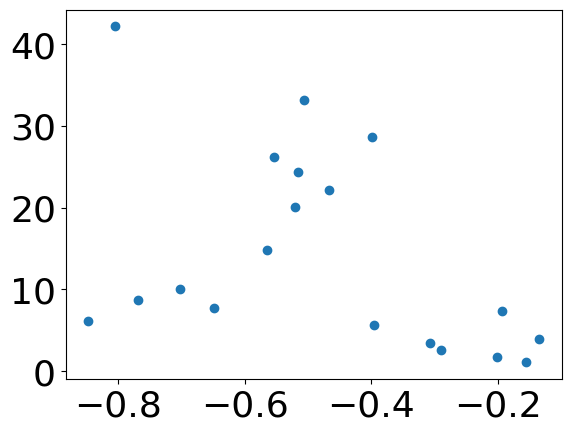

In [100]:
plt.plot(df.geodetic_obs_area_weighted, df['20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%'], 'o')

In [101]:
best_features_a = pd.DataFrame(features_bic_d_a_simple, index=['BIC']).T.idxmin().values[0]
prestige_model_a = ols(f"commit ~ {best_features_a}",
                                 data=df.iloc[1:]).fit()
prestige_model_a.summary()

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 commit   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     10.29
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           0.000772
Time:                        21:43:35   Log-Likelihood:                -70.361
No. Observations:                  18   AIC:                             148.7
Df Residuals:                      14   BIC:                             152.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -27.0021     25.197     -1.072      0.302     -81.045      27.041
median_reg_vs_glob_temp_ch_around_one_o_2    39.6781     13.557      2.927      0.011      10.601      68.755
geodetic_obs_area_weighted                  -77.2264     17.707     -4.361      0.001    -115.205     -39.248
elev_diff_to_med_area_weighted               -0.0277      0.011     -2.621      0.020      -0.050      -0.005
==============================================================================
Omnibus:                        0.196   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.396
Skew:                           0.107   Prob(JB):                        0.821
Kurtosis:                       2.306   Cond. No.                     6.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

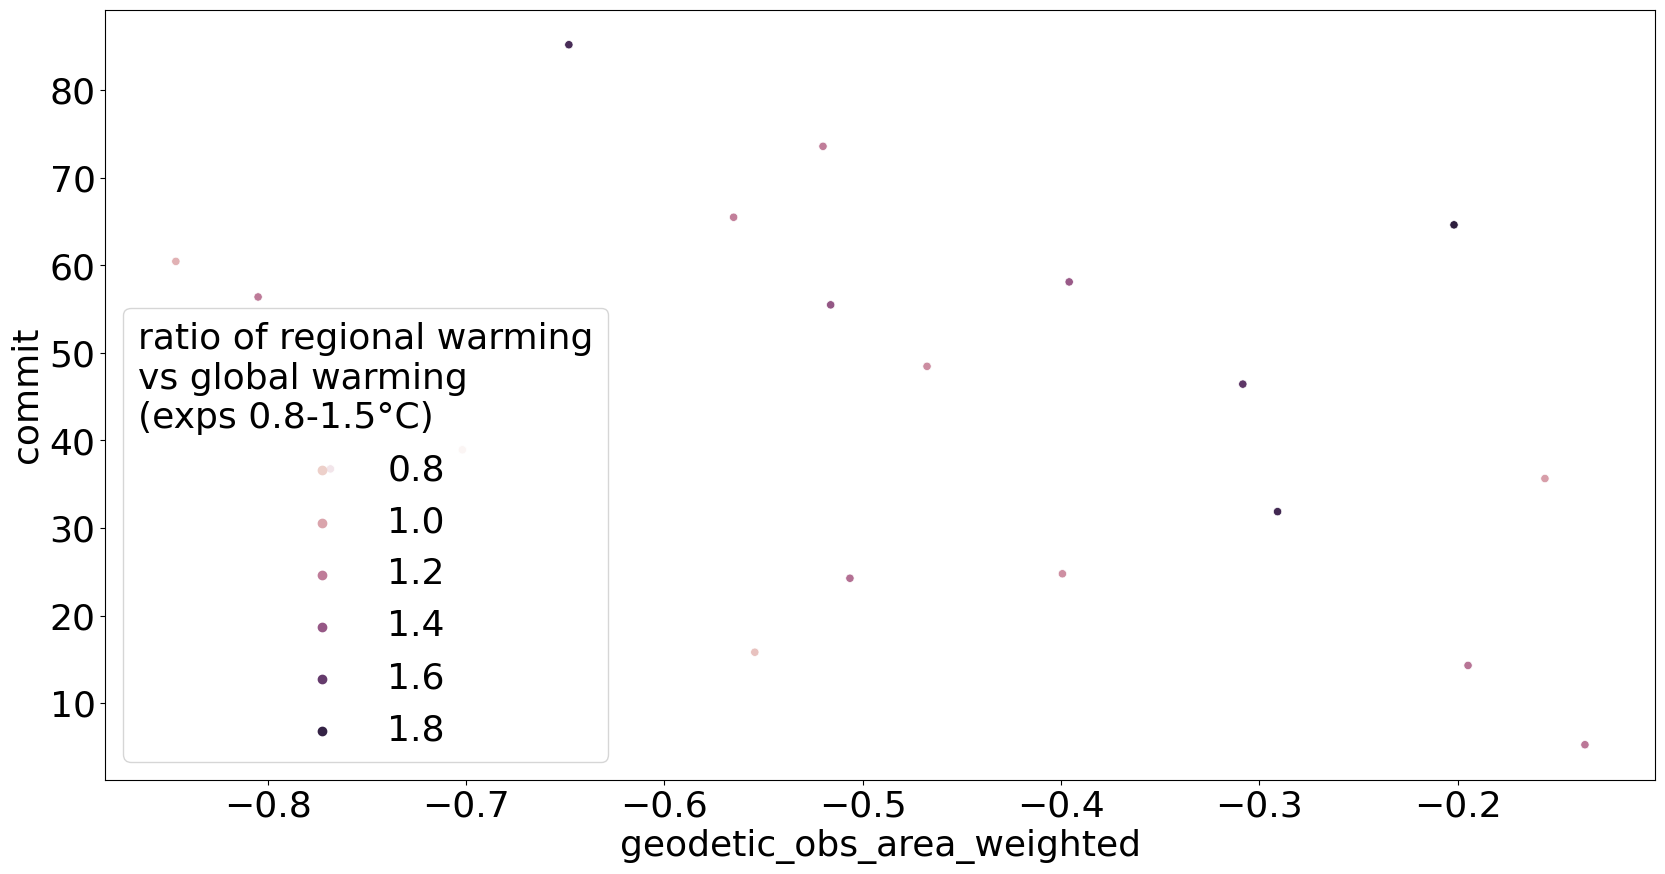

In [102]:
# actually I don't see anything here ...
plt.figure(figsize=(20,10))
sns.scatterplot(data = df, x='geodetic_obs_area_weighted', y='commit', hue='median_reg_vs_glob_temp_ch_around_one_o_2')
plt.legend(title='ratio of regional warming\nvs global warming\n(exps 0.8-1.5°C)')
# For example, more ice is committed to be lost in regions with stronger warming if temperature increases and if geodetic observations are more negative ???
# no, not really ...

In [103]:
def log(x):
    return np.log(x)
def hyperb(x):
    return 1/x
def hyperb_plus(x):
    return 1/(x+1)
def linear(x):
    return x
def quadratic(x):
    return x**2

features_bic_d_a_simple={}
features_bic_d_b_simple = {}
features_r2_d_b_simple = {}
features_r2_d_a_simple = {}
features_r2_adj_d_a_simple = {}
features_r2_adj_d_b_simple = {}
fs = fs_linear_fit
for f in fs:
    for ff in fs:
        #for fff in fs:
        features = f"{f}+{ff}" #+{fff}"
        #func=linear
        #for func in ['linear','hyperb','hyperb_plus','quadratic','log']:
        # here we only assume linearities, but actually it could also be 
        prestige_model_a = ols(f"commit ~{features}",
                                 data=df.iloc[1:]).fit()
        prestige_model_b = ols(f"sensitivity ~{features}",
                             data=df.iloc[1:]).fit()
        features_bic_d_a_simple[features] = prestige_model_a.bic
        features_bic_d_b_simple[features] = prestige_model_b.bic
        features_r2_d_a_simple[features] = prestige_model_a.rsquared
        features_r2_d_b_simple[features] = prestige_model_b.rsquared
        features_r2_adj_d_a_simple[features] = prestige_model_a.rsquared_adj
        features_r2_adj_d_b_simple[features] = prestige_model_b.rsquared_adj

pd_a = pd.DataFrame(features_bic_d_a_simple, index=['BIC']).T.sort_values(by='BIC')[::6]
pd_a['R2'] = pd.DataFrame(features_r2_d_a_simple, index=['R2']).T.loc[pd_a.index]
pd_a['R2_adj'] = pd.DataFrame(features_r2_adj_d_a_simple, index=['R2_adj']).T.loc[pd_a.index]
pd_a.iloc[:5]

BIC        R2  \
slope_weighted_vol_avg+elev_diff_to_med_area_we...  157.738792  0.503851   
max_elev_area_weighted+elev_diff_to_med_area_we...  159.604832  0.449655   
elev_diff_to_med_area_weighted+lat_weighted_are...  161.861291  0.376154   
elev_diff_to_med_area_weighted+mean_area_ten_la...  164.182863  0.290273   
ci_avg_past+elev_diff_to_med_area_weighted          164.709146  0.269216   

                                                      R2_adj  
slope_weighted_vol_avg+elev_diff_to_med_area_we...  0.437698  
max_elev_area_weighted+elev_diff_to_med_area_we...  0.376276  
elev_diff_to_med_area_weighted+lat_weighted_are...  0.292974  
elev_diff_to_med_area_weighted+mean_area_ten_la...  0.195643  
ci_avg_past+elev_diff_to_med_area_weighted          0.171778

In [104]:
df.mean_len_ten_largest_glac

All          NaN
01           NaN
02           NaN
03     78.380625
04     46.283600
05     46.585750
06     45.105111
07     49.894000
08     12.745857
09     47.861400
10     12.514800
11           NaN
12           NaN
13           NaN
14     69.181000
15     25.870000
16      6.022556
17           NaN
18           NaN
19           NaN
Name: mean_len_ten_largest_glac, dtype: float64

In [105]:
df.mean_len_ten_largest_glac

All          NaN
01           NaN
02           NaN
03     78.380625
04     46.283600
05     46.585750
06     45.105111
07     49.894000
08     12.745857
09     47.861400
10     12.514800
11           NaN
12           NaN
13           NaN
14     69.181000
15     25.870000
16      6.022556
17           NaN
18           NaN
19           NaN
Name: mean_len_ten_largest_glac, dtype: float64

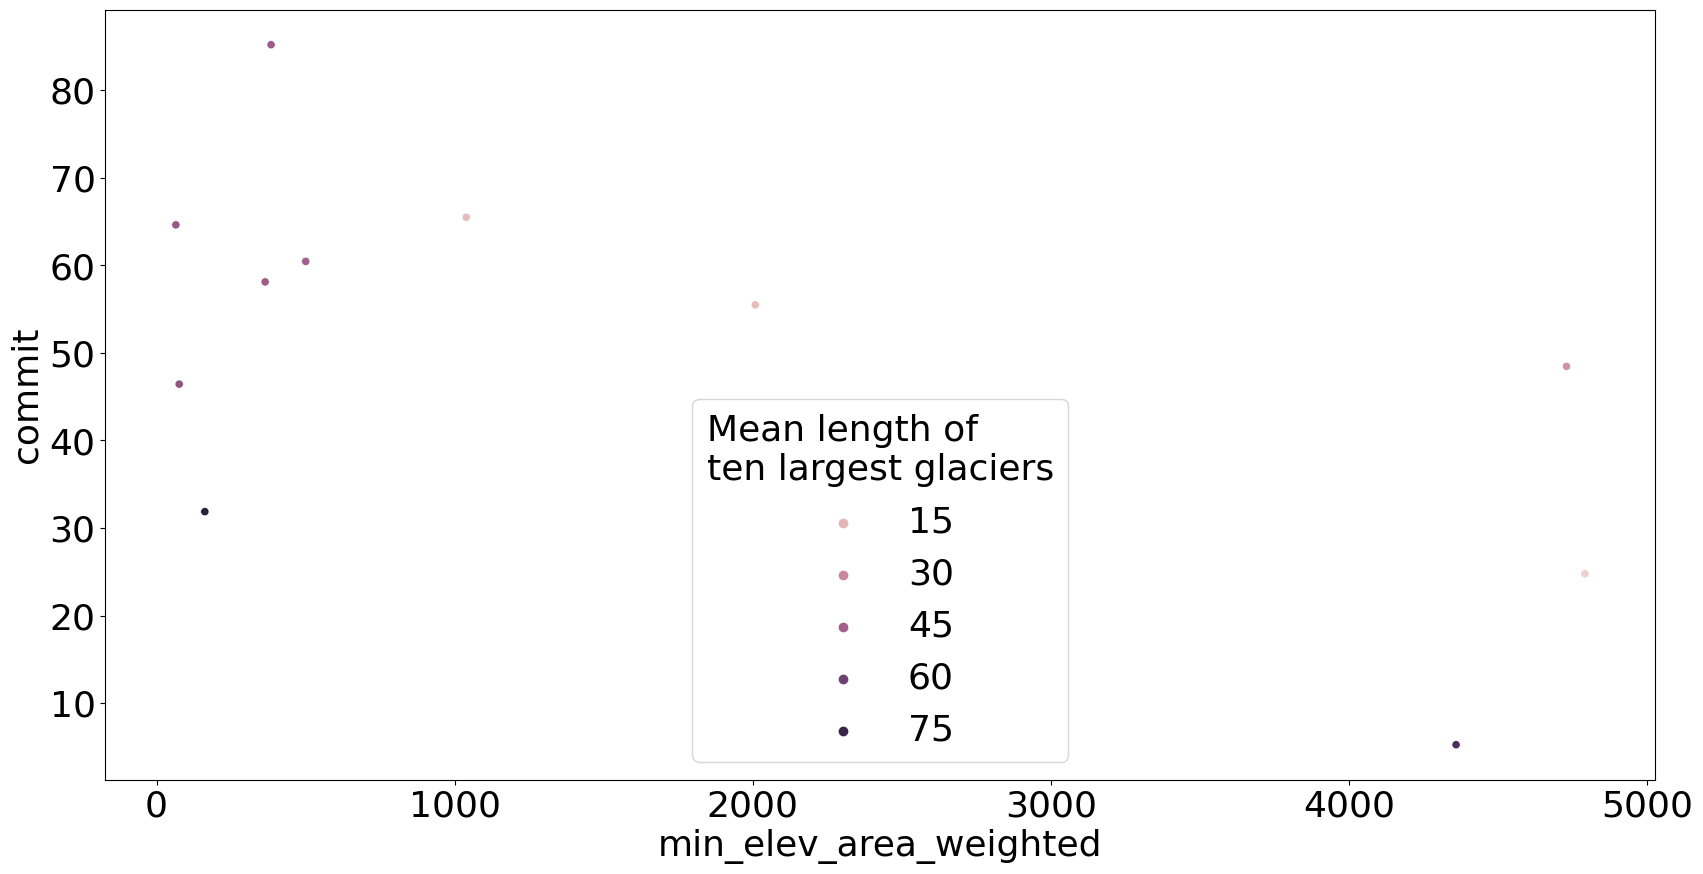

In [106]:
# amean_len_ten_largest_glacI don't see anything here ...
plt.figure(figsize=(20,10))
sns.scatterplot(data = df, x='min_elev_area_weighted', y='commit', hue='mean_len_ten_largest_glac')
plt.legend(title='Mean length of\nten largest glaciers')
# no, not really ...

*temperatuer sensitivity*

In [107]:
pd_b = pd.DataFrame(features_bic_d_b_simple, index=['BIC']).T.sort_values(by='BIC')[::6]
pd_b['R2'] = pd.DataFrame(features_r2_d_b_simple, index=['R2']).T.loc[pd_b.index]
pd_b['R2_adj'] = pd.DataFrame(features_r2_adj_d_b_simple, index=['R2_adj']).T.loc[pd_b.index]
pd_b.iloc[:5]

BIC        R2  \
hugonnet_twenty_years_regional_dvol_dt_rel_fari...  120.761853  0.541047   
geodetic_obs_area_weighted+elev_diff_to_med_are...  122.584538  0.317597   
elev_diff_to_med_area_weighted+min_elev_area_we...  123.039594  0.300126   
slope_weighted_area_avg+slope_weighted_vol_avg      124.041886  0.454566   
elev_diff_to_med_area_weighted+lat_absolute_wei...  124.478120  0.241897   

                                                      R2_adj  
hugonnet_twenty_years_regional_dvol_dt_rel_fari...  0.483678  
geodetic_obs_area_weighted+elev_diff_to_med_are...  0.226610  
elev_diff_to_med_area_weighted+min_elev_area_we...  0.206809  
slope_weighted_area_avg+slope_weighted_vol_avg      0.386387  
elev_diff_to_med_area_weighted+lat_absolute_wei...  0.140817

In [108]:
best_features_b = pd.DataFrame(features_bic_d_b_simple, index=['BIC']).T.idxmin().values[0]
prestige_model_b = ols(f"sensitivity ~ {best_features_b}",
                                 data=df.iloc[1:]).fit()
prestige_model_b.summary()

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sensitivity   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     9.431
Date:                Fri, 26 Apr 2024   Prob (F-statistic):            0.00197
Time:                        21:43:41   Log-Likelihood:                -55.964
No. Observations:                  19   AIC:                             117.9
Df Residuals:                      16   BIC:                             120.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               11.0682      2.814      3.934      0.001       5.103      17.033
slope_weighted_vol_avg                                   1.1456      0.265      4.320      0.001       0.583       1.708
hugonnet_twenty_years_regional_dvol_dt_rel_farinotti    -0.5033      0.184     -2.742      0.014      -0.892      -0.114
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.690
Skew:                          -0.643   Prob(JB):                        0.429
Kurtosis:                       2.307   Cond. No.                         50.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Time to reach 50/80% analysis**

In [109]:
fs = fs_linear_fit_rt
features_bic_d_1_5_simple = {}
features_bic_d_3_0_simple = {}
for f in fs:
    for ff in fs:
        for fff in fs:
            
            features = f"{f}+{ff}+{fff}"
            prestige_model_1_5 = ols(f"resp_time_one_o_five_deg ~ {features}",
                                 data=df.iloc[1:]).fit()
            prestige_model_3 = ols(f"resp_time_three_deg ~ {features}",
                                 data=df.iloc[1:]).fit()
            features_bic_d_1_5_simple[features] = prestige_model_1_5.bic
            features_bic_d_3_0_simple[features] = prestige_model_3.bic
            
best_features_1_5 = pd.DataFrame(features_bic_d_1_5_simple, index=['BIC']).T.idxmin().values[0]
print(best_features_1_5)
prestige_model_1_5 = ols(f"resp_time_one_o_five_deg ~ {best_features_1_5}",
                                 data=df.iloc[1:]).fit()
print(prestige_model_1_5.summary())

mean_vol_ten_largest_glac+elev_diff_to_med_area_weighted+mean_area_ten_largest_glac
                               OLS Regression Results                               
Dep. Variable:     resp_time_one_o_five_deg   R-squared:                       0.933
Model:                                  OLS   Adj. R-squared:                  0.919
Method:                       Least Squares   F-statistic:                     65.50
Date:                      Fri, 26 Apr 2024   Prob (F-statistic):           1.75e-08
Time:                              21:45:47   Log-Likelihood:                -76.690
No. Observations:                        18   AIC:                             161.4
Df Residuals:                            14   BIC:                             164.9
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                     coef    std err          t   

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [110]:
pd_rt_15 = pd.DataFrame(features_bic_d_1_5_simple, index=['BIC']).T.sort_values(by='BIC')[::6]
pd_rt_15.iloc[:5]

BIC
mean_area_ten_largest_glac+mean_vol_ten_largest...  164.941868
geodetic_obs_area_weighted+mean_area_ten_larges...  165.099763
ice_cap_ratio_hundredlargest_glac+mean_area_ten...  166.147211
mean_area_ten_largest_glac+hugonnet_twenty_year...  166.264997
elev_diff_to_med_area_weighted+mean_area_ten_la...  166.339693

                               OLS Regression Results                               
Dep. Variable:     resp_time_one_o_five_deg   R-squared:                       0.671
Model:                                  OLS   Adj. R-squared:                  0.652
Method:                       Least Squares   F-statistic:                     34.67
Date:                      Fri, 26 Apr 2024   Prob (F-statistic):           1.79e-05
Time:                              21:45:47   Log-Likelihood:                -99.885
No. Observations:                        19   AIC:                             203.8
Df Residuals:                            17   BIC:                             205.7
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0, 0.5, 'resp_time_1_5_deg-50%')

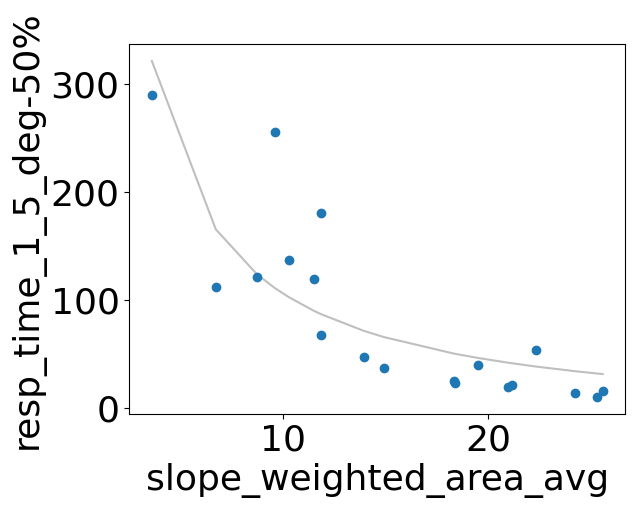

In [111]:
# best single variable ... 
prestige_model_1_5x = ols(f"resp_time_one_o_five_deg ~ hyperb(slope_weighted_area_avg)",
                            data=df.iloc[1:]).fit()
print(prestige_model_1_5x.summary())

fit_sorted = prestige_model_1_5x.fittedvalues.sort_values()
plt.plot(df.loc[fit_sorted.index].slope_weighted_area_avg, fit_sorted.values, color='grey', alpha = 0.5)
plt.plot(df.slope_weighted_area_avg, df.resp_time_one_o_five_deg, 'o')
plt.xlabel('slope_weighted_area_avg')
plt.ylabel('resp_time_1_5_deg-50%')

                                 OLS Regression Results                                
Dep. Variable:     resp_time_one_o_five_deg_80   R-squared:                       0.738
Model:                                     OLS   Adj. R-squared:                  0.722
Method:                          Least Squares   F-statistic:                     47.84
Date:                         Fri, 26 Apr 2024   Prob (F-statistic):           2.49e-06
Time:                                 21:45:48   Log-Likelihood:                -116.75
No. Observations:                           19   AIC:                             237.5
Df Residuals:                               17   BIC:                             239.4
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0, 0.5, 'resp_time_1_5_deg-80%')

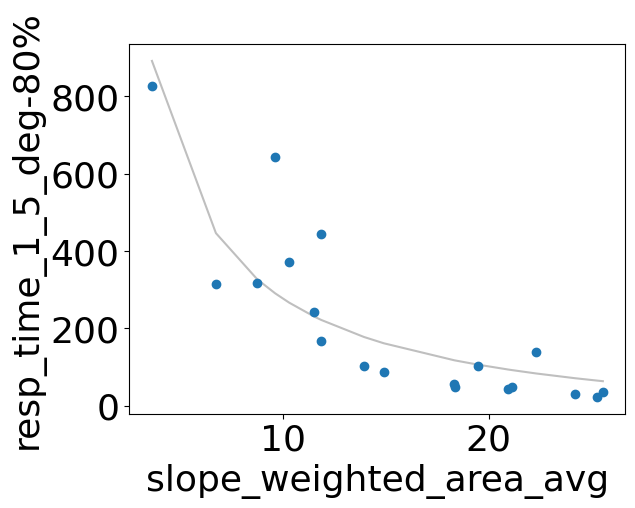

In [112]:
# best single variable ... 
prestige_model_1_5x = ols(f"resp_time_one_o_five_deg_80 ~ hyperb(slope_weighted_area_avg)",
                            data=df.iloc[1:]).fit()
print(prestige_model_1_5x.summary())

fit_sorted = prestige_model_1_5x.fittedvalues.sort_values()
plt.plot(df.loc[fit_sorted.index].slope_weighted_area_avg, fit_sorted.values, color='grey', alpha = 0.5)
plt.plot(df.slope_weighted_area_avg, df.resp_time_one_o_five_deg_80, 'o')
plt.xlabel('slope_weighted_area_avg')
plt.ylabel('resp_time_1_5_deg-80%')

In [113]:
best_features_3_0 = pd.DataFrame(features_bic_d_3_0_simple, index=['BIC']).T.idxmin().values[0]
print(best_features_3_0)
prestige_model_3_0 = ols(f"resp_time_three_deg ~ {best_features_3_0}",
                                 data=df.iloc[1:]).fit()
print(prestige_model_3_0.summary())

commit+mean_area_ten_largest_glac+elev_diff_to_med_area_weighted
                             OLS Regression Results                            
Dep. Variable:     resp_time_three_deg   R-squared:                       0.949
Model:                             OLS   Adj. R-squared:                  0.938
Method:                  Least Squares   F-statistic:                     86.54
Date:                 Fri, 26 Apr 2024   Prob (F-statistic):           2.82e-09
Time:                         21:45:48   Log-Likelihood:                -63.344
No. Observations:                   18   AIC:                             134.7
Df Residuals:                       14   BIC:                             138.3
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                             OLS Regression Results                            
Dep. Variable:     resp_time_three_deg   R-squared:                       0.767
Model:                             OLS   Adj. R-squared:                  0.753
Method:                  Least Squares   F-statistic:                     56.00
Date:                 Fri, 26 Apr 2024   Prob (F-statistic):           8.95e-07
Time:                         21:45:48   Log-Likelihood:                -88.281
No. Observations:                   19   AIC:                             180.6
Df Residuals:                       17   BIC:                             182.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0, 0.5, 'resp_time_three_deg-50%')

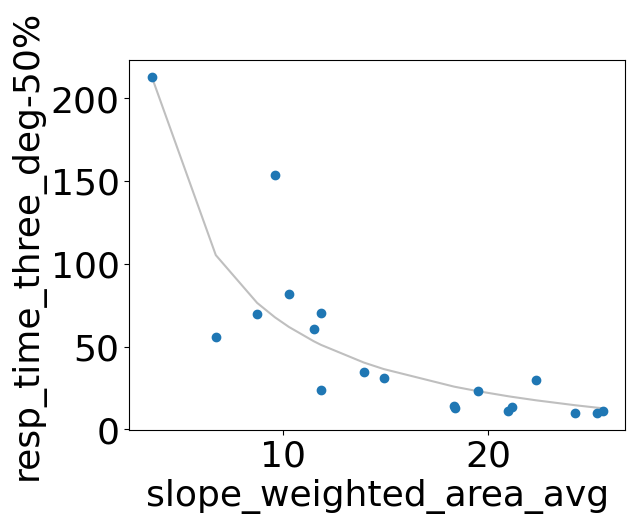

In [114]:
# best single variable ... 
prestige_model_3degx = ols(f"resp_time_three_deg ~ hyperb(slope_weighted_area_avg)",
                                 data=df.iloc[1:]).fit()
print(prestige_model_3degx.summary())

fit_sorted = prestige_model_3degx.fittedvalues.sort_values()
plt.plot(df.loc[fit_sorted.index].slope_weighted_area_avg, fit_sorted.values, color='grey', alpha = 0.5)
plt.plot(df.slope_weighted_area_avg, df.resp_time_three_deg, 'o')
plt.xlabel('slope_weighted_area_avg')
plt.ylabel('resp_time_three_deg-50%')

                              OLS Regression Results                              
Dep. Variable:     resp_time_three_deg_80   R-squared:                       0.765
Model:                                OLS   Adj. R-squared:                  0.751
Method:                     Least Squares   F-statistic:                     55.20
Date:                    Fri, 26 Apr 2024   Prob (F-statistic):           9.84e-07
Time:                            21:45:48   Log-Likelihood:                -106.80
No. Observations:                      19   AIC:                             217.6
Df Residuals:                          17   BIC:                             219.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0, 0.5, 'resp_time_three_deg-80%')

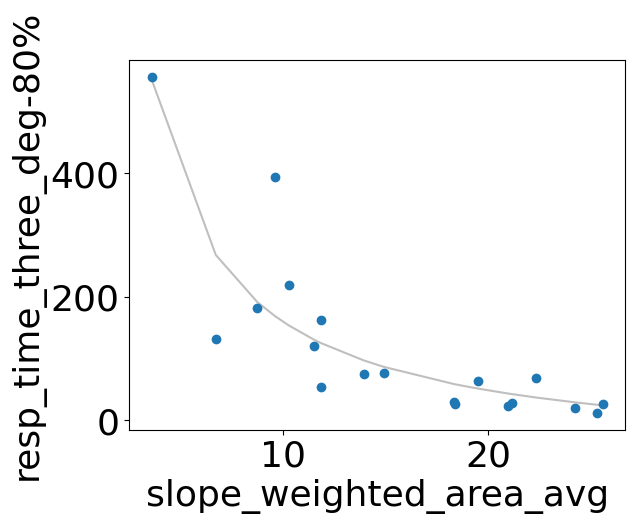

In [115]:
# best single variable ... 
prestige_model_3degx = ols(f"resp_time_three_deg_80 ~ hyperb(slope_weighted_area_avg)",
                                 data=df.iloc[1:]).fit()
print(prestige_model_3degx.summary())

fit_sorted = prestige_model_3degx.fittedvalues.sort_values()
plt.plot(df.loc[fit_sorted.index].slope_weighted_area_avg, fit_sorted.values, color='grey', alpha = 0.5)
plt.plot(df.slope_weighted_area_avg, df.resp_time_three_deg_80, 'o')
plt.xlabel('slope_weighted_area_avg')
plt.ylabel('resp_time_three_deg-80%')